<a href="https://colab.research.google.com/github/geohotz-png1/f_internship_ml/blob/main/FUTURE_ML_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
import pandas as pd
from prophet import Prophet
import os
from glob import glob

# Upload via files.upload() or mount Google Drive
train = pd.read_csv("train.csv", parse_dates=["Date"])
store = pd.read_csv("store.csv")
test = pd.read_csv("test.csv", parse_dates=["Date"])

# Merge train with store metadata
train = train.merge(store, on="Store", how="left")
test = test.merge(store, on="Store", how="left")

# Filter: Keep only days when store is open and sales > 0
train = train[(train["Open"] == 1) & (train["Sales"] > 0)]


In [ ]:
# Ensure StateHoliday is string type to avoid mixed types
train["StateHoliday"] = train["StateHoliday"].astype(str)
test["StateHoliday"] = test["StateHoliday"].astype(str)

# Add date-based features
train["Year"] = train["Date"].dt.year
train["Month"] = train["Date"].dt.month
train["Week"] = train["Date"].dt.isocalendar().week
train["Day"] = train["Date"].dt.day
train["DayOfWeek"] = train["Date"].dt.dayofweek

# Replace StateHoliday categories with numeric labels
train["StateHoliday"] = train["StateHoliday"].replace({'0': 0, 'a': 1, 'b': 2, 'c': 3})

# Optional: rolling features for trend learning
train = train.sort_values(["Store", "Date"])
train["Prev_Week_Sales"] = train.groupby("Store")["Sales"].shift(7)
train["Rolling_Mean"] = train.groupby("Store")["Sales"].transform(lambda x: x.rolling(7).mean())

# See updated data
train.head()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dnfgikgj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/che45fr7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72068', 'data', 'file=/tmp/tmp0u3jk68j/dnfgikgj.json', 'init=/tmp/tmp0u3jk68j/che45fr7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model7jz_488l/prophet_model-20250621131658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:16:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:16:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


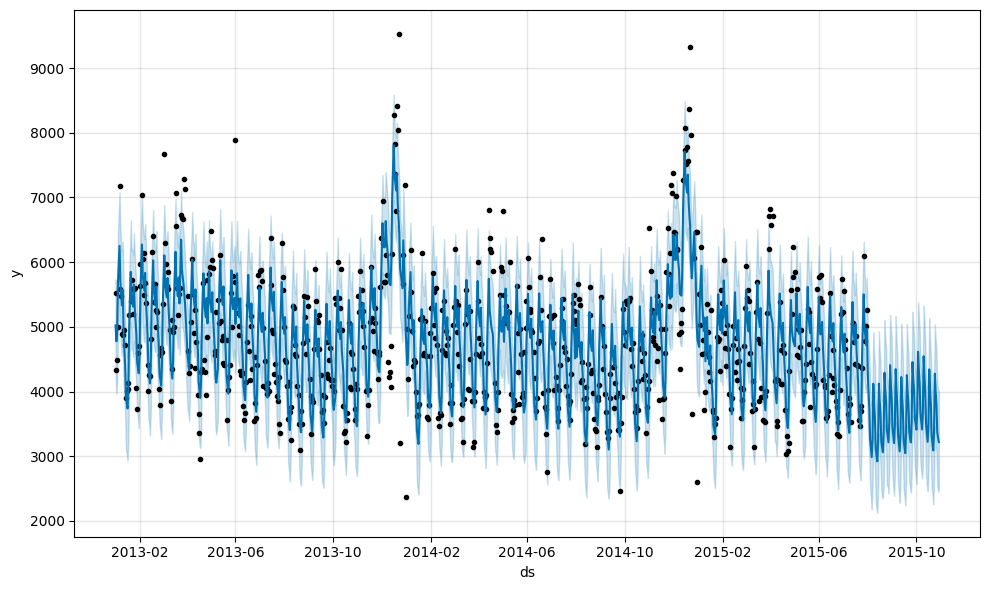

In [ ]:
# Filter data for Store 1
store_1 = train[train["Store"] == 1]

# Prophet needs 'ds' and 'y' columns
df = store_1[["Date", "Sales", "Promo", "SchoolHoliday", "StateHoliday"]].copy()
df.rename(columns={"Date": "ds", "Sales": "y"}, inplace=True)

# Prophet model with extra regressors
model = Prophet()
model.add_regressor("Promo")
model.add_regressor("SchoolHoliday")
model.add_regressor("StateHoliday")

# Train the model
model.fit(df)

# Forecast future 90 days
future = model.make_future_dataframe(periods=90)
future = future.merge(df.drop("y", axis=1), on="ds", how="left").fillna(0)

# Make prediction
forecast = model.predict(future)

# Save for Power BI or visualization
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].to_csv("forecast_store_1.csv", index=False)

# Plot
model.plot(forecast);


In [ ]:
# Create a folder to save outputs
os.makedirs("all_store_forecasts", exist_ok=True)

# Unique store IDs
store_ids = train["Store"].unique()

for store_id in store_ids:
    store_data = train[train["Store"] == store_id]

    # Skip stores with too few records
    if len(store_data) < 150:
        continue

    df = store_data[["Date", "Sales", "Promo", "SchoolHoliday", "StateHoliday"]].copy()
    df = df.rename(columns={"Date": "ds", "Sales": "y"})

    # Train Prophet
    m = Prophet()
    m.add_regressor("Promo")
    m.add_regressor("SchoolHoliday")
    m.add_regressor("StateHoliday")

    try:
        m.fit(df)

        # Future Data
        future = m.make_future_dataframe(periods=90)
        future = future.merge(df.drop("y", axis=1), on="ds", how="left").fillna(0)

        forecast = m.predict(future)
        forecast["Store"] = store_id

        # Save to CSV
        forecast[["ds", "yhat", "yhat_lower", "yhat_upper", "Store"]].to_csv(
            f"all_store_forecasts/store_{store_id}_forecast.csv", index=False
        )

        print(f"✅ Store {store_id} done")

    except Exception as e:
        print(f"❌ Store {store_id} failed: {e}")


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nmdj8hyd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5oxn84e0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68957', 'data', 'file=/tmp/tmp0u3jk68j/nmdj8hyd.json', 'init=/tmp/tmp0u3jk68j/5oxn84e0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelh7mwvbqe/prophet_model-20250621131811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u

✅ Store 1 done


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/x65qvqkx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95471', 'data', 'file=/tmp/tmp0u3jk68j/tjyv1_0l.json', 'init=/tmp/tmp0u3jk68j/x65qvqkx.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelnoovchwa/prophet_model-20250621131812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/918j76d8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nlaqw9v0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

✅ Store 2 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5k4lx1n4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pw4uzjvg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88876', 'data', 'file=/tmp/tmp0u3jk68j/5k4lx1n4.json', 'init=/tmp/tmp0u3jk68j/pw4uzjvg.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelbfunjqlu/prophet_model-20250621131813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 3 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9ne00vzk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5l8iofsk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52548', 'data', 'file=/tmp/tmp0u3jk68j/9ne00vzk.json', 'init=/tmp/tmp0u3jk68j/5l8iofsk.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelprz3mxeg/prophet_model-20250621131813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 4 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/g4tqe3zz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mhtv1_ki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85345', 'data', 'file=/tmp/tmp0u3jk68j/g4tqe3zz.json', 'init=/tmp/tmp0u3jk68j/mhtv1_ki.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model7szuz0gv/prophet_model-20250621131813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 5 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dhax1nu8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/aygxfyxl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14273', 'data', 'file=/tmp/tmp0u3jk68j/dhax1nu8.json', 'init=/tmp/tmp0u3jk68j/aygxfyxl.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modele548ylbe/prophet_model-20250621131814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 6 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_5igvesy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rkyxo_qb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96435', 'data', 'file=/tmp/tmp0u3jk68j/_5igvesy.json', 'init=/tmp/tmp0u3jk68j/rkyxo_qb.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9l0sc4c_/prophet_model-20250621131814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 7 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_m228a98.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4790kx7z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28188', 'data', 'file=/tmp/tmp0u3jk68j/_m228a98.json', 'init=/tmp/tmp0u3jk68j/4790kx7z.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelyf_ag5ic/prophet_model-20250621131814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 8 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1s1y9n5b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/h9jcmh1o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18604', 'data', 'file=/tmp/tmp0u3jk68j/1s1y9n5b.json', 'init=/tmp/tmp0u3jk68j/h9jcmh1o.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelg53o2pnk/prophet_model-20250621131815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 9 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/josn8q90.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/shy7ya13.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4662', 'data', 'file=/tmp/tmp0u3jk68j/josn8q90.json', 'init=/tmp/tmp0u3jk68j/shy7ya13.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelj9ujj85i/prophet_model-20250621131815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 10 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/koojd0dv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6ct5hq2o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70693', 'data', 'file=/tmp/tmp0u3jk68j/koojd0dv.json', 'init=/tmp/tmp0u3jk68j/6ct5hq2o.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeletp226up/prophet_model-20250621131815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 11 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_70t452b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/g_zhqbul.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54505', 'data', 'file=/tmp/tmp0u3jk68j/_70t452b.json', 'init=/tmp/tmp0u3jk68j/g_zhqbul.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzz_ml5p6/prophet_model-20250621131816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 12 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1fzk4o9m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uy50r_in.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66316', 'data', 'file=/tmp/tmp0u3jk68j/1fzk4o9m.json', 'init=/tmp/tmp0u3jk68j/uy50r_in.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model05legdc5/prophet_model-20250621131816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 13 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/krhsu7ks.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/d_z8t90j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23698', 'data', 'file=/tmp/tmp0u3jk68j/krhsu7ks.json', 'init=/tmp/tmp0u3jk68j/d_z8t90j.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelj1_r394u/prophet_model-20250621131816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 14 done


13:18:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/p6pgza5l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zqfvpvs5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34814', 'data', 'file=/tmp/tmp0u3jk68j/p6pgza5l.json', 'init=/tmp/tmp0u3jk68j/zqfvpvs5.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeldfv8_fkc/prophet_model-20250621131817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 15 done


13:18:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wgjrhuog.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t4jkis22.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81998', 'data', 'file=/tmp/tmp0u3jk68j/wgjrhuog.json', 'init=/tmp/tmp0u3jk68j/t4jkis22.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelfb7rtc3m/prophet_model-20250621131817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 16 done


13:18:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/h531ngub.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v0aagdqr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52426', 'data', 'file=/tmp/tmp0u3jk68j/h531ngub.json', 'init=/tmp/tmp0u3jk68j/v0aagdqr.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelgvbomjxu/prophet_model-20250621131818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 17 done


13:18:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ymbfw_ww.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/a336583p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57035', 'data', 'file=/tmp/tmp0u3jk68j/ymbfw_ww.json', 'init=/tmp/tmp0u3jk68j/a336583p.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelb3y5itq5/prophet_model-20250621131818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 18 done


13:18:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/f9bgmgpp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6ktybxb3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7471', 'data', 'file=/tmp/tmp0u3jk68j/f9bgmgpp.json', 'init=/tmp/tmp0u3jk68j/6ktybxb3.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelqgxia52p/prophet_model-20250621131819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 19 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_97ud1r_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ltslbah6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17194', 'data', 'file=/tmp/tmp0u3jk68j/_97ud1r_.json', 'init=/tmp/tmp0u3jk68j/ltslbah6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0hodx35p/prophet_model-20250621131819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 20 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/op7ghqe5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b77hqjsw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5286', 'data', 'file=/tmp/tmp0u3jk68j/op7ghqe5.json', 'init=/tmp/tmp0u3jk68j/b77hqjsw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelosvya3ha/prophet_model-20250621131819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 21 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jf_ny5mi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rhvedodk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19193', 'data', 'file=/tmp/tmp0u3jk68j/jf_ny5mi.json', 'init=/tmp/tmp0u3jk68j/rhvedodk.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8mcw034v/prophet_model-20250621131820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 22 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8li_md0m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/m95drg8z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44443', 'data', 'file=/tmp/tmp0u3jk68j/8li_md0m.json', 'init=/tmp/tmp0u3jk68j/m95drg8z.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelz9k2qzez/prophet_model-20250621131820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 23 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kzlfbe93.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xg549jor.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99151', 'data', 'file=/tmp/tmp0u3jk68j/kzlfbe93.json', 'init=/tmp/tmp0u3jk68j/xg549jor.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeltbdatajl/prophet_model-20250621131820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 24 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uevsd7x8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/95_5l1a1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78980', 'data', 'file=/tmp/tmp0u3jk68j/uevsd7x8.json', 'init=/tmp/tmp0u3jk68j/95_5l1a1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4212wxb3/prophet_model-20250621131821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 25 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b7ihesaf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/24d8p_t6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70765', 'data', 'file=/tmp/tmp0u3jk68j/b7ihesaf.json', 'init=/tmp/tmp0u3jk68j/24d8p_t6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelnzfelf65/prophet_model-20250621131821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 26 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jpgsdvdp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lzkj83wp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73599', 'data', 'file=/tmp/tmp0u3jk68j/jpgsdvdp.json', 'init=/tmp/tmp0u3jk68j/lzkj83wp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9zcv7x6v/prophet_model-20250621131821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 27 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7jo_1icg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/er3pqinb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76964', 'data', 'file=/tmp/tmp0u3jk68j/7jo_1icg.json', 'init=/tmp/tmp0u3jk68j/er3pqinb.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvw04fupi/prophet_model-20250621131822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 28 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/160cr__y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v59c9he0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24146', 'data', 'file=/tmp/tmp0u3jk68j/160cr__y.json', 'init=/tmp/tmp0u3jk68j/v59c9he0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelfn07fa_s/prophet_model-20250621131822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 29 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n31uo0ap.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kpbfaysy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71541', 'data', 'file=/tmp/tmp0u3jk68j/n31uo0ap.json', 'init=/tmp/tmp0u3jk68j/kpbfaysy.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelv3gwlm05/prophet_model-20250621131822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 30 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8em2gnup.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2fwyhb_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97993', 'data', 'file=/tmp/tmp0u3jk68j/8em2gnup.json', 'init=/tmp/tmp0u3jk68j/2fwyhb_n.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6lw5jgpz/prophet_model-20250621131823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 31 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vniq_gph.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nvzbgnqz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22885', 'data', 'file=/tmp/tmp0u3jk68j/vniq_gph.json', 'init=/tmp/tmp0u3jk68j/nvzbgnqz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9x68o63f/prophet_model-20250621131823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 32 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y8suwbpg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6fkgaol_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55091', 'data', 'file=/tmp/tmp0u3jk68j/y8suwbpg.json', 'init=/tmp/tmp0u3jk68j/6fkgaol_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4ty3nrsk/prophet_model-20250621131823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 33 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ztpqqyp7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vt2jl07_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66003', 'data', 'file=/tmp/tmp0u3jk68j/ztpqqyp7.json', 'init=/tmp/tmp0u3jk68j/vt2jl07_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelgujw60s_/prophet_model-20250621131824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 34 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/msxjl1gi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1j2nw_c5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92243', 'data', 'file=/tmp/tmp0u3jk68j/msxjl1gi.json', 'init=/tmp/tmp0u3jk68j/1j2nw_c5.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model3qxv_nep/prophet_model-20250621131824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 35 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/o_66ezga.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qpk49pp1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23022', 'data', 'file=/tmp/tmp0u3jk68j/o_66ezga.json', 'init=/tmp/tmp0u3jk68j/qpk49pp1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelt4y0vcpw/prophet_model-20250621131824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 36 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vbyp27so.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7uffucje.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75979', 'data', 'file=/tmp/tmp0u3jk68j/vbyp27so.json', 'init=/tmp/tmp0u3jk68j/7uffucje.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelcg77vxt6/prophet_model-20250621131824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 37 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/oy1rqsqr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jw933243.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92132', 'data', 'file=/tmp/tmp0u3jk68j/oy1rqsqr.json', 'init=/tmp/tmp0u3jk68j/jw933243.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeluvzjyq3m/prophet_model-20250621131825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 38 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/g0fu3ccn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tpnhkp8c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36305', 'data', 'file=/tmp/tmp0u3jk68j/g0fu3ccn.json', 'init=/tmp/tmp0u3jk68j/tpnhkp8c.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model34yy9msd/prophet_model-20250621131825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 39 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hcjfzzdr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/x_u9zj3x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11971', 'data', 'file=/tmp/tmp0u3jk68j/hcjfzzdr.json', 'init=/tmp/tmp0u3jk68j/x_u9zj3x.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model3l0g9lp0/prophet_model-20250621131825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 40 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zq192ehs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3c6gavs_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8033', 'data', 'file=/tmp/tmp0u3jk68j/zq192ehs.json', 'init=/tmp/tmp0u3jk68j/3c6gavs_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelt2d7sqv6/prophet_model-20250621131826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 41 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ln1mhbup.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/45pqc1jv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85476', 'data', 'file=/tmp/tmp0u3jk68j/ln1mhbup.json', 'init=/tmp/tmp0u3jk68j/45pqc1jv.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelycb92wfc/prophet_model-20250621131826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 42 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/sq0ofkww.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/olz5gt_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16384', 'data', 'file=/tmp/tmp0u3jk68j/sq0ofkww.json', 'init=/tmp/tmp0u3jk68j/olz5gt_k.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxz5kfui0/prophet_model-20250621131826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 43 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/szok4920.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2ife_rpe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10816', 'data', 'file=/tmp/tmp0u3jk68j/szok4920.json', 'init=/tmp/tmp0u3jk68j/2ife_rpe.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelb17mwifn/prophet_model-20250621131827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 44 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/a08izc45.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ac_up8_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46607', 'data', 'file=/tmp/tmp0u3jk68j/a08izc45.json', 'init=/tmp/tmp0u3jk68j/ac_up8_3.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_bfc34zg/prophet_model-20250621131827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 45 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0wy2qfqb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3gnvebnz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4253', 'data', 'file=/tmp/tmp0u3jk68j/0wy2qfqb.json', 'init=/tmp/tmp0u3jk68j/3gnvebnz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modely2bj86rg/prophet_model-20250621131827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 46 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t1dnrm5r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/cxhhgcc0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9608', 'data', 'file=/tmp/tmp0u3jk68j/t1dnrm5r.json', 'init=/tmp/tmp0u3jk68j/cxhhgcc0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelehfp03m1/prophet_model-20250621131828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 47 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5frfq4vj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jxebft2p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80402', 'data', 'file=/tmp/tmp0u3jk68j/5frfq4vj.json', 'init=/tmp/tmp0u3jk68j/jxebft2p.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model1cssj8l2/prophet_model-20250621131828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 48 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/18qf4rfy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fiq8_g7i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43183', 'data', 'file=/tmp/tmp0u3jk68j/18qf4rfy.json', 'init=/tmp/tmp0u3jk68j/fiq8_g7i.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model3cctpzep/prophet_model-20250621131828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 49 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nr8n4033.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4r7fhvvl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18309', 'data', 'file=/tmp/tmp0u3jk68j/nr8n4033.json', 'init=/tmp/tmp0u3jk68j/4r7fhvvl.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelnejsm9d0/prophet_model-20250621131829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 50 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/83iejm3w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/z7sq7cgf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97217', 'data', 'file=/tmp/tmp0u3jk68j/83iejm3w.json', 'init=/tmp/tmp0u3jk68j/z7sq7cgf.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model5x6ax2ou/prophet_model-20250621131829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 51 done


13:18:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wyynxq2m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yni2mdku.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10690', 'data', 'file=/tmp/tmp0u3jk68j/wyynxq2m.json', 'init=/tmp/tmp0u3jk68j/yni2mdku.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeloo9gl2u8/prophet_model-20250621131830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 52 done


13:18:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9nraka81.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ihjur17o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8659', 'data', 'file=/tmp/tmp0u3jk68j/9nraka81.json', 'init=/tmp/tmp0u3jk68j/ihjur17o.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_rngrpu0/prophet_model-20250621131830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 53 done


13:18:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6zh3plzt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/avf1lqrc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96965', 'data', 'file=/tmp/tmp0u3jk68j/6zh3plzt.json', 'init=/tmp/tmp0u3jk68j/avf1lqrc.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelninst13s/prophet_model-20250621131831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 54 done


13:18:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/87092ial.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n8kmwkr0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86424', 'data', 'file=/tmp/tmp0u3jk68j/87092ial.json', 'init=/tmp/tmp0u3jk68j/n8kmwkr0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model7larbzbk/prophet_model-20250621131831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 55 done


13:18:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gidt1e8t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0_8upc6y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94897', 'data', 'file=/tmp/tmp0u3jk68j/gidt1e8t.json', 'init=/tmp/tmp0u3jk68j/0_8upc6y.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeld_7dshp7/prophet_model-20250621131832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 56 done


13:18:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uj06smwa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nc6_5pbm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15139', 'data', 'file=/tmp/tmp0u3jk68j/uj06smwa.json', 'init=/tmp/tmp0u3jk68j/nc6_5pbm.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelw8p9pggb/prophet_model-20250621131832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 57 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kc329992.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9jiq8vn4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82908', 'data', 'file=/tmp/tmp0u3jk68j/kc329992.json', 'init=/tmp/tmp0u3jk68j/9jiq8vn4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelpl_m10u7/prophet_model-20250621131832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 58 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/z_tigrmk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/r6ow9ovo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40471', 'data', 'file=/tmp/tmp0u3jk68j/z_tigrmk.json', 'init=/tmp/tmp0u3jk68j/r6ow9ovo.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelkli5t60w/prophet_model-20250621131833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 59 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0q0bzy9d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lrjzrj_r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48927', 'data', 'file=/tmp/tmp0u3jk68j/0q0bzy9d.json', 'init=/tmp/tmp0u3jk68j/lrjzrj_r.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelwy47gydg/prophet_model-20250621131833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 60 done


13:18:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zb4j64sw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tci4oz1b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66836', 'data', 'file=/tmp/tmp0u3jk68j/zb4j64sw.json', 'init=/tmp/tmp0u3jk68j/tci4oz1b.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelo2fwuwyi/prophet_model-20250621131833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 61 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y9si438i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4ele_56t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80590', 'data', 'file=/tmp/tmp0u3jk68j/y9si438i.json', 'init=/tmp/tmp0u3jk68j/4ele_56t.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvmpm6nbu/prophet_model-20250621131834.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 62 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5l67ki_9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ud7d6j7e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69958', 'data', 'file=/tmp/tmp0u3jk68j/5l67ki_9.json', 'init=/tmp/tmp0u3jk68j/ud7d6j7e.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model5rmijgqh/prophet_model-20250621131834.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 63 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yiklc70f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xuithqop.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37990', 'data', 'file=/tmp/tmp0u3jk68j/yiklc70f.json', 'init=/tmp/tmp0u3jk68j/xuithqop.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8wq1rvbq/prophet_model-20250621131834.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 64 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/u59_sglr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y2neil2r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37851', 'data', 'file=/tmp/tmp0u3jk68j/u59_sglr.json', 'init=/tmp/tmp0u3jk68j/y2neil2r.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelmx_5myqt/prophet_model-20250621131835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 65 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tgsf3hb_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/z5ej4oh6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50776', 'data', 'file=/tmp/tmp0u3jk68j/tgsf3hb_.json', 'init=/tmp/tmp0u3jk68j/z5ej4oh6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelui_nf89a/prophet_model-20250621131835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 66 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8y5lodo7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zbbo6h24.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43814', 'data', 'file=/tmp/tmp0u3jk68j/8y5lodo7.json', 'init=/tmp/tmp0u3jk68j/zbbo6h24.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model5hgog9jc/prophet_model-20250621131835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 67 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jjh7jjod.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/w_f3h4_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25900', 'data', 'file=/tmp/tmp0u3jk68j/jjh7jjod.json', 'init=/tmp/tmp0u3jk68j/w_f3h4_0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelixvvs50g/prophet_model-20250621131836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 68 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/30ktg1c2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t_be2e4z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6733', 'data', 'file=/tmp/tmp0u3jk68j/30ktg1c2.json', 'init=/tmp/tmp0u3jk68j/t_be2e4z.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeleardfmdf/prophet_model-20250621131836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 69 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_w4xyyfb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ucyie_99.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53322', 'data', 'file=/tmp/tmp0u3jk68j/_w4xyyfb.json', 'init=/tmp/tmp0u3jk68j/ucyie_99.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelrg08qdjs/prophet_model-20250621131836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 70 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lwyyilt3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nd0wc8t5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5013', 'data', 'file=/tmp/tmp0u3jk68j/lwyyilt3.json', 'init=/tmp/tmp0u3jk68j/nd0wc8t5.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeliiqe9vft/prophet_model-20250621131837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 71 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/oaas2s64.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/x6b51g_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77271', 'data', 'file=/tmp/tmp0u3jk68j/oaas2s64.json', 'init=/tmp/tmp0u3jk68j/x6b51g_0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelb6owde7i/prophet_model-20250621131837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 72 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lsyvmomp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/algtg1o0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12773', 'data', 'file=/tmp/tmp0u3jk68j/lsyvmomp.json', 'init=/tmp/tmp0u3jk68j/algtg1o0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelaqff2w0z/prophet_model-20250621131837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 73 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zs4ol2ry.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/h402cdnj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63001', 'data', 'file=/tmp/tmp0u3jk68j/zs4ol2ry.json', 'init=/tmp/tmp0u3jk68j/h402cdnj.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model40_dnbbn/prophet_model-20250621131838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 74 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/cop7u50b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fwr8gs4t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84408', 'data', 'file=/tmp/tmp0u3jk68j/cop7u50b.json', 'init=/tmp/tmp0u3jk68j/fwr8gs4t.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzd_hjz4e/prophet_model-20250621131838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 75 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_8w12coo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/w2cgg3v4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21741', 'data', 'file=/tmp/tmp0u3jk68j/_8w12coo.json', 'init=/tmp/tmp0u3jk68j/w2cgg3v4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelc6u4eimd/prophet_model-20250621131838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 76 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/msrii9fv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2j8w5xm2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41845', 'data', 'file=/tmp/tmp0u3jk68j/msrii9fv.json', 'init=/tmp/tmp0u3jk68j/2j8w5xm2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelrdt7w8e6/prophet_model-20250621131839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 77 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/x3goix0_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/km5dvbuc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68775', 'data', 'file=/tmp/tmp0u3jk68j/x3goix0_.json', 'init=/tmp/tmp0u3jk68j/km5dvbuc.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9t01dt9n/prophet_model-20250621131839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 78 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/e2cx2lrd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xhs9zu40.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57178', 'data', 'file=/tmp/tmp0u3jk68j/e2cx2lrd.json', 'init=/tmp/tmp0u3jk68j/xhs9zu40.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelazahojzk/prophet_model-20250621131839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 79 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zvc83i2o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ch0kmq37.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20542', 'data', 'file=/tmp/tmp0u3jk68j/zvc83i2o.json', 'init=/tmp/tmp0u3jk68j/ch0kmq37.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelajnwxk4v/prophet_model-20250621131840.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 80 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pbihfpz3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_poftz8f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3288', 'data', 'file=/tmp/tmp0u3jk68j/pbihfpz3.json', 'init=/tmp/tmp0u3jk68j/_poftz8f.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model1outfvwv/prophet_model-20250621131840.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 81 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/x1_aol7f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3jdsbpgx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50806', 'data', 'file=/tmp/tmp0u3jk68j/x1_aol7f.json', 'init=/tmp/tmp0u3jk68j/3jdsbpgx.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelagrvbh2o/prophet_model-20250621131840.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 82 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/08yyw77e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5u1jrpei.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52560', 'data', 'file=/tmp/tmp0u3jk68j/08yyw77e.json', 'init=/tmp/tmp0u3jk68j/5u1jrpei.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8exzyogx/prophet_model-20250621131841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 83 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/cuyiu311.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/cfoqmxmz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63294', 'data', 'file=/tmp/tmp0u3jk68j/cuyiu311.json', 'init=/tmp/tmp0u3jk68j/cfoqmxmz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0x7xlv3z/prophet_model-20250621131841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 84 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ijgwi8ip.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/skshn57y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56653', 'data', 'file=/tmp/tmp0u3jk68j/ijgwi8ip.json', 'init=/tmp/tmp0u3jk68j/skshn57y.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model7fgw79d3/prophet_model-20250621131841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 85 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/39w038i1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/h93cohvc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18596', 'data', 'file=/tmp/tmp0u3jk68j/39w038i1.json', 'init=/tmp/tmp0u3jk68j/h93cohvc.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8bn2qjuo/prophet_model-20250621131842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 86 done


13:18:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/75tkmt3h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7vyxk_jx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59938', 'data', 'file=/tmp/tmp0u3jk68j/75tkmt3h.json', 'init=/tmp/tmp0u3jk68j/7vyxk_jx.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0wz3v6r_/prophet_model-20250621131842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 87 done


13:18:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/462a2tpt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kt_1g82k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49346', 'data', 'file=/tmp/tmp0u3jk68j/462a2tpt.json', 'init=/tmp/tmp0u3jk68j/kt_1g82k.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4bxodgg0/prophet_model-20250621131843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 88 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bvkubfq8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_6tb3t8j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21657', 'data', 'file=/tmp/tmp0u3jk68j/bvkubfq8.json', 'init=/tmp/tmp0u3jk68j/_6tb3t8j.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelmpoley87/prophet_model-20250621131843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 89 done


13:18:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fx_ombq1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/h3twcqns.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36872', 'data', 'file=/tmp/tmp0u3jk68j/fx_ombq1.json', 'init=/tmp/tmp0u3jk68j/h3twcqns.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model5m083nem/prophet_model-20250621131844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 90 done


13:18:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ycq_u39l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ngmsp4p0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74631', 'data', 'file=/tmp/tmp0u3jk68j/ycq_u39l.json', 'init=/tmp/tmp0u3jk68j/ngmsp4p0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeldkouf0nu/prophet_model-20250621131844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 91 done


13:18:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/d9t13jk4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/edy4wj3h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64632', 'data', 'file=/tmp/tmp0u3jk68j/d9t13jk4.json', 'init=/tmp/tmp0u3jk68j/edy4wj3h.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelw8fmlvyl/prophet_model-20250621131845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 92 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/idmhzibz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fcnicqr_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59839', 'data', 'file=/tmp/tmp0u3jk68j/idmhzibz.json', 'init=/tmp/tmp0u3jk68j/fcnicqr_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modells2obcm4/prophet_model-20250621131845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 93 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/k4wjzmam.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/r6oi8hnq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5421', 'data', 'file=/tmp/tmp0u3jk68j/k4wjzmam.json', 'init=/tmp/tmp0u3jk68j/r6oi8hnq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelp09t_tdh/prophet_model-20250621131845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 94 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8fqc3_ey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/siwsmhjo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26088', 'data', 'file=/tmp/tmp0u3jk68j/8fqc3_ey.json', 'init=/tmp/tmp0u3jk68j/siwsmhjo.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelfbu1bta6/prophet_model-20250621131846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 95 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fn4l5i71.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/o09brnzp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96317', 'data', 'file=/tmp/tmp0u3jk68j/fn4l5i71.json', 'init=/tmp/tmp0u3jk68j/o09brnzp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelkqhm322k/prophet_model-20250621131846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 96 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5kosib_f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/s57bg15h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11684', 'data', 'file=/tmp/tmp0u3jk68j/5kosib_f.json', 'init=/tmp/tmp0u3jk68j/s57bg15h.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelge61km6v/prophet_model-20250621131846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 97 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8rxegzix.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fmjnq31a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58686', 'data', 'file=/tmp/tmp0u3jk68j/8rxegzix.json', 'init=/tmp/tmp0u3jk68j/fmjnq31a.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelfc7ca3g4/prophet_model-20250621131847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 98 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vewjwj07.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hv390_7q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76899', 'data', 'file=/tmp/tmp0u3jk68j/vewjwj07.json', 'init=/tmp/tmp0u3jk68j/hv390_7q.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelmyiey_dw/prophet_model-20250621131847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 99 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qy_cp3_9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/htodfpks.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62569', 'data', 'file=/tmp/tmp0u3jk68j/qy_cp3_9.json', 'init=/tmp/tmp0u3jk68j/htodfpks.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelsrkaro76/prophet_model-20250621131847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 100 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ap_b54gu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/47ogtlez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28277', 'data', 'file=/tmp/tmp0u3jk68j/ap_b54gu.json', 'init=/tmp/tmp0u3jk68j/47ogtlez.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6y6n0kz8/prophet_model-20250621131848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 101 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/r4wgzes0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/u5rlytu9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52876', 'data', 'file=/tmp/tmp0u3jk68j/r4wgzes0.json', 'init=/tmp/tmp0u3jk68j/u5rlytu9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelikxwocor/prophet_model-20250621131848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 102 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/iyaskhza.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ugpo8oyn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48338', 'data', 'file=/tmp/tmp0u3jk68j/iyaskhza.json', 'init=/tmp/tmp0u3jk68j/ugpo8oyn.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelbi0vf3_7/prophet_model-20250621131848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 103 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mb5rgas2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zb4_9fn7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56353', 'data', 'file=/tmp/tmp0u3jk68j/mb5rgas2.json', 'init=/tmp/tmp0u3jk68j/zb4_9fn7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_models333rb1e/prophet_model-20250621131849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 104 done


13:18:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/a_fd23xv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4afq32dj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2744', 'data', 'file=/tmp/tmp0u3jk68j/a_fd23xv.json', 'init=/tmp/tmp0u3jk68j/4afq32dj.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model996d8c10/prophet_model-20250621131849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 105 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qsw3i70j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/o9eysuj9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73503', 'data', 'file=/tmp/tmp0u3jk68j/qsw3i70j.json', 'init=/tmp/tmp0u3jk68j/o9eysuj9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelrzxbhq8a/prophet_model-20250621131849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 106 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rwje3o8t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fh3z1a0s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96366', 'data', 'file=/tmp/tmp0u3jk68j/rwje3o8t.json', 'init=/tmp/tmp0u3jk68j/fh3z1a0s.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeloku2iyaj/prophet_model-20250621131850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 107 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tqxxxx7w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qu04qxhz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18813', 'data', 'file=/tmp/tmp0u3jk68j/tqxxxx7w.json', 'init=/tmp/tmp0u3jk68j/qu04qxhz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelwrm4u88k/prophet_model-20250621131850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 108 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/cngh7y1r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ov40rc1e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9156', 'data', 'file=/tmp/tmp0u3jk68j/cngh7y1r.json', 'init=/tmp/tmp0u3jk68j/ov40rc1e.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeljrrxb0so/prophet_model-20250621131850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 109 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l3hn04ru.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dr2d4ei2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71846', 'data', 'file=/tmp/tmp0u3jk68j/l3hn04ru.json', 'init=/tmp/tmp0u3jk68j/dr2d4ei2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelcv7riwn2/prophet_model-20250621131851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 110 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mt4c4pgs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dwjv8zkr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39436', 'data', 'file=/tmp/tmp0u3jk68j/mt4c4pgs.json', 'init=/tmp/tmp0u3jk68j/dwjv8zkr.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelv63_t_ds/prophet_model-20250621131851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 111 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t8tggkvz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/81c_byrf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70105', 'data', 'file=/tmp/tmp0u3jk68j/t8tggkvz.json', 'init=/tmp/tmp0u3jk68j/81c_byrf.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelo7tud5ex/prophet_model-20250621131851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 112 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ecvsilcw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/u45ksk4l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41632', 'data', 'file=/tmp/tmp0u3jk68j/ecvsilcw.json', 'init=/tmp/tmp0u3jk68j/u45ksk4l.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeloehr8s1a/prophet_model-20250621131852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 113 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/i7swa932.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/932mje6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85530', 'data', 'file=/tmp/tmp0u3jk68j/i7swa932.json', 'init=/tmp/tmp0u3jk68j/932mje6a.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelgjw5pp5f/prophet_model-20250621131852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 114 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/932yu7_w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gu2_zufv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22676', 'data', 'file=/tmp/tmp0u3jk68j/932yu7_w.json', 'init=/tmp/tmp0u3jk68j/gu2_zufv.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6f6c5ta5/prophet_model-20250621131852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 115 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gyoba5h6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wld9we8f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48381', 'data', 'file=/tmp/tmp0u3jk68j/gyoba5h6.json', 'init=/tmp/tmp0u3jk68j/wld9we8f.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelv83xk0zy/prophet_model-20250621131853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 116 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9uxozm0p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/eb20kh1i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83368', 'data', 'file=/tmp/tmp0u3jk68j/9uxozm0p.json', 'init=/tmp/tmp0u3jk68j/eb20kh1i.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelnfk_p56j/prophet_model-20250621131853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 117 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qp364knl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4oh92usw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4542', 'data', 'file=/tmp/tmp0u3jk68j/qp364knl.json', 'init=/tmp/tmp0u3jk68j/4oh92usw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8170ra_z/prophet_model-20250621131853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 118 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/eeycnl4r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9f_10xbv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61325', 'data', 'file=/tmp/tmp0u3jk68j/eeycnl4r.json', 'init=/tmp/tmp0u3jk68j/9f_10xbv.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelcadnokj1/prophet_model-20250621131854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 119 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mvi7h3k0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v1_n46ta.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46885', 'data', 'file=/tmp/tmp0u3jk68j/mvi7h3k0.json', 'init=/tmp/tmp0u3jk68j/v1_n46ta.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelrev5r9_c/prophet_model-20250621131854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 120 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/184_42q9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ciaebqdw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90510', 'data', 'file=/tmp/tmp0u3jk68j/184_42q9.json', 'init=/tmp/tmp0u3jk68j/ciaebqdw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelhm4z3_pt/prophet_model-20250621131854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 121 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/srfcwd3w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2nc_3al2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20024', 'data', 'file=/tmp/tmp0u3jk68j/srfcwd3w.json', 'init=/tmp/tmp0u3jk68j/2nc_3al2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model1axy49xb/prophet_model-20250621131855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 122 done


13:18:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nbpj72gk.json


✅ Store 123 done


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/57grn1sa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73758', 'data', 'file=/tmp/tmp0u3jk68j/nbpj72gk.json', 'init=/tmp/tmp0u3jk68j/57grn1sa.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model1yvi_7o1/prophet_model-20250621131856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mflbrgig.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kg264ka8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

✅ Store 124 done


13:18:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0zpz578q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yif0avj7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17980', 'data', 'file=/tmp/tmp0u3jk68j/0zpz578q.json', 'init=/tmp/tmp0u3jk68j/yif0avj7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modela7xir2jj/prophet_model-20250621131857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 125 done


13:18:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/e59wlcpz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wf5eo8zd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61621', 'data', 'file=/tmp/tmp0u3jk68j/e59wlcpz.json', 'init=/tmp/tmp0u3jk68j/wf5eo8zd.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0sjpsufv/prophet_model-20250621131857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 126 done


13:18:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/89038ejp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tz4mza5s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65378', 'data', 'file=/tmp/tmp0u3jk68j/89038ejp.json', 'init=/tmp/tmp0u3jk68j/tz4mza5s.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model81hci7dc/prophet_model-20250621131858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 127 done


13:18:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ig9nmug3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2lyrhtge.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74470', 'data', 'file=/tmp/tmp0u3jk68j/ig9nmug3.json', 'init=/tmp/tmp0u3jk68j/2lyrhtge.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelrqy9kr8c/prophet_model-20250621131858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 128 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/flzdtgci.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zldbxsh1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91181', 'data', 'file=/tmp/tmp0u3jk68j/flzdtgci.json', 'init=/tmp/tmp0u3jk68j/zldbxsh1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelkm_n_fsl/prophet_model-20250621131858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 129 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kta380q2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/z16u5094.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25307', 'data', 'file=/tmp/tmp0u3jk68j/kta380q2.json', 'init=/tmp/tmp0u3jk68j/z16u5094.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modellxs_ekh2/prophet_model-20250621131859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 130 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tq9h5shj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5hg03bdp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3398', 'data', 'file=/tmp/tmp0u3jk68j/tq9h5shj.json', 'init=/tmp/tmp0u3jk68j/5hg03bdp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelfm61qu09/prophet_model-20250621131859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 131 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_8ongn06.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uh4_yuu6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17253', 'data', 'file=/tmp/tmp0u3jk68j/_8ongn06.json', 'init=/tmp/tmp0u3jk68j/uh4_yuu6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeljp638c0x/prophet_model-20250621131859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:18:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:18:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 132 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ni4wrxv3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gmvdkvry.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87181', 'data', 'file=/tmp/tmp0u3jk68j/ni4wrxv3.json', 'init=/tmp/tmp0u3jk68j/gmvdkvry.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelqonr_or2/prophet_model-20250621131900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 133 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/17lr4rwm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/353w5k9q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17957', 'data', 'file=/tmp/tmp0u3jk68j/17lr4rwm.json', 'init=/tmp/tmp0u3jk68j/353w5k9q.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelv3s5m66h/prophet_model-20250621131900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 134 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/45rdw9bz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tty9pyen.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46149', 'data', 'file=/tmp/tmp0u3jk68j/45rdw9bz.json', 'init=/tmp/tmp0u3jk68j/tty9pyen.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelnnyjqqkp/prophet_model-20250621131900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 135 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/sydfqerd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xwi8vx0x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82867', 'data', 'file=/tmp/tmp0u3jk68j/sydfqerd.json', 'init=/tmp/tmp0u3jk68j/xwi8vx0x.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelsy6aykdu/prophet_model-20250621131901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 136 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gir6p9xy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ibn3nbav.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38558', 'data', 'file=/tmp/tmp0u3jk68j/gir6p9xy.json', 'init=/tmp/tmp0u3jk68j/ibn3nbav.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeldq8wlv8x/prophet_model-20250621131901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 137 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gj_nlvv0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ua_zm9dp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52859', 'data', 'file=/tmp/tmp0u3jk68j/gj_nlvv0.json', 'init=/tmp/tmp0u3jk68j/ua_zm9dp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeljh_po_3c/prophet_model-20250621131901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 138 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nts1yzcn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v_yua6jf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54963', 'data', 'file=/tmp/tmp0u3jk68j/nts1yzcn.json', 'init=/tmp/tmp0u3jk68j/v_yua6jf.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeloaqo13w8/prophet_model-20250621131901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 139 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ygw3olgr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/48wv74sg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35009', 'data', 'file=/tmp/tmp0u3jk68j/ygw3olgr.json', 'init=/tmp/tmp0u3jk68j/48wv74sg.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model5p45ry9v/prophet_model-20250621131902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 140 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/m8j9dcoh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l27ljs7u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60504', 'data', 'file=/tmp/tmp0u3jk68j/m8j9dcoh.json', 'init=/tmp/tmp0u3jk68j/l27ljs7u.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelhbseu0nw/prophet_model-20250621131902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 141 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ok79_g3a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l7oowgfn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57103', 'data', 'file=/tmp/tmp0u3jk68j/ok79_g3a.json', 'init=/tmp/tmp0u3jk68j/l7oowgfn.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model15vrj__v/prophet_model-20250621131903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 142 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/myrckvt1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/28pu60e4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83627', 'data', 'file=/tmp/tmp0u3jk68j/myrckvt1.json', 'init=/tmp/tmp0u3jk68j/28pu60e4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6h_0n609/prophet_model-20250621131903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 143 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ggp4rdto.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/na773c3q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77048', 'data', 'file=/tmp/tmp0u3jk68j/ggp4rdto.json', 'init=/tmp/tmp0u3jk68j/na773c3q.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modell0z7na_j/prophet_model-20250621131903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 144 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lrcns_ib.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lz19fu_7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46644', 'data', 'file=/tmp/tmp0u3jk68j/lrcns_ib.json', 'init=/tmp/tmp0u3jk68j/lz19fu_7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelu9m60gf2/prophet_model-20250621131903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 145 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/quyo7hjf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5mkbpkv6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44076', 'data', 'file=/tmp/tmp0u3jk68j/quyo7hjf.json', 'init=/tmp/tmp0u3jk68j/5mkbpkv6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_08gq3ze/prophet_model-20250621131904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 146 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nj7gzda6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/68uk8has.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67702', 'data', 'file=/tmp/tmp0u3jk68j/nj7gzda6.json', 'init=/tmp/tmp0u3jk68j/68uk8has.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model97i_vywt/prophet_model-20250621131904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 147 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/smpddi2m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zjsng72r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24320', 'data', 'file=/tmp/tmp0u3jk68j/smpddi2m.json', 'init=/tmp/tmp0u3jk68j/zjsng72r.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model16yre480/prophet_model-20250621131905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 148 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2hsu098e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/alepjt01.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48713', 'data', 'file=/tmp/tmp0u3jk68j/2hsu098e.json', 'init=/tmp/tmp0u3jk68j/alepjt01.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvtta5ctf/prophet_model-20250621131905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 149 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/u51tvu5e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4s6induz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74813', 'data', 'file=/tmp/tmp0u3jk68j/u51tvu5e.json', 'init=/tmp/tmp0u3jk68j/4s6induz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_models038tmjp/prophet_model-20250621131905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 150 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/m43z8unj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0onibc42.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90556', 'data', 'file=/tmp/tmp0u3jk68j/m43z8unj.json', 'init=/tmp/tmp0u3jk68j/0onibc42.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelfv__54q7/prophet_model-20250621131906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 151 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/s6mz5c8l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/54_nrblh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29750', 'data', 'file=/tmp/tmp0u3jk68j/s6mz5c8l.json', 'init=/tmp/tmp0u3jk68j/54_nrblh.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelao5ox1mm/prophet_model-20250621131906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 152 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3jrfahvo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8dh43xs2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13928', 'data', 'file=/tmp/tmp0u3jk68j/3jrfahvo.json', 'init=/tmp/tmp0u3jk68j/8dh43xs2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeliva0d_hl/prophet_model-20250621131906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 153 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bsmssgyd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/u102rngp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70200', 'data', 'file=/tmp/tmp0u3jk68j/bsmssgyd.json', 'init=/tmp/tmp0u3jk68j/u102rngp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelui3n_4mf/prophet_model-20250621131907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 154 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hw8azjo1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ts_yfl6d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29893', 'data', 'file=/tmp/tmp0u3jk68j/hw8azjo1.json', 'init=/tmp/tmp0u3jk68j/ts_yfl6d.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelbhfj4zte/prophet_model-20250621131907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 155 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ossheg2z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/u4v6_bx8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89569', 'data', 'file=/tmp/tmp0u3jk68j/ossheg2z.json', 'init=/tmp/tmp0u3jk68j/u4v6_bx8.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeldl3rxqh4/prophet_model-20250621131907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 156 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dszq4ds2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/anjxcdbk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42022', 'data', 'file=/tmp/tmp0u3jk68j/dszq4ds2.json', 'init=/tmp/tmp0u3jk68j/anjxcdbk.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeln765csyc/prophet_model-20250621131908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 157 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dbf98ymi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/g4zouxty.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90759', 'data', 'file=/tmp/tmp0u3jk68j/dbf98ymi.json', 'init=/tmp/tmp0u3jk68j/g4zouxty.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelonrpe_m1/prophet_model-20250621131908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 158 done


13:19:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tcw0q18x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0v8jxdly.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23817', 'data', 'file=/tmp/tmp0u3jk68j/tcw0q18x.json', 'init=/tmp/tmp0u3jk68j/0v8jxdly.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelim08nh1c/prophet_model-20250621131909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 159 done


13:19:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/a_xzt8cz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ymgizpzi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49093', 'data', 'file=/tmp/tmp0u3jk68j/a_xzt8cz.json', 'init=/tmp/tmp0u3jk68j/ymgizpzi.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelwxkhczne/prophet_model-20250621131909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 160 done


13:19:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lu4a3cxw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gx5ghy2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34171', 'data', 'file=/tmp/tmp0u3jk68j/lu4a3cxw.json', 'init=/tmp/tmp0u3jk68j/gx5ghy2y.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_a6lrybx/prophet_model-20250621131910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 161 done


13:19:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1wf7fe56.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/53i42iuz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83605', 'data', 'file=/tmp/tmp0u3jk68j/1wf7fe56.json', 'init=/tmp/tmp0u3jk68j/53i42iuz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model3oqbtqpk/prophet_model-20250621131910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 162 done


13:19:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n1257dnm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rz5g1tw9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15129', 'data', 'file=/tmp/tmp0u3jk68j/n1257dnm.json', 'init=/tmp/tmp0u3jk68j/rz5g1tw9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelyi4l9l24/prophet_model-20250621131911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 163 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pobre4zh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jj5p6tu1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91562', 'data', 'file=/tmp/tmp0u3jk68j/pobre4zh.json', 'init=/tmp/tmp0u3jk68j/jj5p6tu1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvp4w7vur/prophet_model-20250621131911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 164 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/487tx_3c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/24btatbq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8709', 'data', 'file=/tmp/tmp0u3jk68j/487tx_3c.json', 'init=/tmp/tmp0u3jk68j/24btatbq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model61ddzupf/prophet_model-20250621131911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 165 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/iosxl551.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0in7l0u2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13275', 'data', 'file=/tmp/tmp0u3jk68j/iosxl551.json', 'init=/tmp/tmp0u3jk68j/0in7l0u2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9m6swt2y/prophet_model-20250621131912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 166 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/60noevwf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/aupite9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81434', 'data', 'file=/tmp/tmp0u3jk68j/60noevwf.json', 'init=/tmp/tmp0u3jk68j/aupite9r.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9isviwbc/prophet_model-20250621131912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 167 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/w3h9ef2t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ctmwumvr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88511', 'data', 'file=/tmp/tmp0u3jk68j/w3h9ef2t.json', 'init=/tmp/tmp0u3jk68j/ctmwumvr.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelipxt1owc/prophet_model-20250621131912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 168 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/d952nvib.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7zz6qol4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48034', 'data', 'file=/tmp/tmp0u3jk68j/d952nvib.json', 'init=/tmp/tmp0u3jk68j/7zz6qol4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelirveyz0_/prophet_model-20250621131913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 169 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uws348z9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7vle8rq8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51149', 'data', 'file=/tmp/tmp0u3jk68j/uws348z9.json', 'init=/tmp/tmp0u3jk68j/7vle8rq8.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4infiasp/prophet_model-20250621131913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 170 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8jboa9_c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/00oa3zih.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25382', 'data', 'file=/tmp/tmp0u3jk68j/8jboa9_c.json', 'init=/tmp/tmp0u3jk68j/00oa3zih.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelz0_ktrr3/prophet_model-20250621131913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 171 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zgy3fsn9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/s3ntgi7z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38709', 'data', 'file=/tmp/tmp0u3jk68j/zgy3fsn9.json', 'init=/tmp/tmp0u3jk68j/s3ntgi7z.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelhhrquy_c/prophet_model-20250621131914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 172 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/cucnrvia.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4j1quttb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52663', 'data', 'file=/tmp/tmp0u3jk68j/cucnrvia.json', 'init=/tmp/tmp0u3jk68j/4j1quttb.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelr4wtbxsn/prophet_model-20250621131914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 173 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uqgjko_c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b4sbon_d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76616', 'data', 'file=/tmp/tmp0u3jk68j/uqgjko_c.json', 'init=/tmp/tmp0u3jk68j/b4sbon_d.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeli5ogy4i0/prophet_model-20250621131914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 174 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zq144e0c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gkochfze.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56356', 'data', 'file=/tmp/tmp0u3jk68j/zq144e0c.json', 'init=/tmp/tmp0u3jk68j/gkochfze.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model139fkmxo/prophet_model-20250621131915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 175 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7gtr18pg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/c0qsat0q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38028', 'data', 'file=/tmp/tmp0u3jk68j/7gtr18pg.json', 'init=/tmp/tmp0u3jk68j/c0qsat0q.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelw0_e26d5/prophet_model-20250621131915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 176 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tyca6xqm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xks47aaj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34292', 'data', 'file=/tmp/tmp0u3jk68j/tyca6xqm.json', 'init=/tmp/tmp0u3jk68j/xks47aaj.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelv5i8g2dx/prophet_model-20250621131915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 177 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2pmby0nj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3w44lb6w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41465', 'data', 'file=/tmp/tmp0u3jk68j/2pmby0nj.json', 'init=/tmp/tmp0u3jk68j/3w44lb6w.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model7htktty1/prophet_model-20250621131916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 178 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t6sdec7c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/e46slu5o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45315', 'data', 'file=/tmp/tmp0u3jk68j/t6sdec7c.json', 'init=/tmp/tmp0u3jk68j/e46slu5o.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelsirh61ji/prophet_model-20250621131916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 179 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/svixsjkd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yhveynp2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91452', 'data', 'file=/tmp/tmp0u3jk68j/svixsjkd.json', 'init=/tmp/tmp0u3jk68j/yhveynp2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxb3rxe35/prophet_model-20250621131916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 180 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8s7cytjs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vpykxzh9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59861', 'data', 'file=/tmp/tmp0u3jk68j/8s7cytjs.json', 'init=/tmp/tmp0u3jk68j/vpykxzh9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_models1demge1/prophet_model-20250621131917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 181 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n5lmk1zs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qss7qb3e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6884', 'data', 'file=/tmp/tmp0u3jk68j/n5lmk1zs.json', 'init=/tmp/tmp0u3jk68j/qss7qb3e.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model40ackqop/prophet_model-20250621131917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 182 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/16j0n4z1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/onalpmq3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45688', 'data', 'file=/tmp/tmp0u3jk68j/16j0n4z1.json', 'init=/tmp/tmp0u3jk68j/onalpmq3.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeljl2cdbu3/prophet_model-20250621131917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 183 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b_zd3uka.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l_42rzfc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88392', 'data', 'file=/tmp/tmp0u3jk68j/b_zd3uka.json', 'init=/tmp/tmp0u3jk68j/l_42rzfc.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelmml0j523/prophet_model-20250621131918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 184 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3jsxc9g1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8u4u1jtp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16094', 'data', 'file=/tmp/tmp0u3jk68j/3jsxc9g1.json', 'init=/tmp/tmp0u3jk68j/8u4u1jtp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelo5e17spa/prophet_model-20250621131918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 185 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v9_0oyw4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0hcbzb8p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15981', 'data', 'file=/tmp/tmp0u3jk68j/v9_0oyw4.json', 'init=/tmp/tmp0u3jk68j/0hcbzb8p.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelek8jwd5a/prophet_model-20250621131918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 186 done


13:19:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3g1s6fgf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9t3tbnru.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89259', 'data', 'file=/tmp/tmp0u3jk68j/3g1s6fgf.json', 'init=/tmp/tmp0u3jk68j/9t3tbnru.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelifgj6yoe/prophet_model-20250621131919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 187 done


13:19:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/043kqawk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/p04zhhbq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74043', 'data', 'file=/tmp/tmp0u3jk68j/043kqawk.json', 'init=/tmp/tmp0u3jk68j/p04zhhbq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelwh36zht_/prophet_model-20250621131919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 188 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gzps2u20.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qk6ms5lr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28757', 'data', 'file=/tmp/tmp0u3jk68j/gzps2u20.json', 'init=/tmp/tmp0u3jk68j/qk6ms5lr.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model1wnxlk9k/prophet_model-20250621131920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 189 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8gy686dx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7dd7crk4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58470', 'data', 'file=/tmp/tmp0u3jk68j/8gy686dx.json', 'init=/tmp/tmp0u3jk68j/7dd7crk4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2p2w9v7b/prophet_model-20250621131920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 190 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bhu3sivq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v_bvlmsy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3488', 'data', 'file=/tmp/tmp0u3jk68j/bhu3sivq.json', 'init=/tmp/tmp0u3jk68j/v_bvlmsy.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model1cfqcj72/prophet_model-20250621131920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 191 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qsul6pn_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/m4qqytl8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79867', 'data', 'file=/tmp/tmp0u3jk68j/qsul6pn_.json', 'init=/tmp/tmp0u3jk68j/m4qqytl8.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeluu85vl2v/prophet_model-20250621131921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 192 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/u2ecp6cl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gkcmqt6s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1055', 'data', 'file=/tmp/tmp0u3jk68j/u2ecp6cl.json', 'init=/tmp/tmp0u3jk68j/gkcmqt6s.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelqttlxvi8/prophet_model-20250621131921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 193 done


13:19:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yux_u6aw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0keiqnfk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77470', 'data', 'file=/tmp/tmp0u3jk68j/yux_u6aw.json', 'init=/tmp/tmp0u3jk68j/0keiqnfk.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelchh7yo7h/prophet_model-20250621131921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 194 done


13:19:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rxnmewvc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/aic9ezdy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13978', 'data', 'file=/tmp/tmp0u3jk68j/rxnmewvc.json', 'init=/tmp/tmp0u3jk68j/aic9ezdy.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeleg2u0rmu/prophet_model-20250621131922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 195 done


13:19:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/eoyo8f38.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/f7cri3wp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65543', 'data', 'file=/tmp/tmp0u3jk68j/eoyo8f38.json', 'init=/tmp/tmp0u3jk68j/f7cri3wp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelw_ndmk5s/prophet_model-20250621131922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 196 done


13:19:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6cwun8s2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9y9eycs7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58671', 'data', 'file=/tmp/tmp0u3jk68j/6cwun8s2.json', 'init=/tmp/tmp0u3jk68j/9y9eycs7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeltur2byl8/prophet_model-20250621131923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 197 done


13:19:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ltctujlx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/as94k6if.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29333', 'data', 'file=/tmp/tmp0u3jk68j/ltctujlx.json', 'init=/tmp/tmp0u3jk68j/as94k6if.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelkttsjqnl/prophet_model-20250621131923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 198 done


13:19:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/g4yg9c_b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vcrpgue_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7336', 'data', 'file=/tmp/tmp0u3jk68j/g4yg9c_b.json', 'init=/tmp/tmp0u3jk68j/vcrpgue_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelq8357x7s/prophet_model-20250621131924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 199 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/clxxsu0p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lvj2fes5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3515', 'data', 'file=/tmp/tmp0u3jk68j/clxxsu0p.json', 'init=/tmp/tmp0u3jk68j/lvj2fes5.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modell0fdq6jf/prophet_model-20250621131924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 200 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hlex0hop.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/p536mz4q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75997', 'data', 'file=/tmp/tmp0u3jk68j/hlex0hop.json', 'init=/tmp/tmp0u3jk68j/p536mz4q.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeljxrar8dh/prophet_model-20250621131925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 201 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_z1xcxj0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9vbj4bxn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55437', 'data', 'file=/tmp/tmp0u3jk68j/_z1xcxj0.json', 'init=/tmp/tmp0u3jk68j/9vbj4bxn.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelj2t6iet2/prophet_model-20250621131925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 202 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5jj40zph.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/62dk1jkn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3144', 'data', 'file=/tmp/tmp0u3jk68j/5jj40zph.json', 'init=/tmp/tmp0u3jk68j/62dk1jkn.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelt4hgvs7b/prophet_model-20250621131925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 203 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l95o1ecf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_cnb9ynu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95826', 'data', 'file=/tmp/tmp0u3jk68j/l95o1ecf.json', 'init=/tmp/tmp0u3jk68j/_cnb9ynu.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modela25mzr2s/prophet_model-20250621131926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 204 done


13:19:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hmxvds1r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mj834yfs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99096', 'data', 'file=/tmp/tmp0u3jk68j/hmxvds1r.json', 'init=/tmp/tmp0u3jk68j/mj834yfs.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvxckmdkh/prophet_model-20250621131926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 205 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pd170y1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9wxbj1hb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37964', 'data', 'file=/tmp/tmp0u3jk68j/pd170y1n.json', 'init=/tmp/tmp0u3jk68j/9wxbj1hb.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelg3488pxb/prophet_model-20250621131926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 206 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fgzqdky3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dcvlhuxm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57906', 'data', 'file=/tmp/tmp0u3jk68j/fgzqdky3.json', 'init=/tmp/tmp0u3jk68j/dcvlhuxm.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modele8hyyxhh/prophet_model-20250621131927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 207 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6tljo631.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/44eefbuj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58632', 'data', 'file=/tmp/tmp0u3jk68j/6tljo631.json', 'init=/tmp/tmp0u3jk68j/44eefbuj.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeli1ces7fr/prophet_model-20250621131927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 208 done


13:19:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1pc0h78l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/alu4thmo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22134', 'data', 'file=/tmp/tmp0u3jk68j/1pc0h78l.json', 'init=/tmp/tmp0u3jk68j/alu4thmo.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelyfsk4jzb/prophet_model-20250621131928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 209 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uau05xbi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/p230rnf1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31148', 'data', 'file=/tmp/tmp0u3jk68j/uau05xbi.json', 'init=/tmp/tmp0u3jk68j/p230rnf1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model17ircobd/prophet_model-20250621131928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 210 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5oiujy1s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qr0rhwsy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49379', 'data', 'file=/tmp/tmp0u3jk68j/5oiujy1s.json', 'init=/tmp/tmp0u3jk68j/qr0rhwsy.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelt09vqi57/prophet_model-20250621131928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 211 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t09xwwqq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/i98w8ziz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50144', 'data', 'file=/tmp/tmp0u3jk68j/t09xwwqq.json', 'init=/tmp/tmp0u3jk68j/i98w8ziz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzlctrjds/prophet_model-20250621131929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 212 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4r3smz_z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/d1a44gfw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58083', 'data', 'file=/tmp/tmp0u3jk68j/4r3smz_z.json', 'init=/tmp/tmp0u3jk68j/d1a44gfw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelo9cct508/prophet_model-20250621131929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 213 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/a2o7ucwc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n6l1srce.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11087', 'data', 'file=/tmp/tmp0u3jk68j/a2o7ucwc.json', 'init=/tmp/tmp0u3jk68j/n6l1srce.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelhj42w9ar/prophet_model-20250621131929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 214 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8r83a2gp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/51_7fahj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67168', 'data', 'file=/tmp/tmp0u3jk68j/8r83a2gp.json', 'init=/tmp/tmp0u3jk68j/51_7fahj.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model616iqgic/prophet_model-20250621131930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:30 - cmdstanpy - INFO - Chain [1] done processing


✅ Store 215 done


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_d9gtcxg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/m21twk2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59742', 'data', 'file=/tmp/tmp0u3jk68j/_d9gtcxg.json', 'init=/tmp/tmp0u3jk68j/m21twk2y.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvzoph_pg/prophet_model-20250621131930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 216 done


13:19:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/cqsd90m6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hg1dmyft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54977', 'data', 'file=/tmp/tmp0u3jk68j/cqsd90m6.json', 'init=/tmp/tmp0u3jk68j/hg1dmyft.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeldcpcd6iz/prophet_model-20250621131930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 217 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/r9m2k_ur.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0zj7vego.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72589', 'data', 'file=/tmp/tmp0u3jk68j/r9m2k_ur.json', 'init=/tmp/tmp0u3jk68j/0zj7vego.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelnxv3zxdi/prophet_model-20250621131931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 218 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_in9fiyi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hjhes8y3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29902', 'data', 'file=/tmp/tmp0u3jk68j/_in9fiyi.json', 'init=/tmp/tmp0u3jk68j/hjhes8y3.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelrfjz_wd0/prophet_model-20250621131931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 219 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_gbm3l3d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lfowut42.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85704', 'data', 'file=/tmp/tmp0u3jk68j/_gbm3l3d.json', 'init=/tmp/tmp0u3jk68j/lfowut42.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelkaji3zza/prophet_model-20250621131931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 220 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vaknm6_b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wtb0w56w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11499', 'data', 'file=/tmp/tmp0u3jk68j/vaknm6_b.json', 'init=/tmp/tmp0u3jk68j/wtb0w56w.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelnnnfmbc3/prophet_model-20250621131932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 221 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/58qiojtb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6wo2r0zv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65519', 'data', 'file=/tmp/tmp0u3jk68j/58qiojtb.json', 'init=/tmp/tmp0u3jk68j/6wo2r0zv.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelehgg3zlg/prophet_model-20250621131932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 222 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/su46f8we.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/h7h_ita2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98551', 'data', 'file=/tmp/tmp0u3jk68j/su46f8we.json', 'init=/tmp/tmp0u3jk68j/h7h_ita2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxl0m3fao/prophet_model-20250621131933.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 223 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/khbftgrp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/40qgy71n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44879', 'data', 'file=/tmp/tmp0u3jk68j/khbftgrp.json', 'init=/tmp/tmp0u3jk68j/40qgy71n.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeldypeovpj/prophet_model-20250621131933.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 224 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nft01vf9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rtfo7xwo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58313', 'data', 'file=/tmp/tmp0u3jk68j/nft01vf9.json', 'init=/tmp/tmp0u3jk68j/rtfo7xwo.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0t0ud1c9/prophet_model-20250621131933.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 225 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2a5i9fun.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xhsrrrvz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43244', 'data', 'file=/tmp/tmp0u3jk68j/2a5i9fun.json', 'init=/tmp/tmp0u3jk68j/xhsrrrvz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model48gtlqoo/prophet_model-20250621131934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 226 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yq4ew_hf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hahazdrt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2866', 'data', 'file=/tmp/tmp0u3jk68j/yq4ew_hf.json', 'init=/tmp/tmp0u3jk68j/hahazdrt.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelal8nhork/prophet_model-20250621131934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 227 done


13:19:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/f8qwvz10.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/aa50su1u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45761', 'data', 'file=/tmp/tmp0u3jk68j/f8qwvz10.json', 'init=/tmp/tmp0u3jk68j/aa50su1u.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeliswoaj7y/prophet_model-20250621131935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 228 done


13:19:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8nw38jsr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xr9ez3p0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12659', 'data', 'file=/tmp/tmp0u3jk68j/8nw38jsr.json', 'init=/tmp/tmp0u3jk68j/xr9ez3p0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model5yzopn6o/prophet_model-20250621131935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 229 done


13:19:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/49en1wmm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ryi2cdhg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34653', 'data', 'file=/tmp/tmp0u3jk68j/49en1wmm.json', 'init=/tmp/tmp0u3jk68j/ryi2cdhg.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model7pgxhnnk/prophet_model-20250621131936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 230 done


13:19:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/885wnp0q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/q5s5lg0u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77017', 'data', 'file=/tmp/tmp0u3jk68j/885wnp0q.json', 'init=/tmp/tmp0u3jk68j/q5s5lg0u.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model3zk2meg8/prophet_model-20250621131936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 231 done


13:19:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1vhys5ji.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lqhzwscp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57193', 'data', 'file=/tmp/tmp0u3jk68j/1vhys5ji.json', 'init=/tmp/tmp0u3jk68j/lqhzwscp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelbunxpyh5/prophet_model-20250621131937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 232 done


13:19:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/58jd5u0b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jwyenake.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32611', 'data', 'file=/tmp/tmp0u3jk68j/58jd5u0b.json', 'init=/tmp/tmp0u3jk68j/jwyenake.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxn39tbcb/prophet_model-20250621131937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 233 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zzq3cbo8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1vbs6may.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89995', 'data', 'file=/tmp/tmp0u3jk68j/zzq3cbo8.json', 'init=/tmp/tmp0u3jk68j/1vbs6may.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6d0hzge7/prophet_model-20250621131937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 234 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5s7yojaa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/q19ew8s3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80684', 'data', 'file=/tmp/tmp0u3jk68j/5s7yojaa.json', 'init=/tmp/tmp0u3jk68j/q19ew8s3.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelsrgv91ma/prophet_model-20250621131938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 235 done


13:19:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/h5zcxxmg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nab7d4v7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72187', 'data', 'file=/tmp/tmp0u3jk68j/h5zcxxmg.json', 'init=/tmp/tmp0u3jk68j/nab7d4v7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model3hhxi88w/prophet_model-20250621131938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 236 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ux1rp8kt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/43chfa23.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68103', 'data', 'file=/tmp/tmp0u3jk68j/ux1rp8kt.json', 'init=/tmp/tmp0u3jk68j/43chfa23.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelgbcf5ngi/prophet_model-20250621131939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 237 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lh9lksj1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/da7jeshb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11516', 'data', 'file=/tmp/tmp0u3jk68j/lh9lksj1.json', 'init=/tmp/tmp0u3jk68j/da7jeshb.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9etucq_s/prophet_model-20250621131939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 238 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4skn_aot.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/meop8hgb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23255', 'data', 'file=/tmp/tmp0u3jk68j/4skn_aot.json', 'init=/tmp/tmp0u3jk68j/meop8hgb.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelseo92vhd/prophet_model-20250621131939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 239 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/260m_019.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tn_lfdvo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16144', 'data', 'file=/tmp/tmp0u3jk68j/260m_019.json', 'init=/tmp/tmp0u3jk68j/tn_lfdvo.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelgqvgtv1z/prophet_model-20250621131940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 240 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qphz0aok.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/eaa22i2l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1107', 'data', 'file=/tmp/tmp0u3jk68j/qphz0aok.json', 'init=/tmp/tmp0u3jk68j/eaa22i2l.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelg6keecn1/prophet_model-20250621131940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 241 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/18bcamc3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/r0f_f9c3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82517', 'data', 'file=/tmp/tmp0u3jk68j/18bcamc3.json', 'init=/tmp/tmp0u3jk68j/r0f_f9c3.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelbxxmcigi/prophet_model-20250621131940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 242 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/q71k7tsb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/c4xmn537.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52149', 'data', 'file=/tmp/tmp0u3jk68j/q71k7tsb.json', 'init=/tmp/tmp0u3jk68j/c4xmn537.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelqhsnd8p9/prophet_model-20250621131941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 243 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ky6iamkl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/g5qx2i3x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7445', 'data', 'file=/tmp/tmp0u3jk68j/ky6iamkl.json', 'init=/tmp/tmp0u3jk68j/g5qx2i3x.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model96b6favj/prophet_model-20250621131941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 244 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/cufky_6m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tu8i8lct.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2200', 'data', 'file=/tmp/tmp0u3jk68j/cufky_6m.json', 'init=/tmp/tmp0u3jk68j/tu8i8lct.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelc6z3s4kx/prophet_model-20250621131941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 245 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8_398n_m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/sc5ok2ll.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27329', 'data', 'file=/tmp/tmp0u3jk68j/8_398n_m.json', 'init=/tmp/tmp0u3jk68j/sc5ok2ll.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model94k6ldxl/prophet_model-20250621131942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 246 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/o7tffo38.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vah9vq5d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23761', 'data', 'file=/tmp/tmp0u3jk68j/o7tffo38.json', 'init=/tmp/tmp0u3jk68j/vah9vq5d.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeliesumodm/prophet_model-20250621131942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 247 done


13:19:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t1m0v8mq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gal6abb_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71642', 'data', 'file=/tmp/tmp0u3jk68j/t1m0v8mq.json', 'init=/tmp/tmp0u3jk68j/gal6abb_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelosq_ktjb/prophet_model-20250621131943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 248 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/c42qlgvp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/axmthgh6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46820', 'data', 'file=/tmp/tmp0u3jk68j/c42qlgvp.json', 'init=/tmp/tmp0u3jk68j/axmthgh6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2pvku9fo/prophet_model-20250621131943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 249 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yyv9y9iq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3zwff_pq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99307', 'data', 'file=/tmp/tmp0u3jk68j/yyv9y9iq.json', 'init=/tmp/tmp0u3jk68j/3zwff_pq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelbj9m74i4/prophet_model-20250621131943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 250 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0lh4_jao.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fgjegk8v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83348', 'data', 'file=/tmp/tmp0u3jk68j/0lh4_jao.json', 'init=/tmp/tmp0u3jk68j/fgjegk8v.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model55egv2a4/prophet_model-20250621131944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 251 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/46hxmvtj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ldfnc0q9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65988', 'data', 'file=/tmp/tmp0u3jk68j/46hxmvtj.json', 'init=/tmp/tmp0u3jk68j/ldfnc0q9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelbx8q7iv_/prophet_model-20250621131944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 252 done


13:19:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_w_9rscf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xea_6rli.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21359', 'data', 'file=/tmp/tmp0u3jk68j/_w_9rscf.json', 'init=/tmp/tmp0u3jk68j/xea_6rli.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model1dsbc4w5/prophet_model-20250621131945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 253 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/i75qnxpq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ky0gwmiy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97813', 'data', 'file=/tmp/tmp0u3jk68j/i75qnxpq.json', 'init=/tmp/tmp0u3jk68j/ky0gwmiy.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelnmmyoohn/prophet_model-20250621131945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 254 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lrfriahr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0n2rad1_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4665', 'data', 'file=/tmp/tmp0u3jk68j/lrfriahr.json', 'init=/tmp/tmp0u3jk68j/0n2rad1_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelko8lk3e3/prophet_model-20250621131945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 255 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gxhuty7_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zn_hn73l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73311', 'data', 'file=/tmp/tmp0u3jk68j/gxhuty7_.json', 'init=/tmp/tmp0u3jk68j/zn_hn73l.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6w93pj5p/prophet_model-20250621131946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 256 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3c8bodxj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8y8uvzvs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31024', 'data', 'file=/tmp/tmp0u3jk68j/3c8bodxj.json', 'init=/tmp/tmp0u3jk68j/8y8uvzvs.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9we2byto/prophet_model-20250621131946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 257 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/97uyerx5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yv5lvi68.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8357', 'data', 'file=/tmp/tmp0u3jk68j/97uyerx5.json', 'init=/tmp/tmp0u3jk68j/yv5lvi68.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelpmcvc2av/prophet_model-20250621131946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 258 done


13:19:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/o9s5rw_z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qbii_rw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75829', 'data', 'file=/tmp/tmp0u3jk68j/o9s5rw_z.json', 'init=/tmp/tmp0u3jk68j/qbii_rw6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modely7pjq38p/prophet_model-20250621131947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 259 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/w3lll7ri.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5a_ft_mu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48669', 'data', 'file=/tmp/tmp0u3jk68j/w3lll7ri.json', 'init=/tmp/tmp0u3jk68j/5a_ft_mu.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeltarjr00l/prophet_model-20250621131947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 260 done


13:19:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kmufs5_8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yoeltzc6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35055', 'data', 'file=/tmp/tmp0u3jk68j/kmufs5_8.json', 'init=/tmp/tmp0u3jk68j/yoeltzc6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelflsywlo1/prophet_model-20250621131948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 261 done


13:19:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lxwctqbr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ctgrrl3k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5941', 'data', 'file=/tmp/tmp0u3jk68j/lxwctqbr.json', 'init=/tmp/tmp0u3jk68j/ctgrrl3k.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeltwehs1kv/prophet_model-20250621131948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 262 done


13:19:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mm52qois.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/czl865a9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30320', 'data', 'file=/tmp/tmp0u3jk68j/mm52qois.json', 'init=/tmp/tmp0u3jk68j/czl865a9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxxyotikg/prophet_model-20250621131949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 263 done


13:19:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8joq2yg_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7rvru15a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75324', 'data', 'file=/tmp/tmp0u3jk68j/8joq2yg_.json', 'init=/tmp/tmp0u3jk68j/7rvru15a.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model17dpyq69/prophet_model-20250621131949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 264 done


13:19:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gvk1hwas.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/o86nnmg9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28463', 'data', 'file=/tmp/tmp0u3jk68j/gvk1hwas.json', 'init=/tmp/tmp0u3jk68j/o86nnmg9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelmdlo4874/prophet_model-20250621131950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 265 done


13:19:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ucnrp8qs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1jftyhk1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61305', 'data', 'file=/tmp/tmp0u3jk68j/ucnrp8qs.json', 'init=/tmp/tmp0u3jk68j/1jftyhk1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6dkrnvas/prophet_model-20250621131950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 266 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8blzzcwb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mi4tewn6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65503', 'data', 'file=/tmp/tmp0u3jk68j/8blzzcwb.json', 'init=/tmp/tmp0u3jk68j/mi4tewn6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0l7a9eu2/prophet_model-20250621131951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 267 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b2cu3e_g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_d48fo5u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46870', 'data', 'file=/tmp/tmp0u3jk68j/b2cu3e_g.json', 'init=/tmp/tmp0u3jk68j/_d48fo5u.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modell3cc4cwg/prophet_model-20250621131951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 268 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t6xewgff.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pv116z0z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16150', 'data', 'file=/tmp/tmp0u3jk68j/t6xewgff.json', 'init=/tmp/tmp0u3jk68j/pv116z0z.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2uoqu81t/prophet_model-20250621131951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 269 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lahecnwi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2z3c63au.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9041', 'data', 'file=/tmp/tmp0u3jk68j/lahecnwi.json', 'init=/tmp/tmp0u3jk68j/2z3c63au.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelugor8kss/prophet_model-20250621131952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 270 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xdjuwv1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/d2kr8f3s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85632', 'data', 'file=/tmp/tmp0u3jk68j/xdjuwv1n.json', 'init=/tmp/tmp0u3jk68j/d2kr8f3s.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelsnd43chd/prophet_model-20250621131952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 271 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3ax8sffm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/h9kx2u4w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28746', 'data', 'file=/tmp/tmp0u3jk68j/3ax8sffm.json', 'init=/tmp/tmp0u3jk68j/h9kx2u4w.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelc290jx_v/prophet_model-20250621131952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 272 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l_c8itbd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4dazxnm7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91728', 'data', 'file=/tmp/tmp0u3jk68j/l_c8itbd.json', 'init=/tmp/tmp0u3jk68j/4dazxnm7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model29wu4ph9/prophet_model-20250621131953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 273 done


13:19:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8gzxur_2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/awgl66x2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93897', 'data', 'file=/tmp/tmp0u3jk68j/8gzxur_2.json', 'init=/tmp/tmp0u3jk68j/awgl66x2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelowdjim43/prophet_model-20250621131953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 274 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ubgs01cr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/553kg0kz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27018', 'data', 'file=/tmp/tmp0u3jk68j/ubgs01cr.json', 'init=/tmp/tmp0u3jk68j/553kg0kz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelsz1s1ugx/prophet_model-20250621131954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 275 done


13:19:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4gf4wlrq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n52pgp1c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99378', 'data', 'file=/tmp/tmp0u3jk68j/4gf4wlrq.json', 'init=/tmp/tmp0u3jk68j/n52pgp1c.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model7yinq2mj/prophet_model-20250621131954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 276 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/f0u_0n27.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zfywc6u7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57645', 'data', 'file=/tmp/tmp0u3jk68j/f0u_0n27.json', 'init=/tmp/tmp0u3jk68j/zfywc6u7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeln5oef9tk/prophet_model-20250621131954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 277 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yxi2iug7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7ub_2wlv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10187', 'data', 'file=/tmp/tmp0u3jk68j/yxi2iug7.json', 'init=/tmp/tmp0u3jk68j/7ub_2wlv.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model09w1mzp0/prophet_model-20250621131955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 278 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3p29t1cq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9kk5906d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6072', 'data', 'file=/tmp/tmp0u3jk68j/3p29t1cq.json', 'init=/tmp/tmp0u3jk68j/9kk5906d.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelljmo1a68/prophet_model-20250621131955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 279 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8ctcmeba.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hb4hf1g8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92941', 'data', 'file=/tmp/tmp0u3jk68j/8ctcmeba.json', 'init=/tmp/tmp0u3jk68j/hb4hf1g8.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelb9a5b25j/prophet_model-20250621131955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 280 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kfs_f7yb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zherd757.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24977', 'data', 'file=/tmp/tmp0u3jk68j/kfs_f7yb.json', 'init=/tmp/tmp0u3jk68j/zherd757.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model3dvg15fd/prophet_model-20250621131956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 281 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v9mawsxp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hrsi81az.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21918', 'data', 'file=/tmp/tmp0u3jk68j/v9mawsxp.json', 'init=/tmp/tmp0u3jk68j/hrsi81az.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8zqfwv5m/prophet_model-20250621131956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 282 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jid92_20.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b20yfhxy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20604', 'data', 'file=/tmp/tmp0u3jk68j/jid92_20.json', 'init=/tmp/tmp0u3jk68j/b20yfhxy.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeldyjae_rr/prophet_model-20250621131956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 283 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/76yruhnd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t8q5b7uc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21089', 'data', 'file=/tmp/tmp0u3jk68j/76yruhnd.json', 'init=/tmp/tmp0u3jk68j/t8q5b7uc.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeloi1wj15z/prophet_model-20250621131957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 284 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/p_4aza2i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ttm274rq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24055', 'data', 'file=/tmp/tmp0u3jk68j/p_4aza2i.json', 'init=/tmp/tmp0u3jk68j/ttm274rq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model48jpfw0j/prophet_model-20250621131957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 285 done


13:19:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/s0k3odln.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qvexc8ue.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80771', 'data', 'file=/tmp/tmp0u3jk68j/s0k3odln.json', 'init=/tmp/tmp0u3jk68j/qvexc8ue.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelt5yol1rp/prophet_model-20250621131958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 286 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gu_d09_m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xkajcm76.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58659', 'data', 'file=/tmp/tmp0u3jk68j/gu_d09_m.json', 'init=/tmp/tmp0u3jk68j/xkajcm76.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxt6s05v0/prophet_model-20250621131958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 287 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v1qscw0v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ndscs6wz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26348', 'data', 'file=/tmp/tmp0u3jk68j/v1qscw0v.json', 'init=/tmp/tmp0u3jk68j/ndscs6wz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelhlj9ch9z/prophet_model-20250621131958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 288 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/d5j3_ru8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/i9e620m7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11721', 'data', 'file=/tmp/tmp0u3jk68j/d5j3_ru8.json', 'init=/tmp/tmp0u3jk68j/i9e620m7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelct35ya_y/prophet_model-20250621131959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 289 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/btoxhvsw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2na3ye0w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60965', 'data', 'file=/tmp/tmp0u3jk68j/btoxhvsw.json', 'init=/tmp/tmp0u3jk68j/2na3ye0w.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeluih8lz5s/prophet_model-20250621131959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 290 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vlvru371.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/w53xfpy6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96626', 'data', 'file=/tmp/tmp0u3jk68j/vlvru371.json', 'init=/tmp/tmp0u3jk68j/w53xfpy6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzpiv4ga8/prophet_model-20250621131959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 291 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/al3egvnz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ir2a69gq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43332', 'data', 'file=/tmp/tmp0u3jk68j/al3egvnz.json', 'init=/tmp/tmp0u3jk68j/ir2a69gq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelbi8viwm_/prophet_model-20250621132000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 292 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kb8zzomu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/us2i6olv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59859', 'data', 'file=/tmp/tmp0u3jk68j/kb8zzomu.json', 'init=/tmp/tmp0u3jk68j/us2i6olv.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelgvayraim/prophet_model-20250621132000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 293 done


13:20:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/sy76ak3q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yuyhv0jz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3466', 'data', 'file=/tmp/tmp0u3jk68j/sy76ak3q.json', 'init=/tmp/tmp0u3jk68j/yuyhv0jz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxg07fd4j/prophet_model-20250621132001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 294 done


13:20:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/22zz0l70.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l1aazm4r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73518', 'data', 'file=/tmp/tmp0u3jk68j/22zz0l70.json', 'init=/tmp/tmp0u3jk68j/l1aazm4r.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelewz9_c__/prophet_model-20250621132001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 295 done


13:20:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y_d8as4z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/f0exxwgn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66671', 'data', 'file=/tmp/tmp0u3jk68j/y_d8as4z.json', 'init=/tmp/tmp0u3jk68j/f0exxwgn.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelyqa59bwg/prophet_model-20250621132002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 296 done


13:20:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y52ycqd5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/noj6_sg1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7124', 'data', 'file=/tmp/tmp0u3jk68j/y52ycqd5.json', 'init=/tmp/tmp0u3jk68j/noj6_sg1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6o8jdu2d/prophet_model-20250621132002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 297 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rgyad9fa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6fu09kkv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7990', 'data', 'file=/tmp/tmp0u3jk68j/rgyad9fa.json', 'init=/tmp/tmp0u3jk68j/6fu09kkv.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelwhixqcg8/prophet_model-20250621132003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 298 done


13:20:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nmctchkl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6m_somzk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50600', 'data', 'file=/tmp/tmp0u3jk68j/nmctchkl.json', 'init=/tmp/tmp0u3jk68j/6m_somzk.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_fd1peak/prophet_model-20250621132003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 299 done


13:20:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uf0l6i2w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7fem3b7o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41676', 'data', 'file=/tmp/tmp0u3jk68j/uf0l6i2w.json', 'init=/tmp/tmp0u3jk68j/7fem3b7o.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8lz8l81d/prophet_model-20250621132004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 300 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lnrlqojr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nhhjpvti.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51141', 'data', 'file=/tmp/tmp0u3jk68j/lnrlqojr.json', 'init=/tmp/tmp0u3jk68j/nhhjpvti.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model41pzw0k1/prophet_model-20250621132004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 301 done


13:20:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3wnu711_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2i32bawq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62819', 'data', 'file=/tmp/tmp0u3jk68j/3wnu711_.json', 'init=/tmp/tmp0u3jk68j/2i32bawq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model426v0x26/prophet_model-20250621132004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 302 done


13:20:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9n3_q4lp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dku20gla.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86927', 'data', 'file=/tmp/tmp0u3jk68j/9n3_q4lp.json', 'init=/tmp/tmp0u3jk68j/dku20gla.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model48uqj9t0/prophet_model-20250621132005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 303 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5ve7pxe8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pcrgmicg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63493', 'data', 'file=/tmp/tmp0u3jk68j/5ve7pxe8.json', 'init=/tmp/tmp0u3jk68j/pcrgmicg.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelc0ca5mdv/prophet_model-20250621132005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 304 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6s3_xy41.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tgjfoyzo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47410', 'data', 'file=/tmp/tmp0u3jk68j/6s3_xy41.json', 'init=/tmp/tmp0u3jk68j/tgjfoyzo.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model3dftutkv/prophet_model-20250621132005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 305 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qcpd7icy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4qj4u7n4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52151', 'data', 'file=/tmp/tmp0u3jk68j/qcpd7icy.json', 'init=/tmp/tmp0u3jk68j/4qj4u7n4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeltvs1ttz0/prophet_model-20250621132006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 306 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n2x1eqdj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_74xcc6n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29951', 'data', 'file=/tmp/tmp0u3jk68j/n2x1eqdj.json', 'init=/tmp/tmp0u3jk68j/_74xcc6n.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model440a14h8/prophet_model-20250621132006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 307 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lwb2_bad.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/47w83s49.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95381', 'data', 'file=/tmp/tmp0u3jk68j/lwb2_bad.json', 'init=/tmp/tmp0u3jk68j/47w83s49.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeloqv7yq4m/prophet_model-20250621132007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 308 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y54h65dh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2lnae26d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43881', 'data', 'file=/tmp/tmp0u3jk68j/y54h65dh.json', 'init=/tmp/tmp0u3jk68j/2lnae26d.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelnmei6jaa/prophet_model-20250621132007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 309 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/sc0ncvfr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/70a5yc6e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26077', 'data', 'file=/tmp/tmp0u3jk68j/sc0ncvfr.json', 'init=/tmp/tmp0u3jk68j/70a5yc6e.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelm7stx5gh/prophet_model-20250621132007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 310 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wfqajvdr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bg_fzcee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27422', 'data', 'file=/tmp/tmp0u3jk68j/wfqajvdr.json', 'init=/tmp/tmp0u3jk68j/bg_fzcee.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelumbghh6w/prophet_model-20250621132008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 311 done


13:20:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fq9ymini.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wir6qbw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6728', 'data', 'file=/tmp/tmp0u3jk68j/fq9ymini.json', 'init=/tmp/tmp0u3jk68j/wir6qbw6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6imcbkji/prophet_model-20250621132008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 312 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tbucwd6s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2lnal5b5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88066', 'data', 'file=/tmp/tmp0u3jk68j/tbucwd6s.json', 'init=/tmp/tmp0u3jk68j/2lnal5b5.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modell7opez3z/prophet_model-20250621132009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 313 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uhrtjfq5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qgdfq6k0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38429', 'data', 'file=/tmp/tmp0u3jk68j/uhrtjfq5.json', 'init=/tmp/tmp0u3jk68j/qgdfq6k0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model06ebmej3/prophet_model-20250621132009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 314 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/88mv4560.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2mh5p28v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81774', 'data', 'file=/tmp/tmp0u3jk68j/88mv4560.json', 'init=/tmp/tmp0u3jk68j/2mh5p28v.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelnnlpnhqj/prophet_model-20250621132009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 315 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/h68hmvvg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zaj3ysed.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16387', 'data', 'file=/tmp/tmp0u3jk68j/h68hmvvg.json', 'init=/tmp/tmp0u3jk68j/zaj3ysed.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelyi4uxett/prophet_model-20250621132010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 316 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nnywwufp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/r3wmh5i8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6930', 'data', 'file=/tmp/tmp0u3jk68j/nnywwufp.json', 'init=/tmp/tmp0u3jk68j/r3wmh5i8.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelkjizrnk8/prophet_model-20250621132010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 317 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/s7nmnhhp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fds61oqh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25555', 'data', 'file=/tmp/tmp0u3jk68j/s7nmnhhp.json', 'init=/tmp/tmp0u3jk68j/fds61oqh.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modellcmybyae/prophet_model-20250621132010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 318 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zu5mp0sg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/d038n31b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7266', 'data', 'file=/tmp/tmp0u3jk68j/zu5mp0sg.json', 'init=/tmp/tmp0u3jk68j/d038n31b.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model3hk4abl6/prophet_model-20250621132011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 319 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uyj10xkp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fbdpi8vi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28193', 'data', 'file=/tmp/tmp0u3jk68j/uyj10xkp.json', 'init=/tmp/tmp0u3jk68j/fbdpi8vi.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_eheq1fe/prophet_model-20250621132011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 320 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ghmutp28.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bnjcrsrt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98176', 'data', 'file=/tmp/tmp0u3jk68j/ghmutp28.json', 'init=/tmp/tmp0u3jk68j/bnjcrsrt.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelcwvbavrd/prophet_model-20250621132012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 321 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/j65z1a5l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1brx5ym9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49415', 'data', 'file=/tmp/tmp0u3jk68j/j65z1a5l.json', 'init=/tmp/tmp0u3jk68j/1brx5ym9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model7zn4ou0p/prophet_model-20250621132012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 322 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_irgahq3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lyha83rw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9918', 'data', 'file=/tmp/tmp0u3jk68j/_irgahq3.json', 'init=/tmp/tmp0u3jk68j/lyha83rw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelf8o4rvld/prophet_model-20250621132012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 323 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3aamc7oq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1gvw886y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72997', 'data', 'file=/tmp/tmp0u3jk68j/3aamc7oq.json', 'init=/tmp/tmp0u3jk68j/1gvw886y.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelbf7jdtvp/prophet_model-20250621132013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 324 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b_h9gxvl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l64v08am.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65294', 'data', 'file=/tmp/tmp0u3jk68j/b_h9gxvl.json', 'init=/tmp/tmp0u3jk68j/l64v08am.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelbfqw5vc5/prophet_model-20250621132013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 325 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jaldclxg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/cbuzc_50.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90318', 'data', 'file=/tmp/tmp0u3jk68j/jaldclxg.json', 'init=/tmp/tmp0u3jk68j/cbuzc_50.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelfkyrt133/prophet_model-20250621132013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 326 done


13:20:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/cjyjj1vh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9cxhv2bg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21847', 'data', 'file=/tmp/tmp0u3jk68j/cjyjj1vh.json', 'init=/tmp/tmp0u3jk68j/9cxhv2bg.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxl31znt6/prophet_model-20250621132014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 327 done


13:20:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5nn7e_xv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y_qzmrhw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92211', 'data', 'file=/tmp/tmp0u3jk68j/5nn7e_xv.json', 'init=/tmp/tmp0u3jk68j/y_qzmrhw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelco8d8egv/prophet_model-20250621132014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 328 done


13:20:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/s1fm4ee9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hnhn3vrs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78783', 'data', 'file=/tmp/tmp0u3jk68j/s1fm4ee9.json', 'init=/tmp/tmp0u3jk68j/hnhn3vrs.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelczolgoe4/prophet_model-20250621132015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 329 done


13:20:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/j3s7xk2o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dc4bgmfj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91553', 'data', 'file=/tmp/tmp0u3jk68j/j3s7xk2o.json', 'init=/tmp/tmp0u3jk68j/dc4bgmfj.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2512u2os/prophet_model-20250621132015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 330 done


13:20:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y_o997j6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rv4xgeiq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81147', 'data', 'file=/tmp/tmp0u3jk68j/y_o997j6.json', 'init=/tmp/tmp0u3jk68j/rv4xgeiq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelc5bgl926/prophet_model-20250621132016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 331 done


13:20:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vrik3vnt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/74q2z_my.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89987', 'data', 'file=/tmp/tmp0u3jk68j/vrik3vnt.json', 'init=/tmp/tmp0u3jk68j/74q2z_my.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelifj0vdfq/prophet_model-20250621132017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 332 done


13:20:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2g8uw3sx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/je_4u0s7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35998', 'data', 'file=/tmp/tmp0u3jk68j/2g8uw3sx.json', 'init=/tmp/tmp0u3jk68j/je_4u0s7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelisxdvbmt/prophet_model-20250621132017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 333 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/juz225ax.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qf_xhtmt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67153', 'data', 'file=/tmp/tmp0u3jk68j/juz225ax.json', 'init=/tmp/tmp0u3jk68j/qf_xhtmt.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_irdl_vg/prophet_model-20250621132017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 334 done


13:20:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0pw2wdhi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8vnownic.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26526', 'data', 'file=/tmp/tmp0u3jk68j/0pw2wdhi.json', 'init=/tmp/tmp0u3jk68j/8vnownic.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model5vxzbv5m/prophet_model-20250621132018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 335 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/or67493y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/f1d9paaf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46', 'data', 'file=/tmp/tmp0u3jk68j/or67493y.json', 'init=/tmp/tmp0u3jk68j/f1d9paaf.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelliq849a4/prophet_model-20250621132018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 336 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xjg1_2ex.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zzsrxnto.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82072', 'data', 'file=/tmp/tmp0u3jk68j/xjg1_2ex.json', 'init=/tmp/tmp0u3jk68j/zzsrxnto.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9ge7f001/prophet_model-20250621132019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 337 done


13:20:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3xgac88_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9f_qnk0b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12870', 'data', 'file=/tmp/tmp0u3jk68j/3xgac88_.json', 'init=/tmp/tmp0u3jk68j/9f_qnk0b.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model61mkho83/prophet_model-20250621132019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 338 done


13:20:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dv8li7kj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/a2j3wuso.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13294', 'data', 'file=/tmp/tmp0u3jk68j/dv8li7kj.json', 'init=/tmp/tmp0u3jk68j/a2j3wuso.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelke6munpv/prophet_model-20250621132019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 339 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l1cnwrl2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/scdlt32r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45945', 'data', 'file=/tmp/tmp0u3jk68j/l1cnwrl2.json', 'init=/tmp/tmp0u3jk68j/scdlt32r.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelo1tikehg/prophet_model-20250621132020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 340 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7tmtqxm2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2pi5x87_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70549', 'data', 'file=/tmp/tmp0u3jk68j/7tmtqxm2.json', 'init=/tmp/tmp0u3jk68j/2pi5x87_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelwfv0d3d9/prophet_model-20250621132020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 341 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8fit97w6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b7avcv90.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52869', 'data', 'file=/tmp/tmp0u3jk68j/8fit97w6.json', 'init=/tmp/tmp0u3jk68j/b7avcv90.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzw6t4fk2/prophet_model-20250621132020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 342 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jk6wm9ua.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6kz0whmw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76764', 'data', 'file=/tmp/tmp0u3jk68j/jk6wm9ua.json', 'init=/tmp/tmp0u3jk68j/6kz0whmw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeloizjbnj4/prophet_model-20250621132021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 343 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jh5ejna_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8zacp383.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75082', 'data', 'file=/tmp/tmp0u3jk68j/jh5ejna_.json', 'init=/tmp/tmp0u3jk68j/8zacp383.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model47p5sf2x/prophet_model-20250621132021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 344 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/78pa3q_g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tz9yw1nk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55553', 'data', 'file=/tmp/tmp0u3jk68j/78pa3q_g.json', 'init=/tmp/tmp0u3jk68j/tz9yw1nk.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_cz2m0fi/prophet_model-20250621132022.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 345 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6hjoqlk_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rqs9wdo5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78303', 'data', 'file=/tmp/tmp0u3jk68j/6hjoqlk_.json', 'init=/tmp/tmp0u3jk68j/rqs9wdo5.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelij149okv/prophet_model-20250621132022.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 346 done


13:20:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_hurxbfr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bk815vsf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27547', 'data', 'file=/tmp/tmp0u3jk68j/_hurxbfr.json', 'init=/tmp/tmp0u3jk68j/bk815vsf.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeloaijoj_c/prophet_model-20250621132022.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 347 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1q6f24md.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xkdhs6ed.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44010', 'data', 'file=/tmp/tmp0u3jk68j/1q6f24md.json', 'init=/tmp/tmp0u3jk68j/xkdhs6ed.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelsda3f2r2/prophet_model-20250621132023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 348 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n9lmb091.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mkjazvh7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73662', 'data', 'file=/tmp/tmp0u3jk68j/n9lmb091.json', 'init=/tmp/tmp0u3jk68j/mkjazvh7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeljnsue5m9/prophet_model-20250621132023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 349 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xnqbrak1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tovnyr85.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72893', 'data', 'file=/tmp/tmp0u3jk68j/xnqbrak1.json', 'init=/tmp/tmp0u3jk68j/tovnyr85.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelew12l40_/prophet_model-20250621132023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 350 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lwxlmtv9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pyo0dh9_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84341', 'data', 'file=/tmp/tmp0u3jk68j/lwxlmtv9.json', 'init=/tmp/tmp0u3jk68j/pyo0dh9_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelw6rw_vec/prophet_model-20250621132024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 351 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/al0rnuqm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zxzk8azy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=796', 'data', 'file=/tmp/tmp0u3jk68j/al0rnuqm.json', 'init=/tmp/tmp0u3jk68j/zxzk8azy.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelacklqysy/prophet_model-20250621132024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 352 done


13:20:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/h5yoklrm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nfsefq6q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96682', 'data', 'file=/tmp/tmp0u3jk68j/h5yoklrm.json', 'init=/tmp/tmp0u3jk68j/nfsefq6q.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelogtmgnf4/prophet_model-20250621132025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 353 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zyeu0n5d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/iekkjopi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84619', 'data', 'file=/tmp/tmp0u3jk68j/zyeu0n5d.json', 'init=/tmp/tmp0u3jk68j/iekkjopi.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelqvkc79l7/prophet_model-20250621132025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 354 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bs3w7v4x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/306cbodh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30313', 'data', 'file=/tmp/tmp0u3jk68j/bs3w7v4x.json', 'init=/tmp/tmp0u3jk68j/306cbodh.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelq_vyh9f4/prophet_model-20250621132025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 355 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2eipitur.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/41mg_vhm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59989', 'data', 'file=/tmp/tmp0u3jk68j/2eipitur.json', 'init=/tmp/tmp0u3jk68j/41mg_vhm.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelfn_5e5pi/prophet_model-20250621132026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 356 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/m21bol04.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zy722w3j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27043', 'data', 'file=/tmp/tmp0u3jk68j/m21bol04.json', 'init=/tmp/tmp0u3jk68j/zy722w3j.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelmk3g0r0c/prophet_model-20250621132026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 357 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ogwvqzz4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2qvop42j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78286', 'data', 'file=/tmp/tmp0u3jk68j/ogwvqzz4.json', 'init=/tmp/tmp0u3jk68j/2qvop42j.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_04xx7hl/prophet_model-20250621132027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 358 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lsas_6ry.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/seae1yps.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53522', 'data', 'file=/tmp/tmp0u3jk68j/lsas_6ry.json', 'init=/tmp/tmp0u3jk68j/seae1yps.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzfr6495q/prophet_model-20250621132027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 359 done


13:20:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nog7912f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/byukw4ku.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97183', 'data', 'file=/tmp/tmp0u3jk68j/nog7912f.json', 'init=/tmp/tmp0u3jk68j/byukw4ku.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelkr_fveuz/prophet_model-20250621132028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 360 done


13:20:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6mosepoe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2dlh0bmg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62294', 'data', 'file=/tmp/tmp0u3jk68j/6mosepoe.json', 'init=/tmp/tmp0u3jk68j/2dlh0bmg.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modely6kyrguf/prophet_model-20250621132028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 361 done


13:20:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/28k_li8j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/84zenlte.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23934', 'data', 'file=/tmp/tmp0u3jk68j/28k_li8j.json', 'init=/tmp/tmp0u3jk68j/84zenlte.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeljnog6b6v/prophet_model-20250621132029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 362 done


13:20:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xo9_4kre.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/e0zeu31k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77056', 'data', 'file=/tmp/tmp0u3jk68j/xo9_4kre.json', 'init=/tmp/tmp0u3jk68j/e0zeu31k.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzaeopwvo/prophet_model-20250621132029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 363 done


13:20:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ek5bt_jn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6y_sz2fm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10677', 'data', 'file=/tmp/tmp0u3jk68j/ek5bt_jn.json', 'init=/tmp/tmp0u3jk68j/6y_sz2fm.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelr31bdi3f/prophet_model-20250621132030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 364 done


13:20:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jxsjv9xg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/elxlcwo_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23167', 'data', 'file=/tmp/tmp0u3jk68j/jxsjv9xg.json', 'init=/tmp/tmp0u3jk68j/elxlcwo_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0xb6dn85/prophet_model-20250621132030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 365 done


13:20:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/umewmtva.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tllqpmk1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22135', 'data', 'file=/tmp/tmp0u3jk68j/umewmtva.json', 'init=/tmp/tmp0u3jk68j/tllqpmk1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelygpa3iso/prophet_model-20250621132031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 366 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/knaz0dkt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7ocrl5c0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27808', 'data', 'file=/tmp/tmp0u3jk68j/knaz0dkt.json', 'init=/tmp/tmp0u3jk68j/7ocrl5c0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeldc3nsi__/prophet_model-20250621132031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 367 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6sszal7a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7zeu8ac9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19403', 'data', 'file=/tmp/tmp0u3jk68j/6sszal7a.json', 'init=/tmp/tmp0u3jk68j/7zeu8ac9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelyhr9_062/prophet_model-20250621132031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 368 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_3mgq_2k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kp7v51_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4120', 'data', 'file=/tmp/tmp0u3jk68j/_3mgq_2k.json', 'init=/tmp/tmp0u3jk68j/kp7v51_n.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modell757m19d/prophet_model-20250621132032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 369 done


13:20:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dmp5xxep.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qfzb68z8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71806', 'data', 'file=/tmp/tmp0u3jk68j/dmp5xxep.json', 'init=/tmp/tmp0u3jk68j/qfzb68z8.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelwv_lwm5j/prophet_model-20250621132032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 370 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3eqoytj5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gle27k5r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48042', 'data', 'file=/tmp/tmp0u3jk68j/3eqoytj5.json', 'init=/tmp/tmp0u3jk68j/gle27k5r.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelhqu8azf3/prophet_model-20250621132032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 371 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/z_0lgb1o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/91bxd6r1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2054', 'data', 'file=/tmp/tmp0u3jk68j/z_0lgb1o.json', 'init=/tmp/tmp0u3jk68j/91bxd6r1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelf25q8euw/prophet_model-20250621132033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 372 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/flscu8bx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5j3pwwah.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47015', 'data', 'file=/tmp/tmp0u3jk68j/flscu8bx.json', 'init=/tmp/tmp0u3jk68j/5j3pwwah.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelew4lh5b5/prophet_model-20250621132033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 373 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1jklmny4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5xp2z11s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28588', 'data', 'file=/tmp/tmp0u3jk68j/1jklmny4.json', 'init=/tmp/tmp0u3jk68j/5xp2z11s.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model1h6rdkuy/prophet_model-20250621132034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 374 done


13:20:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/szf19_t5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/m2hi9rw8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73444', 'data', 'file=/tmp/tmp0u3jk68j/szf19_t5.json', 'init=/tmp/tmp0u3jk68j/m2hi9rw8.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelcmgytynk/prophet_model-20250621132034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 375 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dtczlktp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nn8jovt5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20833', 'data', 'file=/tmp/tmp0u3jk68j/dtczlktp.json', 'init=/tmp/tmp0u3jk68j/nn8jovt5.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelibjerh73/prophet_model-20250621132034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 376 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/g3keamkj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4igv_m8o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92585', 'data', 'file=/tmp/tmp0u3jk68j/g3keamkj.json', 'init=/tmp/tmp0u3jk68j/4igv_m8o.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelrrzfuc2q/prophet_model-20250621132035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 377 done


13:20:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/c2x8ehww.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9znlbmye.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40077', 'data', 'file=/tmp/tmp0u3jk68j/c2x8ehww.json', 'init=/tmp/tmp0u3jk68j/9znlbmye.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelk8yg9d5e/prophet_model-20250621132035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 378 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/58yitcdh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4o133cqd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85934', 'data', 'file=/tmp/tmp0u3jk68j/58yitcdh.json', 'init=/tmp/tmp0u3jk68j/4o133cqd.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_2_4wyal/prophet_model-20250621132036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 379 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/llqgsrrz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6e8oyita.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20015', 'data', 'file=/tmp/tmp0u3jk68j/llqgsrrz.json', 'init=/tmp/tmp0u3jk68j/6e8oyita.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelwyrcbis0/prophet_model-20250621132036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 380 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8c8nllav.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/w6m5_cur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11377', 'data', 'file=/tmp/tmp0u3jk68j/8c8nllav.json', 'init=/tmp/tmp0u3jk68j/w6m5_cur.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelhf5d1rj8/prophet_model-20250621132036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 381 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hchjruxw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tuzwjsfh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22253', 'data', 'file=/tmp/tmp0u3jk68j/hchjruxw.json', 'init=/tmp/tmp0u3jk68j/tuzwjsfh.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeldfoahbxg/prophet_model-20250621132037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 382 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_r3tbx40.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/521pm1g1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86329', 'data', 'file=/tmp/tmp0u3jk68j/_r3tbx40.json', 'init=/tmp/tmp0u3jk68j/521pm1g1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modellufo8s24/prophet_model-20250621132037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 383 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4i02ka0y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y0ucc306.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=977', 'data', 'file=/tmp/tmp0u3jk68j/4i02ka0y.json', 'init=/tmp/tmp0u3jk68j/y0ucc306.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelnvtptu9q/prophet_model-20250621132038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 384 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mcr9t4sd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ntfb3apy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97759', 'data', 'file=/tmp/tmp0u3jk68j/mcr9t4sd.json', 'init=/tmp/tmp0u3jk68j/ntfb3apy.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model62dvoetv/prophet_model-20250621132038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 385 done


13:20:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ec_xr562.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bp3tqjhz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74949', 'data', 'file=/tmp/tmp0u3jk68j/ec_xr562.json', 'init=/tmp/tmp0u3jk68j/bp3tqjhz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelu9qtj_4q/prophet_model-20250621132038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 386 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1u01nbjw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/regt0lxm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25008', 'data', 'file=/tmp/tmp0u3jk68j/1u01nbjw.json', 'init=/tmp/tmp0u3jk68j/regt0lxm.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelhvwt_c67/prophet_model-20250621132039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 387 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pbnitdk4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xh334ubb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77143', 'data', 'file=/tmp/tmp0u3jk68j/pbnitdk4.json', 'init=/tmp/tmp0u3jk68j/xh334ubb.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelx8cvfmmj/prophet_model-20250621132039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 388 done


13:20:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ydiomosz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3iyvjbiw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57127', 'data', 'file=/tmp/tmp0u3jk68j/ydiomosz.json', 'init=/tmp/tmp0u3jk68j/3iyvjbiw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model3i7tom9z/prophet_model-20250621132039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 389 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n93g7bwl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/te0acumy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30815', 'data', 'file=/tmp/tmp0u3jk68j/n93g7bwl.json', 'init=/tmp/tmp0u3jk68j/te0acumy.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4haknl5y/prophet_model-20250621132040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 390 done


13:20:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dylp9b4h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_p0uscup.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42451', 'data', 'file=/tmp/tmp0u3jk68j/dylp9b4h.json', 'init=/tmp/tmp0u3jk68j/_p0uscup.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelez17f6wv/prophet_model-20250621132040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 391 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4gg2og7p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2by3z1j8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47668', 'data', 'file=/tmp/tmp0u3jk68j/4gg2og7p.json', 'init=/tmp/tmp0u3jk68j/2by3z1j8.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelwal69gm5/prophet_model-20250621132041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 392 done


13:20:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0o6b32kc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vo8rb12_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60993', 'data', 'file=/tmp/tmp0u3jk68j/0o6b32kc.json', 'init=/tmp/tmp0u3jk68j/vo8rb12_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model5cqpaurg/prophet_model-20250621132041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 393 done


13:20:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wu0vqxaw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xl7kbq72.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61585', 'data', 'file=/tmp/tmp0u3jk68j/wu0vqxaw.json', 'init=/tmp/tmp0u3jk68j/xl7kbq72.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4ai_tjqh/prophet_model-20250621132042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 394 done


13:20:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/amdo3hn7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/cfsx226m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41633', 'data', 'file=/tmp/tmp0u3jk68j/amdo3hn7.json', 'init=/tmp/tmp0u3jk68j/cfsx226m.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxso7w9dq/prophet_model-20250621132042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 395 done


13:20:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/evxtda0i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ne1judqv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17211', 'data', 'file=/tmp/tmp0u3jk68j/evxtda0i.json', 'init=/tmp/tmp0u3jk68j/ne1judqv.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2_82vc3m/prophet_model-20250621132043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 396 done


13:20:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hpixsp98.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/x4cdn2dn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96579', 'data', 'file=/tmp/tmp0u3jk68j/hpixsp98.json', 'init=/tmp/tmp0u3jk68j/x4cdn2dn.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzjok5_rb/prophet_model-20250621132043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 397 done


13:20:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/a6o9my59.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vdcdb4b1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78177', 'data', 'file=/tmp/tmp0u3jk68j/a6o9my59.json', 'init=/tmp/tmp0u3jk68j/vdcdb4b1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelziujuhey/prophet_model-20250621132044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 398 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/enj5ex16.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pl2jtcd2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69807', 'data', 'file=/tmp/tmp0u3jk68j/enj5ex16.json', 'init=/tmp/tmp0u3jk68j/pl2jtcd2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelhnqmoad0/prophet_model-20250621132044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 399 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/e0ub1f2t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/73ms5ci6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80731', 'data', 'file=/tmp/tmp0u3jk68j/e0ub1f2t.json', 'init=/tmp/tmp0u3jk68j/73ms5ci6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelyj95qsgp/prophet_model-20250621132044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 400 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qotan0qn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6_7pyo15.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51847', 'data', 'file=/tmp/tmp0u3jk68j/qotan0qn.json', 'init=/tmp/tmp0u3jk68j/6_7pyo15.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelshqe_yah/prophet_model-20250621132045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 401 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/onqcn3hh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y4xj6xq0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71664', 'data', 'file=/tmp/tmp0u3jk68j/onqcn3hh.json', 'init=/tmp/tmp0u3jk68j/y4xj6xq0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelrmzs4ptb/prophet_model-20250621132045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 402 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tkb0w68a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jp86rhqx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5329', 'data', 'file=/tmp/tmp0u3jk68j/tkb0w68a.json', 'init=/tmp/tmp0u3jk68j/jp86rhqx.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeluavkm8o3/prophet_model-20250621132046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 403 done


13:20:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/11urxxt3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/va7prab7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58634', 'data', 'file=/tmp/tmp0u3jk68j/11urxxt3.json', 'init=/tmp/tmp0u3jk68j/va7prab7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeluqpqz9xf/prophet_model-20250621132046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 404 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jnr6lg2r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2myt2f3w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58505', 'data', 'file=/tmp/tmp0u3jk68j/jnr6lg2r.json', 'init=/tmp/tmp0u3jk68j/2myt2f3w.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelu63u8dmn/prophet_model-20250621132046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 405 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lzt4dog2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_poda_62.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38449', 'data', 'file=/tmp/tmp0u3jk68j/lzt4dog2.json', 'init=/tmp/tmp0u3jk68j/_poda_62.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelz6dx_krp/prophet_model-20250621132047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 406 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/liiugn01.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rffa7ogr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92189', 'data', 'file=/tmp/tmp0u3jk68j/liiugn01.json', 'init=/tmp/tmp0u3jk68j/rffa7ogr.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modela5i44t9h/prophet_model-20250621132047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 407 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/92ohfv08.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pmnf6g3l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85038', 'data', 'file=/tmp/tmp0u3jk68j/92ohfv08.json', 'init=/tmp/tmp0u3jk68j/pmnf6g3l.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelarugjgea/prophet_model-20250621132047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 408 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hoaji9lq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/h0z94t2g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17752', 'data', 'file=/tmp/tmp0u3jk68j/hoaji9lq.json', 'init=/tmp/tmp0u3jk68j/h0z94t2g.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeld1a19lfn/prophet_model-20250621132048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 409 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kdnep6yt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ddhp85l4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48238', 'data', 'file=/tmp/tmp0u3jk68j/kdnep6yt.json', 'init=/tmp/tmp0u3jk68j/ddhp85l4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelkc_3f74u/prophet_model-20250621132048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 410 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ryy09mmr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/j2_fd0y_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5024', 'data', 'file=/tmp/tmp0u3jk68j/ryy09mmr.json', 'init=/tmp/tmp0u3jk68j/j2_fd0y_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelroayoc63/prophet_model-20250621132049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 411 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ify7dm58.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ekw2kwt_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44283', 'data', 'file=/tmp/tmp0u3jk68j/ify7dm58.json', 'init=/tmp/tmp0u3jk68j/ekw2kwt_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelkih989bb/prophet_model-20250621132049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 412 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fqiydu2u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fqdsl3tz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74256', 'data', 'file=/tmp/tmp0u3jk68j/fqiydu2u.json', 'init=/tmp/tmp0u3jk68j/fqdsl3tz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelqv0nk64e/prophet_model-20250621132049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 413 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/keuxcm4k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/x4pcqded.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74187', 'data', 'file=/tmp/tmp0u3jk68j/keuxcm4k.json', 'init=/tmp/tmp0u3jk68j/x4pcqded.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelpumzeizr/prophet_model-20250621132050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 414 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2wtqni9z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4rmdkfel.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4069', 'data', 'file=/tmp/tmp0u3jk68j/2wtqni9z.json', 'init=/tmp/tmp0u3jk68j/4rmdkfel.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2qhzcn_r/prophet_model-20250621132050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 415 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l0kclzj2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/z1kstobx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63910', 'data', 'file=/tmp/tmp0u3jk68j/l0kclzj2.json', 'init=/tmp/tmp0u3jk68j/z1kstobx.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelncjcwc4m/prophet_model-20250621132050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 416 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9rh_lvi3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l80gboow.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42274', 'data', 'file=/tmp/tmp0u3jk68j/9rh_lvi3.json', 'init=/tmp/tmp0u3jk68j/l80gboow.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxsolxvqv/prophet_model-20250621132051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 417 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/huv7xoje.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wnragqhz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90964', 'data', 'file=/tmp/tmp0u3jk68j/huv7xoje.json', 'init=/tmp/tmp0u3jk68j/wnragqhz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxg2odar7/prophet_model-20250621132051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 418 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fiuadxej.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0blhv5x4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52873', 'data', 'file=/tmp/tmp0u3jk68j/fiuadxej.json', 'init=/tmp/tmp0u3jk68j/0blhv5x4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeldnbd3l0x/prophet_model-20250621132052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 419 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/o0b_ej1y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yu6o8bf5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62339', 'data', 'file=/tmp/tmp0u3jk68j/o0b_ej1y.json', 'init=/tmp/tmp0u3jk68j/yu6o8bf5.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelo_678bt6/prophet_model-20250621132052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 420 done


13:20:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wde0qv33.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ifb_m4g7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92044', 'data', 'file=/tmp/tmp0u3jk68j/wde0qv33.json', 'init=/tmp/tmp0u3jk68j/ifb_m4g7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeltggs3rq1/prophet_model-20250621132052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 421 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_60mxh_q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/eik5i3_v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1317', 'data', 'file=/tmp/tmp0u3jk68j/_60mxh_q.json', 'init=/tmp/tmp0u3jk68j/eik5i3_v.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelm5ceghwd/prophet_model-20250621132053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:53 - cmdstanpy - INFO - Chain [1] done processing


✅ Store 422 done


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/iimc6dz0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bhti6ci2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25976', 'data', 'file=/tmp/tmp0u3jk68j/iimc6dz0.json', 'init=/tmp/tmp0u3jk68j/bhti6ci2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0wxd3v92/prophet_model-20250621132053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 423 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/i69t72wu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ej_ppzhl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56560', 'data', 'file=/tmp/tmp0u3jk68j/i69t72wu.json', 'init=/tmp/tmp0u3jk68j/ej_ppzhl.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6tg1mvjd/prophet_model-20250621132053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 424 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/og93ig_4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y2eu2mjx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54167', 'data', 'file=/tmp/tmp0u3jk68j/og93ig_4.json', 'init=/tmp/tmp0u3jk68j/y2eu2mjx.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelf7aur0tb/prophet_model-20250621132054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 425 done


13:20:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ewv7g5ws.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xqvj0h1m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52754', 'data', 'file=/tmp/tmp0u3jk68j/ewv7g5ws.json', 'init=/tmp/tmp0u3jk68j/xqvj0h1m.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeli9z18tss/prophet_model-20250621132054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 426 done


13:20:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/04nesenu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/awcn0fze.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99358', 'data', 'file=/tmp/tmp0u3jk68j/04nesenu.json', 'init=/tmp/tmp0u3jk68j/awcn0fze.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelrh_19jku/prophet_model-20250621132055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 427 done


13:20:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pkx5laqd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wvhm10hq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19326', 'data', 'file=/tmp/tmp0u3jk68j/pkx5laqd.json', 'init=/tmp/tmp0u3jk68j/wvhm10hq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8_pkhmqj/prophet_model-20250621132055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 428 done


13:20:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6fnib0un.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ljpodvbh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54877', 'data', 'file=/tmp/tmp0u3jk68j/6fnib0un.json', 'init=/tmp/tmp0u3jk68j/ljpodvbh.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9dv2a5s4/prophet_model-20250621132056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 429 done


13:20:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_8xscta5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yr6m5313.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19317', 'data', 'file=/tmp/tmp0u3jk68j/_8xscta5.json', 'init=/tmp/tmp0u3jk68j/yr6m5313.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelj51ls_1i/prophet_model-20250621132056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 430 done


13:20:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/75ouuwfj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/238z02pb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48565', 'data', 'file=/tmp/tmp0u3jk68j/75ouuwfj.json', 'init=/tmp/tmp0u3jk68j/238z02pb.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelys565ybv/prophet_model-20250621132057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 431 done


13:20:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ocxyxjd9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kuhsf0s8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4446', 'data', 'file=/tmp/tmp0u3jk68j/ocxyxjd9.json', 'init=/tmp/tmp0u3jk68j/kuhsf0s8.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9mjwky68/prophet_model-20250621132057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 432 done


13:20:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/83w3e39f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/e1hia_2h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57935', 'data', 'file=/tmp/tmp0u3jk68j/83w3e39f.json', 'init=/tmp/tmp0u3jk68j/e1hia_2h.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelhrlnfrag/prophet_model-20250621132058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 433 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9vcki8ba.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2zjyz0yh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88346', 'data', 'file=/tmp/tmp0u3jk68j/9vcki8ba.json', 'init=/tmp/tmp0u3jk68j/2zjyz0yh.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelmlrcy5fl/prophet_model-20250621132058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 434 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bzixd_b7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/a7loynao.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59396', 'data', 'file=/tmp/tmp0u3jk68j/bzixd_b7.json', 'init=/tmp/tmp0u3jk68j/a7loynao.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelf14cc4es/prophet_model-20250621132058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 435 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3xn4zgp9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xcib8_ke.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14414', 'data', 'file=/tmp/tmp0u3jk68j/3xn4zgp9.json', 'init=/tmp/tmp0u3jk68j/xcib8_ke.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9zw4tgmz/prophet_model-20250621132059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 436 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8vh7gaiz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/g5t127k7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67012', 'data', 'file=/tmp/tmp0u3jk68j/8vh7gaiz.json', 'init=/tmp/tmp0u3jk68j/g5t127k7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelknzjqsnq/prophet_model-20250621132059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:20:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:20:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 437 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l4eu27ic.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/srkbzg7p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51351', 'data', 'file=/tmp/tmp0u3jk68j/l4eu27ic.json', 'init=/tmp/tmp0u3jk68j/srkbzg7p.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model240t78bu/prophet_model-20250621132100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 438 done


13:21:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qjaczma6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fmradiix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22768', 'data', 'file=/tmp/tmp0u3jk68j/qjaczma6.json', 'init=/tmp/tmp0u3jk68j/fmradiix.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelikx_ypmp/prophet_model-20250621132100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 439 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hq364ls1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/sku7nrln.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85364', 'data', 'file=/tmp/tmp0u3jk68j/hq364ls1.json', 'init=/tmp/tmp0u3jk68j/sku7nrln.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelr8fznqwp/prophet_model-20250621132100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 440 done


13:21:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dj_8vqqv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ffgh_5o2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32781', 'data', 'file=/tmp/tmp0u3jk68j/dj_8vqqv.json', 'init=/tmp/tmp0u3jk68j/ffgh_5o2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelz3v5ew95/prophet_model-20250621132101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 441 done


13:21:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kso9vijw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/oi8sj0zx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1677', 'data', 'file=/tmp/tmp0u3jk68j/kso9vijw.json', 'init=/tmp/tmp0u3jk68j/oi8sj0zx.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2qv8avil/prophet_model-20250621132101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 442 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1y_55zsz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8hkx779m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62466', 'data', 'file=/tmp/tmp0u3jk68j/1y_55zsz.json', 'init=/tmp/tmp0u3jk68j/8hkx779m.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model3y903eg7/prophet_model-20250621132102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 443 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qrj37jy5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xwlxaou9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22220', 'data', 'file=/tmp/tmp0u3jk68j/qrj37jy5.json', 'init=/tmp/tmp0u3jk68j/xwlxaou9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2xa7vycx/prophet_model-20250621132102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 444 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jr3h8rw6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4pqvdszk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12459', 'data', 'file=/tmp/tmp0u3jk68j/jr3h8rw6.json', 'init=/tmp/tmp0u3jk68j/4pqvdszk.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelj_lak37o/prophet_model-20250621132102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 445 done


13:21:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_pss5ftf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xhq1lcrq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65934', 'data', 'file=/tmp/tmp0u3jk68j/_pss5ftf.json', 'init=/tmp/tmp0u3jk68j/xhq1lcrq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelpndw6veo/prophet_model-20250621132103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 446 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/srnm2rme.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/c1n7bcbt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97292', 'data', 'file=/tmp/tmp0u3jk68j/srnm2rme.json', 'init=/tmp/tmp0u3jk68j/c1n7bcbt.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelr8saq01w/prophet_model-20250621132103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 447 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/87hr2mai.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/o57psco0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14129', 'data', 'file=/tmp/tmp0u3jk68j/87hr2mai.json', 'init=/tmp/tmp0u3jk68j/o57psco0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model5uze3h0p/prophet_model-20250621132104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 448 done


13:21:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/u7p9q0ne.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vq9rmze8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24415', 'data', 'file=/tmp/tmp0u3jk68j/u7p9q0ne.json', 'init=/tmp/tmp0u3jk68j/vq9rmze8.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model93xkbb5y/prophet_model-20250621132104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 449 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/14t2t_d3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/scd5q1g6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64044', 'data', 'file=/tmp/tmp0u3jk68j/14t2t_d3.json', 'init=/tmp/tmp0u3jk68j/scd5q1g6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8frc8_tc/prophet_model-20250621132104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 450 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/byqqs1mu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/z_0q6vy1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95455', 'data', 'file=/tmp/tmp0u3jk68j/byqqs1mu.json', 'init=/tmp/tmp0u3jk68j/z_0q6vy1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelh9dy1d9i/prophet_model-20250621132105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 451 done


13:21:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/m620jqh2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/erau16yf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53243', 'data', 'file=/tmp/tmp0u3jk68j/m620jqh2.json', 'init=/tmp/tmp0u3jk68j/erau16yf.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelo2rcc5d5/prophet_model-20250621132105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 452 done


13:21:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/x00jhcat.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9fcgvt19.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65840', 'data', 'file=/tmp/tmp0u3jk68j/x00jhcat.json', 'init=/tmp/tmp0u3jk68j/9fcgvt19.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelr48m204x/prophet_model-20250621132106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 453 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/czzgg5kj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mt4x83eq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13144', 'data', 'file=/tmp/tmp0u3jk68j/czzgg5kj.json', 'init=/tmp/tmp0u3jk68j/mt4x83eq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9oz1y38n/prophet_model-20250621132106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 454 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/io6yq114.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9jm57jc5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95929', 'data', 'file=/tmp/tmp0u3jk68j/io6yq114.json', 'init=/tmp/tmp0u3jk68j/9jm57jc5.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model58hxe36x/prophet_model-20250621132106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 455 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/iakr3ig7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tylmrl0o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21110', 'data', 'file=/tmp/tmp0u3jk68j/iakr3ig7.json', 'init=/tmp/tmp0u3jk68j/tylmrl0o.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelb3hvu21x/prophet_model-20250621132107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 456 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/u1235e8c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_th6nvpp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66406', 'data', 'file=/tmp/tmp0u3jk68j/u1235e8c.json', 'init=/tmp/tmp0u3jk68j/_th6nvpp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelpeq3lqb8/prophet_model-20250621132107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 457 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b5_tjmtn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/i30p5ncu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84729', 'data', 'file=/tmp/tmp0u3jk68j/b5_tjmtn.json', 'init=/tmp/tmp0u3jk68j/i30p5ncu.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelf5xxa3qb/prophet_model-20250621132107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 458 done


13:21:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qm22z4ne.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1g6mfy2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67906', 'data', 'file=/tmp/tmp0u3jk68j/qm22z4ne.json', 'init=/tmp/tmp0u3jk68j/1g6mfy2y.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelw447lw51/prophet_model-20250621132108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 459 done


13:21:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2wau70z5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/oyywnd3_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78478', 'data', 'file=/tmp/tmp0u3jk68j/2wau70z5.json', 'init=/tmp/tmp0u3jk68j/oyywnd3_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelno3g6q_9/prophet_model-20250621132109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 460 done


13:21:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8wg26ibu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7dpdqkf1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79705', 'data', 'file=/tmp/tmp0u3jk68j/8wg26ibu.json', 'init=/tmp/tmp0u3jk68j/7dpdqkf1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelqgi1qhq1/prophet_model-20250621132109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 461 done


13:21:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fuya3qz6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6dsl9x8r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72631', 'data', 'file=/tmp/tmp0u3jk68j/fuya3qz6.json', 'init=/tmp/tmp0u3jk68j/6dsl9x8r.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeledqqn572/prophet_model-20250621132110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 462 done


13:21:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/60bvbx48.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5yw3cghc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12657', 'data', 'file=/tmp/tmp0u3jk68j/60bvbx48.json', 'init=/tmp/tmp0u3jk68j/5yw3cghc.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeldsb7g8qh/prophet_model-20250621132110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 463 done


13:21:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/za5s42nj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mcgxy7eg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45354', 'data', 'file=/tmp/tmp0u3jk68j/za5s42nj.json', 'init=/tmp/tmp0u3jk68j/mcgxy7eg.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelwafbeutm/prophet_model-20250621132111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 464 done


13:21:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/99rhcgbo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jmjjr_i4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65862', 'data', 'file=/tmp/tmp0u3jk68j/99rhcgbo.json', 'init=/tmp/tmp0u3jk68j/jmjjr_i4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model1qss2_pj/prophet_model-20250621132111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 465 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/p_e8flwu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fbh06fb1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77435', 'data', 'file=/tmp/tmp0u3jk68j/p_e8flwu.json', 'init=/tmp/tmp0u3jk68j/fbh06fb1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8prnra4x/prophet_model-20250621132112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 466 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gdemwhow.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l7z6xa35.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52985', 'data', 'file=/tmp/tmp0u3jk68j/gdemwhow.json', 'init=/tmp/tmp0u3jk68j/l7z6xa35.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelbrz0x07_/prophet_model-20250621132112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 467 done


13:21:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xl9g_6vw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l3bib64q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76937', 'data', 'file=/tmp/tmp0u3jk68j/xl9g_6vw.json', 'init=/tmp/tmp0u3jk68j/l3bib64q.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelau1glbka/prophet_model-20250621132112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 468 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ime3lrhj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/j83mifh7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46544', 'data', 'file=/tmp/tmp0u3jk68j/ime3lrhj.json', 'init=/tmp/tmp0u3jk68j/j83mifh7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelmcv20wyj/prophet_model-20250621132113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 469 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_lvihtg5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qd7595c7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22210', 'data', 'file=/tmp/tmp0u3jk68j/_lvihtg5.json', 'init=/tmp/tmp0u3jk68j/qd7595c7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelkmm0fupo/prophet_model-20250621132113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 470 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0h8lwczn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/sd_ve2rm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93872', 'data', 'file=/tmp/tmp0u3jk68j/0h8lwczn.json', 'init=/tmp/tmp0u3jk68j/sd_ve2rm.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model09hk11xk/prophet_model-20250621132113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:14 - cmdstanpy - INFO - Chain [1] done processing


✅ Store 471 done


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1zbqjmb8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/csdlgis0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21332', 'data', 'file=/tmp/tmp0u3jk68j/1zbqjmb8.json', 'init=/tmp/tmp0u3jk68j/csdlgis0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelb1p852ec/prophet_model-20250621132114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 472 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4qfa9bo4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/g07qjl52.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23502', 'data', 'file=/tmp/tmp0u3jk68j/4qfa9bo4.json', 'init=/tmp/tmp0u3jk68j/g07qjl52.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2c__ppy7/prophet_model-20250621132114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 473 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/brk55y_g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/f14stqi7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93154', 'data', 'file=/tmp/tmp0u3jk68j/brk55y_g.json', 'init=/tmp/tmp0u3jk68j/f14stqi7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelf19vcpoa/prophet_model-20250621132115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 474 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/35072tdq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_9e55enu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67052', 'data', 'file=/tmp/tmp0u3jk68j/35072tdq.json', 'init=/tmp/tmp0u3jk68j/_9e55enu.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelof6jlt3q/prophet_model-20250621132115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 475 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/34ij11t5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ou4p1i3i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36583', 'data', 'file=/tmp/tmp0u3jk68j/34ij11t5.json', 'init=/tmp/tmp0u3jk68j/ou4p1i3i.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelry4at_yk/prophet_model-20250621132115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 476 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/x0u46sb0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/p0t91vc0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79346', 'data', 'file=/tmp/tmp0u3jk68j/x0u46sb0.json', 'init=/tmp/tmp0u3jk68j/p0t91vc0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8ci2qidw/prophet_model-20250621132116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 477 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qcof0edx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3d_uc8u0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42393', 'data', 'file=/tmp/tmp0u3jk68j/qcof0edx.json', 'init=/tmp/tmp0u3jk68j/3d_uc8u0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model1nem3okn/prophet_model-20250621132116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 478 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b2xch9yy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tdaa3op5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48469', 'data', 'file=/tmp/tmp0u3jk68j/b2xch9yy.json', 'init=/tmp/tmp0u3jk68j/tdaa3op5.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelziae3_ab/prophet_model-20250621132117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 479 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nxg5b9sw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/cc0_xktc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72283', 'data', 'file=/tmp/tmp0u3jk68j/nxg5b9sw.json', 'init=/tmp/tmp0u3jk68j/cc0_xktc.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelmpslfd_y/prophet_model-20250621132117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 480 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mjmkpj22.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/10a_1toj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17471', 'data', 'file=/tmp/tmp0u3jk68j/mjmkpj22.json', 'init=/tmp/tmp0u3jk68j/10a_1toj.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeljzml_ahm/prophet_model-20250621132117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 481 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/upihiy72.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bre6mfiw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42595', 'data', 'file=/tmp/tmp0u3jk68j/upihiy72.json', 'init=/tmp/tmp0u3jk68j/bre6mfiw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelihvp76hc/prophet_model-20250621132118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 482 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zh_iy4b5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0ygel927.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59348', 'data', 'file=/tmp/tmp0u3jk68j/zh_iy4b5.json', 'init=/tmp/tmp0u3jk68j/0ygel927.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0pzavi4w/prophet_model-20250621132118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 483 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jrs8z2m1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/afodhovm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27559', 'data', 'file=/tmp/tmp0u3jk68j/jrs8z2m1.json', 'init=/tmp/tmp0u3jk68j/afodhovm.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelh5q46apj/prophet_model-20250621132118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 484 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/w6wvd8xw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rx2wf_in.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86539', 'data', 'file=/tmp/tmp0u3jk68j/w6wvd8xw.json', 'init=/tmp/tmp0u3jk68j/rx2wf_in.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelcktjpa98/prophet_model-20250621132119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 485 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4yk9cp04.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/w07qdxsx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92827', 'data', 'file=/tmp/tmp0u3jk68j/4yk9cp04.json', 'init=/tmp/tmp0u3jk68j/w07qdxsx.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelaluopno5/prophet_model-20250621132119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 486 done


13:21:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vriz53x1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/orbimqbk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39113', 'data', 'file=/tmp/tmp0u3jk68j/vriz53x1.json', 'init=/tmp/tmp0u3jk68j/orbimqbk.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelmadakezc/prophet_model-20250621132120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 487 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l2xakyru.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/cti0tpye.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54334', 'data', 'file=/tmp/tmp0u3jk68j/l2xakyru.json', 'init=/tmp/tmp0u3jk68j/cti0tpye.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4rbcjifh/prophet_model-20250621132120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 488 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/w8_3wzkk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/j9ztfcit.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97323', 'data', 'file=/tmp/tmp0u3jk68j/w8_3wzkk.json', 'init=/tmp/tmp0u3jk68j/j9ztfcit.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelf00wbqmd/prophet_model-20250621132120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 489 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vi6nwl2x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4e3bc3_z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43511', 'data', 'file=/tmp/tmp0u3jk68j/vi6nwl2x.json', 'init=/tmp/tmp0u3jk68j/4e3bc3_z.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modele_5kwgan/prophet_model-20250621132121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 490 done


13:21:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qwyd8edy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/avjn41tv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36717', 'data', 'file=/tmp/tmp0u3jk68j/qwyd8edy.json', 'init=/tmp/tmp0u3jk68j/avjn41tv.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeln174dbj9/prophet_model-20250621132121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:21 - cmdstanpy - INFO - Chain [1] done processing


✅ Store 491 done


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/852vyntv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rnh0dxbi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52840', 'data', 'file=/tmp/tmp0u3jk68j/852vyntv.json', 'init=/tmp/tmp0u3jk68j/rnh0dxbi.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelrsze2z3_/prophet_model-20250621132122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 492 done


13:21:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bvaczf8w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kf_upf48.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2010', 'data', 'file=/tmp/tmp0u3jk68j/bvaczf8w.json', 'init=/tmp/tmp0u3jk68j/kf_upf48.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelz9l19ccx/prophet_model-20250621132122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 493 done


13:21:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rcfhl6yt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0qcqfmmi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48397', 'data', 'file=/tmp/tmp0u3jk68j/rcfhl6yt.json', 'init=/tmp/tmp0u3jk68j/0qcqfmmi.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8d1zilee/prophet_model-20250621132123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 494 done


13:21:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nyxq53pc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/op9py77b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41668', 'data', 'file=/tmp/tmp0u3jk68j/nyxq53pc.json', 'init=/tmp/tmp0u3jk68j/op9py77b.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelqr1pmn4m/prophet_model-20250621132123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 495 done


13:21:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5l7secg1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/aktsi_er.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63638', 'data', 'file=/tmp/tmp0u3jk68j/5l7secg1.json', 'init=/tmp/tmp0u3jk68j/aktsi_er.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modell9tj5kx0/prophet_model-20250621132124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 496 done


13:21:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ouxs542v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6hqk7kpa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5847', 'data', 'file=/tmp/tmp0u3jk68j/ouxs542v.json', 'init=/tmp/tmp0u3jk68j/6hqk7kpa.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeldgraij13/prophet_model-20250621132124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 497 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/iiceox3s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mj_vyw2s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31111', 'data', 'file=/tmp/tmp0u3jk68j/iiceox3s.json', 'init=/tmp/tmp0u3jk68j/mj_vyw2s.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelza6b6dti/prophet_model-20250621132125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 498 done


13:21:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dxui35zg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/c60avvrg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57589', 'data', 'file=/tmp/tmp0u3jk68j/dxui35zg.json', 'init=/tmp/tmp0u3jk68j/c60avvrg.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelv6egcvum/prophet_model-20250621132125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 499 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/315sxg2j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gp1274vu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47539', 'data', 'file=/tmp/tmp0u3jk68j/315sxg2j.json', 'init=/tmp/tmp0u3jk68j/gp1274vu.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelw7p1wdql/prophet_model-20250621132125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 500 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jxb9u29l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/er52hmp7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19744', 'data', 'file=/tmp/tmp0u3jk68j/jxb9u29l.json', 'init=/tmp/tmp0u3jk68j/er52hmp7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelw59vkud8/prophet_model-20250621132126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 501 done


13:21:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xi2diliq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wksn2v_h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64916', 'data', 'file=/tmp/tmp0u3jk68j/xi2diliq.json', 'init=/tmp/tmp0u3jk68j/wksn2v_h.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelwmqd93z5/prophet_model-20250621132126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 502 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0tsh94jk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/baoomxdq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74764', 'data', 'file=/tmp/tmp0u3jk68j/0tsh94jk.json', 'init=/tmp/tmp0u3jk68j/baoomxdq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2n3af42j/prophet_model-20250621132127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 503 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/a3txvd9v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ck27uz_c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3588', 'data', 'file=/tmp/tmp0u3jk68j/a3txvd9v.json', 'init=/tmp/tmp0u3jk68j/ck27uz_c.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelgfvr4n6s/prophet_model-20250621132127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 504 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/knc83y4j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zn19ns6n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67786', 'data', 'file=/tmp/tmp0u3jk68j/knc83y4j.json', 'init=/tmp/tmp0u3jk68j/zn19ns6n.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelk7q3b8f8/prophet_model-20250621132127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 505 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/cabn3hdv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/giv3357v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91765', 'data', 'file=/tmp/tmp0u3jk68j/cabn3hdv.json', 'init=/tmp/tmp0u3jk68j/giv3357v.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2c5_iych/prophet_model-20250621132128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 506 done


13:21:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/i8aovpky.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ccfspwtx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76800', 'data', 'file=/tmp/tmp0u3jk68j/i8aovpky.json', 'init=/tmp/tmp0u3jk68j/ccfspwtx.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model41sk4wt9/prophet_model-20250621132128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 507 done


13:21:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hr84pco5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/g2_3m__1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27641', 'data', 'file=/tmp/tmp0u3jk68j/hr84pco5.json', 'init=/tmp/tmp0u3jk68j/g2_3m__1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelt5wdfj37/prophet_model-20250621132129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 508 done


13:21:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9upe5ptf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_gp8j7fw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55858', 'data', 'file=/tmp/tmp0u3jk68j/9upe5ptf.json', 'init=/tmp/tmp0u3jk68j/_gp8j7fw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model65yqy_37/prophet_model-20250621132129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 509 done


13:21:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/o5iko2b4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kezuxo1j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33116', 'data', 'file=/tmp/tmp0u3jk68j/o5iko2b4.json', 'init=/tmp/tmp0u3jk68j/kezuxo1j.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelz7zhvn1q/prophet_model-20250621132129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 510 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/anb3lu3i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nqjwspmm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8908', 'data', 'file=/tmp/tmp0u3jk68j/anb3lu3i.json', 'init=/tmp/tmp0u3jk68j/nqjwspmm.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6nkqmdmo/prophet_model-20250621132130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 511 done


13:21:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zlzd6bj2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nygu1ob7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80835', 'data', 'file=/tmp/tmp0u3jk68j/zlzd6bj2.json', 'init=/tmp/tmp0u3jk68j/nygu1ob7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelbd31omby/prophet_model-20250621132130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 512 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dwssgf9e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t1rvpme8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34823', 'data', 'file=/tmp/tmp0u3jk68j/dwssgf9e.json', 'init=/tmp/tmp0u3jk68j/t1rvpme8.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_l_695m0/prophet_model-20250621132131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 513 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/twolaz8z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dmud8_hh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7174', 'data', 'file=/tmp/tmp0u3jk68j/twolaz8z.json', 'init=/tmp/tmp0u3jk68j/dmud8_hh.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model714y5kaz/prophet_model-20250621132131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 514 done


13:21:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/teu_jea_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/34bpna7v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67619', 'data', 'file=/tmp/tmp0u3jk68j/teu_jea_.json', 'init=/tmp/tmp0u3jk68j/34bpna7v.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvt8yapy8/prophet_model-20250621132131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 515 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/memx6nra.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6rrtsnwf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78148', 'data', 'file=/tmp/tmp0u3jk68j/memx6nra.json', 'init=/tmp/tmp0u3jk68j/6rrtsnwf.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model65b2e55q/prophet_model-20250621132132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 516 done


13:21:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/brnya9sj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0w4tcy5q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67458', 'data', 'file=/tmp/tmp0u3jk68j/brnya9sj.json', 'init=/tmp/tmp0u3jk68j/0w4tcy5q.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelbb862uux/prophet_model-20250621132132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 517 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6lbab62k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8iuawtu8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84483', 'data', 'file=/tmp/tmp0u3jk68j/6lbab62k.json', 'init=/tmp/tmp0u3jk68j/8iuawtu8.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4ma6fgh_/prophet_model-20250621132133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 518 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1l2s33wh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xnk8b6s5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16415', 'data', 'file=/tmp/tmp0u3jk68j/1l2s33wh.json', 'init=/tmp/tmp0u3jk68j/xnk8b6s5.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model7cspe6xr/prophet_model-20250621132133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 519 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/a3jlwuql.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/26i57lsx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81144', 'data', 'file=/tmp/tmp0u3jk68j/a3jlwuql.json', 'init=/tmp/tmp0u3jk68j/26i57lsx.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model000q63u9/prophet_model-20250621132133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 520 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/e6ki4_9h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0cyzj577.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48744', 'data', 'file=/tmp/tmp0u3jk68j/e6ki4_9h.json', 'init=/tmp/tmp0u3jk68j/0cyzj577.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelkmqahz62/prophet_model-20250621132134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 521 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v8wa79pk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/udrehn1r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72095', 'data', 'file=/tmp/tmp0u3jk68j/v8wa79pk.json', 'init=/tmp/tmp0u3jk68j/udrehn1r.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelr378ddwg/prophet_model-20250621132134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 522 done


13:21:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/h41qyshp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_3hmckko.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47459', 'data', 'file=/tmp/tmp0u3jk68j/h41qyshp.json', 'init=/tmp/tmp0u3jk68j/_3hmckko.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model3riegdo0/prophet_model-20250621132135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 523 done


13:21:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4ayj5954.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/eybftc1q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25186', 'data', 'file=/tmp/tmp0u3jk68j/4ayj5954.json', 'init=/tmp/tmp0u3jk68j/eybftc1q.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_hi6nzyf/prophet_model-20250621132135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 524 done


13:21:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/il1g__pa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/42z4s6tj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42728', 'data', 'file=/tmp/tmp0u3jk68j/il1g__pa.json', 'init=/tmp/tmp0u3jk68j/42z4s6tj.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9clqhfi7/prophet_model-20250621132136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 525 done


13:21:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zj7wr85m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/d1g40niy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4208', 'data', 'file=/tmp/tmp0u3jk68j/zj7wr85m.json', 'init=/tmp/tmp0u3jk68j/d1g40niy.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeloutri9mb/prophet_model-20250621132136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 526 done


13:21:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/oq06dleb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vm4dxgn2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60949', 'data', 'file=/tmp/tmp0u3jk68j/oq06dleb.json', 'init=/tmp/tmp0u3jk68j/vm4dxgn2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modell0_va7r_/prophet_model-20250621132137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 527 done


13:21:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jfabyq2l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/cswu1jrf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75967', 'data', 'file=/tmp/tmp0u3jk68j/jfabyq2l.json', 'init=/tmp/tmp0u3jk68j/cswu1jrf.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelyij4m1kn/prophet_model-20250621132137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 528 done


13:21:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/apprlv_w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/u5t4t9sm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90781', 'data', 'file=/tmp/tmp0u3jk68j/apprlv_w.json', 'init=/tmp/tmp0u3jk68j/u5t4t9sm.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvky57fpm/prophet_model-20250621132138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 529 done


13:21:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4f5__kvo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/m7hq0kqq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39029', 'data', 'file=/tmp/tmp0u3jk68j/4f5__kvo.json', 'init=/tmp/tmp0u3jk68j/m7hq0kqq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelha6tg7pp/prophet_model-20250621132138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 530 done


13:21:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pm1g8mnf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y9xzjpq7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73102', 'data', 'file=/tmp/tmp0u3jk68j/pm1g8mnf.json', 'init=/tmp/tmp0u3jk68j/y9xzjpq7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeld9fokvan/prophet_model-20250621132139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 531 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fhwuljio.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4q8o064r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43063', 'data', 'file=/tmp/tmp0u3jk68j/fhwuljio.json', 'init=/tmp/tmp0u3jk68j/4q8o064r.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeldup3yxxq/prophet_model-20250621132139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 532 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mpa407cn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7gqa27ok.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9472', 'data', 'file=/tmp/tmp0u3jk68j/mpa407cn.json', 'init=/tmp/tmp0u3jk68j/7gqa27ok.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxs1adx2l/prophet_model-20250621132140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 533 done


13:21:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ankb9seb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uu8ke0li.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69418', 'data', 'file=/tmp/tmp0u3jk68j/ankb9seb.json', 'init=/tmp/tmp0u3jk68j/uu8ke0li.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelz43atqna/prophet_model-20250621132140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 534 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bedbqygl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bme3xcii.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52197', 'data', 'file=/tmp/tmp0u3jk68j/bedbqygl.json', 'init=/tmp/tmp0u3jk68j/bme3xcii.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8wexpb_3/prophet_model-20250621132140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 535 done


13:21:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2xldvdpf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2rn_cq4z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81960', 'data', 'file=/tmp/tmp0u3jk68j/2xldvdpf.json', 'init=/tmp/tmp0u3jk68j/2rn_cq4z.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeltifr8_qr/prophet_model-20250621132141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 536 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rwebzyn6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wmc4i1w2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5056', 'data', 'file=/tmp/tmp0u3jk68j/rwebzyn6.json', 'init=/tmp/tmp0u3jk68j/wmc4i1w2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9c8i9zva/prophet_model-20250621132141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 537 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/z4t0r6dw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/z9a6v8ae.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73343', 'data', 'file=/tmp/tmp0u3jk68j/z4t0r6dw.json', 'init=/tmp/tmp0u3jk68j/z9a6v8ae.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2jamirae/prophet_model-20250621132142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 538 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y2xkzxvd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dsldlo7r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8082', 'data', 'file=/tmp/tmp0u3jk68j/y2xkzxvd.json', 'init=/tmp/tmp0u3jk68j/dsldlo7r.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelx0bvralk/prophet_model-20250621132142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 539 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vxxgv13r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rktfpgpb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47829', 'data', 'file=/tmp/tmp0u3jk68j/vxxgv13r.json', 'init=/tmp/tmp0u3jk68j/rktfpgpb.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8y5d8npe/prophet_model-20250621132142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 540 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/sll39hug.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4iph13k8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58910', 'data', 'file=/tmp/tmp0u3jk68j/sll39hug.json', 'init=/tmp/tmp0u3jk68j/4iph13k8.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelltmz0mfx/prophet_model-20250621132143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 541 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pmgm55r7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xmxbhqlr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41770', 'data', 'file=/tmp/tmp0u3jk68j/pmgm55r7.json', 'init=/tmp/tmp0u3jk68j/xmxbhqlr.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model7l0kpv7r/prophet_model-20250621132143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 542 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/96ewnzyz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qmrkvklo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48475', 'data', 'file=/tmp/tmp0u3jk68j/96ewnzyz.json', 'init=/tmp/tmp0u3jk68j/qmrkvklo.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelqv3iz9yz/prophet_model-20250621132143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 543 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3371o6yr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fztue3_7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14122', 'data', 'file=/tmp/tmp0u3jk68j/3371o6yr.json', 'init=/tmp/tmp0u3jk68j/fztue3_7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelq0btvrrj/prophet_model-20250621132144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 544 done


13:21:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ooal3evn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1pzntsrb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93935', 'data', 'file=/tmp/tmp0u3jk68j/ooal3evn.json', 'init=/tmp/tmp0u3jk68j/1pzntsrb.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6l8xfb8w/prophet_model-20250621132144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 545 done


13:21:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/o893nma0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dthy1az2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97224', 'data', 'file=/tmp/tmp0u3jk68j/o893nma0.json', 'init=/tmp/tmp0u3jk68j/dthy1az2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelostugqaf/prophet_model-20250621132145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 546 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hercqmav.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nscnpmjy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24775', 'data', 'file=/tmp/tmp0u3jk68j/hercqmav.json', 'init=/tmp/tmp0u3jk68j/nscnpmjy.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelv8u0tdpr/prophet_model-20250621132145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 547 done


13:21:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5nx3zk2x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pmubxf40.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9946', 'data', 'file=/tmp/tmp0u3jk68j/5nx3zk2x.json', 'init=/tmp/tmp0u3jk68j/pmubxf40.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_models8f5er04/prophet_model-20250621132145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 548 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mdijfc_v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rf3hb5sv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78821', 'data', 'file=/tmp/tmp0u3jk68j/mdijfc_v.json', 'init=/tmp/tmp0u3jk68j/rf3hb5sv.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelqxriorkk/prophet_model-20250621132146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 549 done


13:21:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/o9urtc67.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dw4ur72g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14190', 'data', 'file=/tmp/tmp0u3jk68j/o9urtc67.json', 'init=/tmp/tmp0u3jk68j/dw4ur72g.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzkubscse/prophet_model-20250621132146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 550 done


13:21:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/u8k3svz1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5o387017.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55249', 'data', 'file=/tmp/tmp0u3jk68j/u8k3svz1.json', 'init=/tmp/tmp0u3jk68j/5o387017.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelrinc9o6z/prophet_model-20250621132147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 551 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/krpmadjj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5lo23agp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25832', 'data', 'file=/tmp/tmp0u3jk68j/krpmadjj.json', 'init=/tmp/tmp0u3jk68j/5lo23agp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelor9pel00/prophet_model-20250621132147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 552 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kp3bk6vx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_wzv0538.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14904', 'data', 'file=/tmp/tmp0u3jk68j/kp3bk6vx.json', 'init=/tmp/tmp0u3jk68j/_wzv0538.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelfmrke3gc/prophet_model-20250621132147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 553 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/feouk2w9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nu3_sx0m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21418', 'data', 'file=/tmp/tmp0u3jk68j/feouk2w9.json', 'init=/tmp/tmp0u3jk68j/nu3_sx0m.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxztko6a5/prophet_model-20250621132148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 554 done


13:21:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gm3422qc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/036t7r5w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72152', 'data', 'file=/tmp/tmp0u3jk68j/gm3422qc.json', 'init=/tmp/tmp0u3jk68j/036t7r5w.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modela1cuc8fx/prophet_model-20250621132148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 555 done


13:21:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yoojhjwf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6c16km4i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47363', 'data', 'file=/tmp/tmp0u3jk68j/yoojhjwf.json', 'init=/tmp/tmp0u3jk68j/6c16km4i.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4fk9ah5p/prophet_model-20250621132149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 556 done


13:21:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n6p94o62.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4t5ao_fz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68563', 'data', 'file=/tmp/tmp0u3jk68j/n6p94o62.json', 'init=/tmp/tmp0u3jk68j/4t5ao_fz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelu2uf008n/prophet_model-20250621132149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 557 done


13:21:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mia9ikdc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v8qe8gqk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66010', 'data', 'file=/tmp/tmp0u3jk68j/mia9ikdc.json', 'init=/tmp/tmp0u3jk68j/v8qe8gqk.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeldiap3m2t/prophet_model-20250621132150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 558 done


13:21:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/w6yqv3d_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3ili7rgv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60003', 'data', 'file=/tmp/tmp0u3jk68j/w6yqv3d_.json', 'init=/tmp/tmp0u3jk68j/3ili7rgv.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model5ox4f_zs/prophet_model-20250621132150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 559 done


13:21:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fy5neiaa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_pqc87cg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39984', 'data', 'file=/tmp/tmp0u3jk68j/fy5neiaa.json', 'init=/tmp/tmp0u3jk68j/_pqc87cg.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeljch9zt25/prophet_model-20250621132151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 560 done


13:21:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qax62zpu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ih73sb_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81927', 'data', 'file=/tmp/tmp0u3jk68j/qax62zpu.json', 'init=/tmp/tmp0u3jk68j/ih73sb_3.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0q_siv20/prophet_model-20250621132152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 561 done


13:21:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l9hhqsnd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/a8x6rj0a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27504', 'data', 'file=/tmp/tmp0u3jk68j/l9hhqsnd.json', 'init=/tmp/tmp0u3jk68j/a8x6rj0a.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelmbeep08m/prophet_model-20250621132152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 562 done


13:21:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/aie_gxg0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0fcu9e06.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31673', 'data', 'file=/tmp/tmp0u3jk68j/aie_gxg0.json', 'init=/tmp/tmp0u3jk68j/0fcu9e06.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model06p7ba9l/prophet_model-20250621132152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 563 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dgktkvs3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/f60tjizh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80068', 'data', 'file=/tmp/tmp0u3jk68j/dgktkvs3.json', 'init=/tmp/tmp0u3jk68j/f60tjizh.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeldzexmj3m/prophet_model-20250621132153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 564 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dwootnr1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6ufm2kla.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4780', 'data', 'file=/tmp/tmp0u3jk68j/dwootnr1.json', 'init=/tmp/tmp0u3jk68j/6ufm2kla.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeltz78cncx/prophet_model-20250621132153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 565 done


13:21:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1by8vsxi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_4sedr47.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2989', 'data', 'file=/tmp/tmp0u3jk68j/1by8vsxi.json', 'init=/tmp/tmp0u3jk68j/_4sedr47.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modellcpevklz/prophet_model-20250621132154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 566 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/m3nz1mc2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y8v1nkkz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86014', 'data', 'file=/tmp/tmp0u3jk68j/m3nz1mc2.json', 'init=/tmp/tmp0u3jk68j/y8v1nkkz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_qr_ux7p/prophet_model-20250621132154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 567 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1z2iiq_t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8_o_4zsz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30107', 'data', 'file=/tmp/tmp0u3jk68j/1z2iiq_t.json', 'init=/tmp/tmp0u3jk68j/8_o_4zsz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelx_oc6n81/prophet_model-20250621132154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 568 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fvvi2ggn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pocady3m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80863', 'data', 'file=/tmp/tmp0u3jk68j/fvvi2ggn.json', 'init=/tmp/tmp0u3jk68j/pocady3m.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelfj8v9m11/prophet_model-20250621132155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 569 done


13:21:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/iyx9q3d9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_71p1xp4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15687', 'data', 'file=/tmp/tmp0u3jk68j/iyx9q3d9.json', 'init=/tmp/tmp0u3jk68j/_71p1xp4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelmp4z0mws/prophet_model-20250621132155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 570 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ztjgau_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pgilhkla.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95469', 'data', 'file=/tmp/tmp0u3jk68j/ztjgau_a.json', 'init=/tmp/tmp0u3jk68j/pgilhkla.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelh6p491w_/prophet_model-20250621132156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 571 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wztrhpdm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/06gtss4v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62632', 'data', 'file=/tmp/tmp0u3jk68j/wztrhpdm.json', 'init=/tmp/tmp0u3jk68j/06gtss4v.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelusm9231u/prophet_model-20250621132156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 572 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/a7ap8zhl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5o9io11r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86994', 'data', 'file=/tmp/tmp0u3jk68j/a7ap8zhl.json', 'init=/tmp/tmp0u3jk68j/5o9io11r.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelaqvjcbkw/prophet_model-20250621132156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 573 done


13:21:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/d1ue9ods.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/15gfvob1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32065', 'data', 'file=/tmp/tmp0u3jk68j/d1ue9ods.json', 'init=/tmp/tmp0u3jk68j/15gfvob1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeltgg0huij/prophet_model-20250621132157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 574 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rhf6404a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jpd_x5rs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57298', 'data', 'file=/tmp/tmp0u3jk68j/rhf6404a.json', 'init=/tmp/tmp0u3jk68j/jpd_x5rs.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model91gfdfd4/prophet_model-20250621132157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 575 done


13:21:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1onfax7a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/k2mgz5od.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24943', 'data', 'file=/tmp/tmp0u3jk68j/1onfax7a.json', 'init=/tmp/tmp0u3jk68j/k2mgz5od.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxk98lsdh/prophet_model-20250621132158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 576 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/olx1jjdd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4ob8ukuz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75456', 'data', 'file=/tmp/tmp0u3jk68j/olx1jjdd.json', 'init=/tmp/tmp0u3jk68j/4ob8ukuz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9rwi1uxu/prophet_model-20250621132158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 577 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vs5dmbz5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nslcu299.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60010', 'data', 'file=/tmp/tmp0u3jk68j/vs5dmbz5.json', 'init=/tmp/tmp0u3jk68j/nslcu299.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelaxuqhgr8/prophet_model-20250621132158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 578 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4131xua1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/95dt6sdf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87008', 'data', 'file=/tmp/tmp0u3jk68j/4131xua1.json', 'init=/tmp/tmp0u3jk68j/95dt6sdf.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model5myiieg0/prophet_model-20250621132159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 579 done


13:21:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mkdptck1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/f9vhowtb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17092', 'data', 'file=/tmp/tmp0u3jk68j/mkdptck1.json', 'init=/tmp/tmp0u3jk68j/f9vhowtb.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelufasl5wt/prophet_model-20250621132159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 580 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qp3hb40m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/w8z45z46.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95827', 'data', 'file=/tmp/tmp0u3jk68j/qp3hb40m.json', 'init=/tmp/tmp0u3jk68j/w8z45z46.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelsc9w_dv8/prophet_model-20250621132200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 581 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/u9w0lovd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bk94nqm0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84905', 'data', 'file=/tmp/tmp0u3jk68j/u9w0lovd.json', 'init=/tmp/tmp0u3jk68j/bk94nqm0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelt4xqqrm7/prophet_model-20250621132200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 582 done


13:22:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yrsg8j50.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/x12t0jsv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27169', 'data', 'file=/tmp/tmp0u3jk68j/yrsg8j50.json', 'init=/tmp/tmp0u3jk68j/x12t0jsv.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelkferd8an/prophet_model-20250621132200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 583 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n0laeeib.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7i3dd018.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37645', 'data', 'file=/tmp/tmp0u3jk68j/n0laeeib.json', 'init=/tmp/tmp0u3jk68j/7i3dd018.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelz_empnj1/prophet_model-20250621132201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 584 done


13:22:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/s451mkvt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bma7vwtp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21240', 'data', 'file=/tmp/tmp0u3jk68j/s451mkvt.json', 'init=/tmp/tmp0u3jk68j/bma7vwtp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelg_7k8rz3/prophet_model-20250621132201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 585 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8ke5fntv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qr7v1gv0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23983', 'data', 'file=/tmp/tmp0u3jk68j/8ke5fntv.json', 'init=/tmp/tmp0u3jk68j/qr7v1gv0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelq9b2zjzz/prophet_model-20250621132202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 586 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y4qmy3a_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/612yb0js.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76550', 'data', 'file=/tmp/tmp0u3jk68j/y4qmy3a_.json', 'init=/tmp/tmp0u3jk68j/612yb0js.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxtrumeap/prophet_model-20250621132202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 587 done


13:22:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dglisqjh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qw20bhfd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7832', 'data', 'file=/tmp/tmp0u3jk68j/dglisqjh.json', 'init=/tmp/tmp0u3jk68j/qw20bhfd.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9xbn9mmn/prophet_model-20250621132203.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 588 done


13:22:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6x4jebuz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qjdjj1m5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73045', 'data', 'file=/tmp/tmp0u3jk68j/6x4jebuz.json', 'init=/tmp/tmp0u3jk68j/qjdjj1m5.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeljm6l_d8z/prophet_model-20250621132203.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 589 done


13:22:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mnrlwmpe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gydh9uqn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12250', 'data', 'file=/tmp/tmp0u3jk68j/mnrlwmpe.json', 'init=/tmp/tmp0u3jk68j/gydh9uqn.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelkr0eb9lh/prophet_model-20250621132204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 590 done


13:22:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fcmbak7y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/x1h4cjgv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87300', 'data', 'file=/tmp/tmp0u3jk68j/fcmbak7y.json', 'init=/tmp/tmp0u3jk68j/x1h4cjgv.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvewftibf/prophet_model-20250621132204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 591 done


13:22:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bof1swim.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ruup4pcb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95096', 'data', 'file=/tmp/tmp0u3jk68j/bof1swim.json', 'init=/tmp/tmp0u3jk68j/ruup4pcb.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2fea0fka/prophet_model-20250621132205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 592 done


13:22:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ok4r_w86.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ow35aslz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99607', 'data', 'file=/tmp/tmp0u3jk68j/ok4r_w86.json', 'init=/tmp/tmp0u3jk68j/ow35aslz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeltitv9cvs/prophet_model-20250621132205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 593 done


13:22:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/u9f0wnq_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/imiy5_iw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36180', 'data', 'file=/tmp/tmp0u3jk68j/u9f0wnq_.json', 'init=/tmp/tmp0u3jk68j/imiy5_iw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelm5odksrh/prophet_model-20250621132206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 594 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pi525erp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/c55rlp4q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29450', 'data', 'file=/tmp/tmp0u3jk68j/pi525erp.json', 'init=/tmp/tmp0u3jk68j/c55rlp4q.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8zmqhdcs/prophet_model-20250621132206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 595 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/afpceu6j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zq2855pp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76875', 'data', 'file=/tmp/tmp0u3jk68j/afpceu6j.json', 'init=/tmp/tmp0u3jk68j/zq2855pp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model7kkf9ndc/prophet_model-20250621132207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 596 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_txq9gd8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hi5zmv2h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9864', 'data', 'file=/tmp/tmp0u3jk68j/_txq9gd8.json', 'init=/tmp/tmp0u3jk68j/hi5zmv2h.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4dcut2jv/prophet_model-20250621132207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 597 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qu6vwx2s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/js35l66d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27293', 'data', 'file=/tmp/tmp0u3jk68j/qu6vwx2s.json', 'init=/tmp/tmp0u3jk68j/js35l66d.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelaigleoxd/prophet_model-20250621132207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 598 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/h1bvjbe8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uaxpv02y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84200', 'data', 'file=/tmp/tmp0u3jk68j/h1bvjbe8.json', 'init=/tmp/tmp0u3jk68j/uaxpv02y.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9v0e29fq/prophet_model-20250621132208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 599 done


13:22:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/20lx86re.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kge3xj_l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15810', 'data', 'file=/tmp/tmp0u3jk68j/20lx86re.json', 'init=/tmp/tmp0u3jk68j/kge3xj_l.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0gq96di8/prophet_model-20250621132208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 600 done


13:22:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vu6lml91.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hz_gyc7z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37875', 'data', 'file=/tmp/tmp0u3jk68j/vu6lml91.json', 'init=/tmp/tmp0u3jk68j/hz_gyc7z.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model1dtpb39a/prophet_model-20250621132209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 601 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bo_xkbbd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1v46y0bv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76690', 'data', 'file=/tmp/tmp0u3jk68j/bo_xkbbd.json', 'init=/tmp/tmp0u3jk68j/1v46y0bv.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelrtb1p9pv/prophet_model-20250621132209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 602 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/adhzt4l3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n5siq9pp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42134', 'data', 'file=/tmp/tmp0u3jk68j/adhzt4l3.json', 'init=/tmp/tmp0u3jk68j/n5siq9pp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_b18nuyz/prophet_model-20250621132209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 603 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/s1l93kx2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qvzhk3_r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30637', 'data', 'file=/tmp/tmp0u3jk68j/s1l93kx2.json', 'init=/tmp/tmp0u3jk68j/qvzhk3_r.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_a4lzlue/prophet_model-20250621132210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 604 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dkidonzs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/676suggi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83869', 'data', 'file=/tmp/tmp0u3jk68j/dkidonzs.json', 'init=/tmp/tmp0u3jk68j/676suggi.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzv6qgal3/prophet_model-20250621132210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 605 done


13:22:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/98cdzolq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n_avba37.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86579', 'data', 'file=/tmp/tmp0u3jk68j/98cdzolq.json', 'init=/tmp/tmp0u3jk68j/n_avba37.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvsrn8tfu/prophet_model-20250621132211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 606 done


13:22:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l3qneg_3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bbcboj8p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79768', 'data', 'file=/tmp/tmp0u3jk68j/l3qneg_3.json', 'init=/tmp/tmp0u3jk68j/bbcboj8p.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelo0k4bi1x/prophet_model-20250621132211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 607 done


13:22:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/clbfhum5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7_7smv8f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7944', 'data', 'file=/tmp/tmp0u3jk68j/clbfhum5.json', 'init=/tmp/tmp0u3jk68j/7_7smv8f.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeln1_gyg6b/prophet_model-20250621132211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 608 done


13:22:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jurf550a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ncdfg3kk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72358', 'data', 'file=/tmp/tmp0u3jk68j/jurf550a.json', 'init=/tmp/tmp0u3jk68j/ncdfg3kk.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeluv8qmkpz/prophet_model-20250621132212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 609 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ikoozuak.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y1mzi2mr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27349', 'data', 'file=/tmp/tmp0u3jk68j/ikoozuak.json', 'init=/tmp/tmp0u3jk68j/y1mzi2mr.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelfiyw65n9/prophet_model-20250621132212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 610 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kkjj1c0_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qazd_s2b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27965', 'data', 'file=/tmp/tmp0u3jk68j/kkjj1c0_.json', 'init=/tmp/tmp0u3jk68j/qazd_s2b.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6btk96x_/prophet_model-20250621132213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 611 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6ns7vojm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/aqo0xmkw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2209', 'data', 'file=/tmp/tmp0u3jk68j/6ns7vojm.json', 'init=/tmp/tmp0u3jk68j/aqo0xmkw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9j5h4uyx/prophet_model-20250621132213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 612 done


13:22:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dnbiyjdt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rxhsefwi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18952', 'data', 'file=/tmp/tmp0u3jk68j/dnbiyjdt.json', 'init=/tmp/tmp0u3jk68j/rxhsefwi.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelh2iqsx0n/prophet_model-20250621132213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 613 done


13:22:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/u2keqyt4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1wfbzwuw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49866', 'data', 'file=/tmp/tmp0u3jk68j/u2keqyt4.json', 'init=/tmp/tmp0u3jk68j/1wfbzwuw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelh_fo2p1i/prophet_model-20250621132214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 614 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/es4tjdmw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4xwfar6h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84095', 'data', 'file=/tmp/tmp0u3jk68j/es4tjdmw.json', 'init=/tmp/tmp0u3jk68j/4xwfar6h.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelq3_zin3i/prophet_model-20250621132214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 615 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/q777wwtv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ih5c70x5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16087', 'data', 'file=/tmp/tmp0u3jk68j/q777wwtv.json', 'init=/tmp/tmp0u3jk68j/ih5c70x5.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzflzlrju/prophet_model-20250621132215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 616 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pyjfiw8a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/sl3kfzw0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80080', 'data', 'file=/tmp/tmp0u3jk68j/pyjfiw8a.json', 'init=/tmp/tmp0u3jk68j/sl3kfzw0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelfjnxcu_r/prophet_model-20250621132215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 617 done


13:22:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yp2_uuti.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/47la050p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49751', 'data', 'file=/tmp/tmp0u3jk68j/yp2_uuti.json', 'init=/tmp/tmp0u3jk68j/47la050p.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelqdt8m_cw/prophet_model-20250621132215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 618 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qyjpz48q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/q17wikqz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48440', 'data', 'file=/tmp/tmp0u3jk68j/qyjpz48q.json', 'init=/tmp/tmp0u3jk68j/q17wikqz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeld5uslby9/prophet_model-20250621132216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 619 done


13:22:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_i6drmo1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mlxuc85m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83451', 'data', 'file=/tmp/tmp0u3jk68j/_i6drmo1.json', 'init=/tmp/tmp0u3jk68j/mlxuc85m.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modell_adwkb0/prophet_model-20250621132216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 620 done


13:22:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vz05xs00.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wavs1jq3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61647', 'data', 'file=/tmp/tmp0u3jk68j/vz05xs00.json', 'init=/tmp/tmp0u3jk68j/wavs1jq3.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0jw858l0/prophet_model-20250621132217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 621 done


13:22:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/h50pk5zj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3t5m75u2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41893', 'data', 'file=/tmp/tmp0u3jk68j/h50pk5zj.json', 'init=/tmp/tmp0u3jk68j/3t5m75u2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modele6zc5ifo/prophet_model-20250621132217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 622 done


13:22:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9nlykitu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rd67o093.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35030', 'data', 'file=/tmp/tmp0u3jk68j/9nlykitu.json', 'init=/tmp/tmp0u3jk68j/rd67o093.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0mww76aj/prophet_model-20250621132218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 623 done


13:22:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ctdbwxoj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/p3se3ps3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68488', 'data', 'file=/tmp/tmp0u3jk68j/ctdbwxoj.json', 'init=/tmp/tmp0u3jk68j/p3se3ps3.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model7bf3m9w0/prophet_model-20250621132218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 624 done


13:22:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/823govec.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/befwu3ba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31060', 'data', 'file=/tmp/tmp0u3jk68j/823govec.json', 'init=/tmp/tmp0u3jk68j/befwu3ba.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelakk3m52z/prophet_model-20250621132219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 625 done


13:22:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/26hcm5j8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wrxxueew.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96547', 'data', 'file=/tmp/tmp0u3jk68j/26hcm5j8.json', 'init=/tmp/tmp0u3jk68j/wrxxueew.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeliv9ccr5y/prophet_model-20250621132220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 626 done


13:22:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/w6k50psh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/80hgq1a4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57701', 'data', 'file=/tmp/tmp0u3jk68j/w6k50psh.json', 'init=/tmp/tmp0u3jk68j/80hgq1a4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelcmkwu1ub/prophet_model-20250621132220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 627 done


13:22:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/id0kid0r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ezw61ixv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51953', 'data', 'file=/tmp/tmp0u3jk68j/id0kid0r.json', 'init=/tmp/tmp0u3jk68j/ezw61ixv.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modela4e2t8aw/prophet_model-20250621132220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 628 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6if3c7w2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8fb60gi2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34860', 'data', 'file=/tmp/tmp0u3jk68j/6if3c7w2.json', 'init=/tmp/tmp0u3jk68j/8fb60gi2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelt_7cyuk7/prophet_model-20250621132221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 629 done


13:22:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ezl2bvd8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qkyoda88.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54842', 'data', 'file=/tmp/tmp0u3jk68j/ezl2bvd8.json', 'init=/tmp/tmp0u3jk68j/qkyoda88.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelo2xlu1il/prophet_model-20250621132221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 630 done


13:22:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/en9xbqdy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_7jesi7l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81063', 'data', 'file=/tmp/tmp0u3jk68j/en9xbqdy.json', 'init=/tmp/tmp0u3jk68j/_7jesi7l.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9rtqyv3m/prophet_model-20250621132222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 631 done


13:22:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/shlplvh1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qtsz01wb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2471', 'data', 'file=/tmp/tmp0u3jk68j/shlplvh1.json', 'init=/tmp/tmp0u3jk68j/qtsz01wb.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeljsvu7ph0/prophet_model-20250621132222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 632 done


13:22:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/w2leokzk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/c62wf2yc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46051', 'data', 'file=/tmp/tmp0u3jk68j/w2leokzk.json', 'init=/tmp/tmp0u3jk68j/c62wf2yc.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelqyueiqql/prophet_model-20250621132222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 633 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bdl2sl5b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/w0xewh1x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51504', 'data', 'file=/tmp/tmp0u3jk68j/bdl2sl5b.json', 'init=/tmp/tmp0u3jk68j/w0xewh1x.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelu5yfv5al/prophet_model-20250621132223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 634 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wkw9oo2t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ra0ywfmb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1802', 'data', 'file=/tmp/tmp0u3jk68j/wkw9oo2t.json', 'init=/tmp/tmp0u3jk68j/ra0ywfmb.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeljof3ouy8/prophet_model-20250621132223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 635 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hbn4innp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4xaojrhc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32845', 'data', 'file=/tmp/tmp0u3jk68j/hbn4innp.json', 'init=/tmp/tmp0u3jk68j/4xaojrhc.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model3cgt0wyy/prophet_model-20250621132224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 636 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/__9fsz7w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_ud6gvl2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13690', 'data', 'file=/tmp/tmp0u3jk68j/__9fsz7w.json', 'init=/tmp/tmp0u3jk68j/_ud6gvl2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvn19jw8_/prophet_model-20250621132224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 637 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t4rypzrg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hs1p329r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87761', 'data', 'file=/tmp/tmp0u3jk68j/t4rypzrg.json', 'init=/tmp/tmp0u3jk68j/hs1p329r.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelya8r5h3_/prophet_model-20250621132224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 638 done


13:22:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/udgfpjge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hbijmkrv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48068', 'data', 'file=/tmp/tmp0u3jk68j/udgfpjge.json', 'init=/tmp/tmp0u3jk68j/hbijmkrv.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6v1mlbr6/prophet_model-20250621132225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 639 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2oogu3ea.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bwhkdy2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42004', 'data', 'file=/tmp/tmp0u3jk68j/2oogu3ea.json', 'init=/tmp/tmp0u3jk68j/bwhkdy2v.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model09fenpf8/prophet_model-20250621132225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 640 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zj23wbk2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/u3ijubou.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65191', 'data', 'file=/tmp/tmp0u3jk68j/zj23wbk2.json', 'init=/tmp/tmp0u3jk68j/u3ijubou.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelud7_d5ne/prophet_model-20250621132226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 641 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gzj_k_n7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mh4xyizb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97856', 'data', 'file=/tmp/tmp0u3jk68j/gzj_k_n7.json', 'init=/tmp/tmp0u3jk68j/mh4xyizb.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelbdbsc8f1/prophet_model-20250621132226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 642 done


13:22:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uhvubv_7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v41pe7pb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97143', 'data', 'file=/tmp/tmp0u3jk68j/uhvubv_7.json', 'init=/tmp/tmp0u3jk68j/v41pe7pb.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2f6jzdn3/prophet_model-20250621132226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 643 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/cvv020xq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2uhpfbmx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81912', 'data', 'file=/tmp/tmp0u3jk68j/cvv020xq.json', 'init=/tmp/tmp0u3jk68j/2uhpfbmx.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelk3cnasx4/prophet_model-20250621132227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 644 done


13:22:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b1r5b790.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l0lgrgyd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83268', 'data', 'file=/tmp/tmp0u3jk68j/b1r5b790.json', 'init=/tmp/tmp0u3jk68j/l0lgrgyd.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model1ugcoi_k/prophet_model-20250621132227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 645 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ydiuo5t3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wlb_1fsb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41014', 'data', 'file=/tmp/tmp0u3jk68j/ydiuo5t3.json', 'init=/tmp/tmp0u3jk68j/wlb_1fsb.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model31m2o9mj/prophet_model-20250621132227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 646 done


13:22:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xpiy_qyc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fhqs5ijm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58933', 'data', 'file=/tmp/tmp0u3jk68j/xpiy_qyc.json', 'init=/tmp/tmp0u3jk68j/fhqs5ijm.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelpuq8_1iu/prophet_model-20250621132228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 647 done


13:22:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6t86vg2q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7b56guee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10849', 'data', 'file=/tmp/tmp0u3jk68j/6t86vg2q.json', 'init=/tmp/tmp0u3jk68j/7b56guee.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelsb3hwbjf/prophet_model-20250621132228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 648 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3iid_4jh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/74rnv6ip.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54011', 'data', 'file=/tmp/tmp0u3jk68j/3iid_4jh.json', 'init=/tmp/tmp0u3jk68j/74rnv6ip.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model53po2vkf/prophet_model-20250621132229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 649 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/csr7u1xc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/660wuyyy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18651', 'data', 'file=/tmp/tmp0u3jk68j/csr7u1xc.json', 'init=/tmp/tmp0u3jk68j/660wuyyy.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelj7fwnvel/prophet_model-20250621132229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 650 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/o39diqft.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l7d7kjlj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76026', 'data', 'file=/tmp/tmp0u3jk68j/o39diqft.json', 'init=/tmp/tmp0u3jk68j/l7d7kjlj.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeln9hd3r3x/prophet_model-20250621132229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 651 done


13:22:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rok6wqq8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8dqn5b8t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45551', 'data', 'file=/tmp/tmp0u3jk68j/rok6wqq8.json', 'init=/tmp/tmp0u3jk68j/8dqn5b8t.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modele3s2kzpz/prophet_model-20250621132230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 652 done


13:22:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ktqqk9_6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/aahjo9_b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58124', 'data', 'file=/tmp/tmp0u3jk68j/ktqqk9_6.json', 'init=/tmp/tmp0u3jk68j/aahjo9_b.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelo2qu60mf/prophet_model-20250621132230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 653 done


13:22:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qpladl7f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tpik74ui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13002', 'data', 'file=/tmp/tmp0u3jk68j/qpladl7f.json', 'init=/tmp/tmp0u3jk68j/tpik74ui.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelowf4rizr/prophet_model-20250621132231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 654 done


13:22:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tfgp2bit.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zssx9ulu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=146', 'data', 'file=/tmp/tmp0u3jk68j/tfgp2bit.json', 'init=/tmp/tmp0u3jk68j/zssx9ulu.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modellglme0j_/prophet_model-20250621132231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 655 done


13:22:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8rzme633.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/towpdp_w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81913', 'data', 'file=/tmp/tmp0u3jk68j/8rzme633.json', 'init=/tmp/tmp0u3jk68j/towpdp_w.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelrbtm8f0b/prophet_model-20250621132232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 656 done


13:22:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jxs50ck_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/eaumw7zm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71533', 'data', 'file=/tmp/tmp0u3jk68j/jxs50ck_.json', 'init=/tmp/tmp0u3jk68j/eaumw7zm.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelnhvobnkr/prophet_model-20250621132233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 657 done


13:22:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nllkftua.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yn_7i2n6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4744', 'data', 'file=/tmp/tmp0u3jk68j/nllkftua.json', 'init=/tmp/tmp0u3jk68j/yn_7i2n6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelitrecvry/prophet_model-20250621132233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 658 done


13:22:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7x7qwtk7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/k411exrt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2101', 'data', 'file=/tmp/tmp0u3jk68j/7x7qwtk7.json', 'init=/tmp/tmp0u3jk68j/k411exrt.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0421go9k/prophet_model-20250621132234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 659 done


13:22:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/j2qxkpky.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9wd_3d1b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87512', 'data', 'file=/tmp/tmp0u3jk68j/j2qxkpky.json', 'init=/tmp/tmp0u3jk68j/9wd_3d1b.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_iv5xjqe/prophet_model-20250621132234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 660 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/16vgh_c3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/h3oilfi9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45203', 'data', 'file=/tmp/tmp0u3jk68j/16vgh_c3.json', 'init=/tmp/tmp0u3jk68j/h3oilfi9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelen_xigdy/prophet_model-20250621132235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 661 done


13:22:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jjtkvsbi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uy9ujnt_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60593', 'data', 'file=/tmp/tmp0u3jk68j/jjtkvsbi.json', 'init=/tmp/tmp0u3jk68j/uy9ujnt_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6dzw1ax3/prophet_model-20250621132235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 662 done


13:22:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/e4lkjra5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/24uzbnwp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91259', 'data', 'file=/tmp/tmp0u3jk68j/e4lkjra5.json', 'init=/tmp/tmp0u3jk68j/24uzbnwp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model3s9vtzeo/prophet_model-20250621132235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 663 done


13:22:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4frggrca.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/u_gx_ur0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99020', 'data', 'file=/tmp/tmp0u3jk68j/4frggrca.json', 'init=/tmp/tmp0u3jk68j/u_gx_ur0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modely4k4w5_z/prophet_model-20250621132236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:36 - cmdstanpy - INFO - Chain [1] done processing


✅ Store 664 done


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/g58tjp8d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/p_yxc7us.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11376', 'data', 'file=/tmp/tmp0u3jk68j/g58tjp8d.json', 'init=/tmp/tmp0u3jk68j/p_yxc7us.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0phv5ike/prophet_model-20250621132236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 665 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wtbl6k68.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/reu1602e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20111', 'data', 'file=/tmp/tmp0u3jk68j/wtbl6k68.json', 'init=/tmp/tmp0u3jk68j/reu1602e.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model55a7cntq/prophet_model-20250621132237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 666 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0apu7_0h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/o7a46btj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81945', 'data', 'file=/tmp/tmp0u3jk68j/0apu7_0h.json', 'init=/tmp/tmp0u3jk68j/o7a46btj.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model49wpr83_/prophet_model-20250621132237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 667 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hkgg01m6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gn5fcr3y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32199', 'data', 'file=/tmp/tmp0u3jk68j/hkgg01m6.json', 'init=/tmp/tmp0u3jk68j/gn5fcr3y.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelupa687dv/prophet_model-20250621132237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 668 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pirwqmmy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ccpdrnc3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67425', 'data', 'file=/tmp/tmp0u3jk68j/pirwqmmy.json', 'init=/tmp/tmp0u3jk68j/ccpdrnc3.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelx7nt8kwt/prophet_model-20250621132238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 669 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nyfrgi3n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/s2b9mqsu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62571', 'data', 'file=/tmp/tmp0u3jk68j/nyfrgi3n.json', 'init=/tmp/tmp0u3jk68j/s2b9mqsu.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model3y2bw7dv/prophet_model-20250621132238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 670 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fq_4xjtf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/35zaw8ub.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40599', 'data', 'file=/tmp/tmp0u3jk68j/fq_4xjtf.json', 'init=/tmp/tmp0u3jk68j/35zaw8ub.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2qxs_whq/prophet_model-20250621132239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 671 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_8v8ejo4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/25dgity4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92204', 'data', 'file=/tmp/tmp0u3jk68j/_8v8ejo4.json', 'init=/tmp/tmp0u3jk68j/25dgity4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model3ykem70x/prophet_model-20250621132239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 672 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3dr_ahvk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gh38ze3x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86804', 'data', 'file=/tmp/tmp0u3jk68j/3dr_ahvk.json', 'init=/tmp/tmp0u3jk68j/gh38ze3x.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model5v6ca84g/prophet_model-20250621132239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 673 done


13:22:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/va9241uq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rjdmw4v6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81181', 'data', 'file=/tmp/tmp0u3jk68j/va9241uq.json', 'init=/tmp/tmp0u3jk68j/rjdmw4v6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelbytvh3s3/prophet_model-20250621132240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:40 - cmdstanpy - INFO - Chain [1] done processing


✅ Store 674 done


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/m6xm2ed3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/awrh8isv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63665', 'data', 'file=/tmp/tmp0u3jk68j/m6xm2ed3.json', 'init=/tmp/tmp0u3jk68j/awrh8isv.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvsdm97sh/prophet_model-20250621132240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 675 done


13:22:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ahr053b2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ac_5adl2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60520', 'data', 'file=/tmp/tmp0u3jk68j/ahr053b2.json', 'init=/tmp/tmp0u3jk68j/ac_5adl2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model46i1_eu1/prophet_model-20250621132241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 676 done


13:22:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3cq4amo1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/sa93nj6f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41344', 'data', 'file=/tmp/tmp0u3jk68j/3cq4amo1.json', 'init=/tmp/tmp0u3jk68j/sa93nj6f.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelp9_9yb9m/prophet_model-20250621132241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 677 done


13:22:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jdf0whe3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/np9lhhqu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64652', 'data', 'file=/tmp/tmp0u3jk68j/jdf0whe3.json', 'init=/tmp/tmp0u3jk68j/np9lhhqu.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modele_mij708/prophet_model-20250621132242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 678 done


13:22:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6l9fau5o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/f_s443h6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38822', 'data', 'file=/tmp/tmp0u3jk68j/6l9fau5o.json', 'init=/tmp/tmp0u3jk68j/f_s443h6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxvuw9_4o/prophet_model-20250621132242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 679 done


13:22:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rnmzwr5l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/p06ov4e4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98296', 'data', 'file=/tmp/tmp0u3jk68j/rnmzwr5l.json', 'init=/tmp/tmp0u3jk68j/p06ov4e4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxx9z7yyt/prophet_model-20250621132242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 680 done


13:22:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zb2jggp4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fdia__rh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89117', 'data', 'file=/tmp/tmp0u3jk68j/zb2jggp4.json', 'init=/tmp/tmp0u3jk68j/fdia__rh.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelkxyzn7va/prophet_model-20250621132243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 681 done


13:22:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/da5nn104.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/r3_45c18.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7395', 'data', 'file=/tmp/tmp0u3jk68j/da5nn104.json', 'init=/tmp/tmp0u3jk68j/r3_45c18.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelnm60evf0/prophet_model-20250621132243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 682 done


13:22:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nl0vpznv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3bl52mis.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30745', 'data', 'file=/tmp/tmp0u3jk68j/nl0vpznv.json', 'init=/tmp/tmp0u3jk68j/3bl52mis.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelc2faxibj/prophet_model-20250621132244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 683 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ncwx2ncq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5ciigc3y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45062', 'data', 'file=/tmp/tmp0u3jk68j/ncwx2ncq.json', 'init=/tmp/tmp0u3jk68j/5ciigc3y.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelgai22_bh/prophet_model-20250621132244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 684 done


13:22:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_ve8ak4u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_7_agny8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82499', 'data', 'file=/tmp/tmp0u3jk68j/_ve8ak4u.json', 'init=/tmp/tmp0u3jk68j/_7_agny8.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modela0deqb59/prophet_model-20250621132245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 685 done


13:22:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ukb6uhd0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5e92dmiu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18335', 'data', 'file=/tmp/tmp0u3jk68j/ukb6uhd0.json', 'init=/tmp/tmp0u3jk68j/5e92dmiu.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modell75oxdg0/prophet_model-20250621132245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 686 done


13:22:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/btjz4wit.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/86oywc5r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11231', 'data', 'file=/tmp/tmp0u3jk68j/btjz4wit.json', 'init=/tmp/tmp0u3jk68j/86oywc5r.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzx02c6_q/prophet_model-20250621132246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 687 done


13:22:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/g9w9bhp7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3jnuaqh1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42795', 'data', 'file=/tmp/tmp0u3jk68j/g9w9bhp7.json', 'init=/tmp/tmp0u3jk68j/3jnuaqh1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2f2apl8s/prophet_model-20250621132247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 688 done


13:22:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/c_wpl7u4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tm7jsifq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44821', 'data', 'file=/tmp/tmp0u3jk68j/c_wpl7u4.json', 'init=/tmp/tmp0u3jk68j/tm7jsifq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modele_aooy_r/prophet_model-20250621132247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 689 done


13:22:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/u_ndk6n_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/w9ehtks9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88511', 'data', 'file=/tmp/tmp0u3jk68j/u_ndk6n_.json', 'init=/tmp/tmp0u3jk68j/w9ehtks9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modely1x7amq1/prophet_model-20250621132248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 690 done


13:22:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_0z5hqz9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uv0_hezm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59329', 'data', 'file=/tmp/tmp0u3jk68j/_0z5hqz9.json', 'init=/tmp/tmp0u3jk68j/uv0_hezm.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modele_3es5z8/prophet_model-20250621132248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 691 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xg5x18hd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lwpnfcox.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61868', 'data', 'file=/tmp/tmp0u3jk68j/xg5x18hd.json', 'init=/tmp/tmp0u3jk68j/lwpnfcox.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelivnjqf2x/prophet_model-20250621132249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 692 done


13:22:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wqmqx5gu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yzoxz8oh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65359', 'data', 'file=/tmp/tmp0u3jk68j/wqmqx5gu.json', 'init=/tmp/tmp0u3jk68j/yzoxz8oh.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelewep4mvp/prophet_model-20250621132249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 693 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/d2fdkgib.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/oq8u46y4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55452', 'data', 'file=/tmp/tmp0u3jk68j/d2fdkgib.json', 'init=/tmp/tmp0u3jk68j/oq8u46y4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelb6tvdi1s/prophet_model-20250621132249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 694 done


13:22:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ddowhu5l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mqpo6sji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59028', 'data', 'file=/tmp/tmp0u3jk68j/ddowhu5l.json', 'init=/tmp/tmp0u3jk68j/mqpo6sji.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelhacn51hn/prophet_model-20250621132250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 695 done


13:22:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b06d4an7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2t622fbt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5282', 'data', 'file=/tmp/tmp0u3jk68j/b06d4an7.json', 'init=/tmp/tmp0u3jk68j/2t622fbt.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4clc4f8t/prophet_model-20250621132250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 696 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/44cist25.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ne5fnr2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6736', 'data', 'file=/tmp/tmp0u3jk68j/44cist25.json', 'init=/tmp/tmp0u3jk68j/ne5fnr2y.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvonp5hue/prophet_model-20250621132251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 697 done


13:22:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/45p_ydk6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v75p1hg5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69170', 'data', 'file=/tmp/tmp0u3jk68j/45p_ydk6.json', 'init=/tmp/tmp0u3jk68j/v75p1hg5.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model24knrvny/prophet_model-20250621132251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 698 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wvn76ouc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9_p_2rvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84314', 'data', 'file=/tmp/tmp0u3jk68j/wvn76ouc.json', 'init=/tmp/tmp0u3jk68j/9_p_2rvh.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8uebuk3d/prophet_model-20250621132251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 699 done


13:22:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0vmnu7dg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/81r8g5gw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26459', 'data', 'file=/tmp/tmp0u3jk68j/0vmnu7dg.json', 'init=/tmp/tmp0u3jk68j/81r8g5gw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelikz20no6/prophet_model-20250621132252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 700 done


13:22:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/27vti0lm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qr38xk6h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5761', 'data', 'file=/tmp/tmp0u3jk68j/27vti0lm.json', 'init=/tmp/tmp0u3jk68j/qr38xk6h.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxc75b0ov/prophet_model-20250621132252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 701 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tu0lt6zv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/m71r92ch.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74741', 'data', 'file=/tmp/tmp0u3jk68j/tu0lt6zv.json', 'init=/tmp/tmp0u3jk68j/m71r92ch.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modell7ee25dj/prophet_model-20250621132253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 702 done


13:22:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6o89_ay3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/za4packb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29468', 'data', 'file=/tmp/tmp0u3jk68j/6o89_ay3.json', 'init=/tmp/tmp0u3jk68j/za4packb.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4x378tix/prophet_model-20250621132253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 703 done


13:22:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vcf68o9c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3ocfy5gt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5963', 'data', 'file=/tmp/tmp0u3jk68j/vcf68o9c.json', 'init=/tmp/tmp0u3jk68j/3ocfy5gt.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model53huo_r1/prophet_model-20250621132254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 704 done


13:22:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dk52rtze.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/k53thfzc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11538', 'data', 'file=/tmp/tmp0u3jk68j/dk52rtze.json', 'init=/tmp/tmp0u3jk68j/k53thfzc.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model1toewpi6/prophet_model-20250621132254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 705 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pemhhfaq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/c3le1b9g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54046', 'data', 'file=/tmp/tmp0u3jk68j/pemhhfaq.json', 'init=/tmp/tmp0u3jk68j/c3le1b9g.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelk8saejci/prophet_model-20250621132254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 706 done


13:22:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/p32384uo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qzddz64o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54523', 'data', 'file=/tmp/tmp0u3jk68j/p32384uo.json', 'init=/tmp/tmp0u3jk68j/qzddz64o.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeleqms6nvq/prophet_model-20250621132255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 707 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hcf85sgt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wqv6z1mw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7439', 'data', 'file=/tmp/tmp0u3jk68j/hcf85sgt.json', 'init=/tmp/tmp0u3jk68j/wqv6z1mw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelcg0qj34g/prophet_model-20250621132255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 708 done


13:22:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/s6j1o3ep.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hy7cb4ks.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46479', 'data', 'file=/tmp/tmp0u3jk68j/s6j1o3ep.json', 'init=/tmp/tmp0u3jk68j/hy7cb4ks.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9d7azl_3/prophet_model-20250621132256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 709 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hb6gdnm9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/s7mgfoey.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50762', 'data', 'file=/tmp/tmp0u3jk68j/hb6gdnm9.json', 'init=/tmp/tmp0u3jk68j/s7mgfoey.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzrb86tgt/prophet_model-20250621132256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 710 done


13:22:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_y7l1nw7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rh9lyib3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54999', 'data', 'file=/tmp/tmp0u3jk68j/_y7l1nw7.json', 'init=/tmp/tmp0u3jk68j/rh9lyib3.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelqf1arp0k/prophet_model-20250621132256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 711 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5aaj5dz0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b9ic51hp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58355', 'data', 'file=/tmp/tmp0u3jk68j/5aaj5dz0.json', 'init=/tmp/tmp0u3jk68j/b9ic51hp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modell9azufib/prophet_model-20250621132257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 712 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3mj1pphk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mbit_2i2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76749', 'data', 'file=/tmp/tmp0u3jk68j/3mj1pphk.json', 'init=/tmp/tmp0u3jk68j/mbit_2i2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model3sn_ua21/prophet_model-20250621132257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 713 done


13:22:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/a7nqf0qz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8n04zxlx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32615', 'data', 'file=/tmp/tmp0u3jk68j/a7nqf0qz.json', 'init=/tmp/tmp0u3jk68j/8n04zxlx.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelbggcu8t7/prophet_model-20250621132258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 714 done


13:22:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/noj3kzbg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xvnloqz1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73122', 'data', 'file=/tmp/tmp0u3jk68j/noj3kzbg.json', 'init=/tmp/tmp0u3jk68j/xvnloqz1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2p4tr59l/prophet_model-20250621132258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 715 done


13:22:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n4jzixne.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4kj5431x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17915', 'data', 'file=/tmp/tmp0u3jk68j/n4jzixne.json', 'init=/tmp/tmp0u3jk68j/4kj5431x.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model1asqilsn/prophet_model-20250621132259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 716 done


13:22:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/azke4uf7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t__94hz3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62805', 'data', 'file=/tmp/tmp0u3jk68j/azke4uf7.json', 'init=/tmp/tmp0u3jk68j/t__94hz3.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelztuzuhjl/prophet_model-20250621132259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 717 done


13:22:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y6ij4kwk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yjoxfs6y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51855', 'data', 'file=/tmp/tmp0u3jk68j/y6ij4kwk.json', 'init=/tmp/tmp0u3jk68j/yjoxfs6y.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model7ilgiioz/prophet_model-20250621132300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 718 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t4fjj_8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ajn49j2e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82246', 'data', 'file=/tmp/tmp0u3jk68j/t4fjj_8h.json', 'init=/tmp/tmp0u3jk68j/ajn49j2e.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeldh65iuzd/prophet_model-20250621132300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 719 done


13:23:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/aaupzqz9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/d6djuo1k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20817', 'data', 'file=/tmp/tmp0u3jk68j/aaupzqz9.json', 'init=/tmp/tmp0u3jk68j/d6djuo1k.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8brpu5z3/prophet_model-20250621132301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 720 done


13:23:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/25xrvs45.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/abwa_nx9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56187', 'data', 'file=/tmp/tmp0u3jk68j/25xrvs45.json', 'init=/tmp/tmp0u3jk68j/abwa_nx9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modellto7yspz/prophet_model-20250621132301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 721 done


13:23:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/p3atturl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2j128e51.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83683', 'data', 'file=/tmp/tmp0u3jk68j/p3atturl.json', 'init=/tmp/tmp0u3jk68j/2j128e51.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_18g66_6/prophet_model-20250621132302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 722 done


13:23:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/cog1m0uf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/m_sl04za.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1402', 'data', 'file=/tmp/tmp0u3jk68j/cog1m0uf.json', 'init=/tmp/tmp0u3jk68j/m_sl04za.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0dpy7vm3/prophet_model-20250621132302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 723 done


13:23:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nx3om0_m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9vj_mnn0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60682', 'data', 'file=/tmp/tmp0u3jk68j/nx3om0_m.json', 'init=/tmp/tmp0u3jk68j/9vj_mnn0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelx7dyztq1/prophet_model-20250621132303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 724 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ujwjcprg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lv2cv1j9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86372', 'data', 'file=/tmp/tmp0u3jk68j/ujwjcprg.json', 'init=/tmp/tmp0u3jk68j/lv2cv1j9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelpa47ieds/prophet_model-20250621132303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 725 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vqbogwtd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ylpck75m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61277', 'data', 'file=/tmp/tmp0u3jk68j/vqbogwtd.json', 'init=/tmp/tmp0u3jk68j/ylpck75m.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelga_3zb6b/prophet_model-20250621132303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 726 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/c0ki4ob8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dvpzycyc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15203', 'data', 'file=/tmp/tmp0u3jk68j/c0ki4ob8.json', 'init=/tmp/tmp0u3jk68j/dvpzycyc.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2sehf6p8/prophet_model-20250621132304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 727 done


13:23:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xgl58eon.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/a11567uo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22245', 'data', 'file=/tmp/tmp0u3jk68j/xgl58eon.json', 'init=/tmp/tmp0u3jk68j/a11567uo.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelc2muxgo3/prophet_model-20250621132304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 728 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/95kew0wf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/516msjlr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44401', 'data', 'file=/tmp/tmp0u3jk68j/95kew0wf.json', 'init=/tmp/tmp0u3jk68j/516msjlr.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzh0kly3_/prophet_model-20250621132305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 729 done


13:23:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3byk9d61.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hitdatc_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18511', 'data', 'file=/tmp/tmp0u3jk68j/3byk9d61.json', 'init=/tmp/tmp0u3jk68j/hitdatc_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model7jhqbrz9/prophet_model-20250621132305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 730 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dgziyu4h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0jiol4y1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14025', 'data', 'file=/tmp/tmp0u3jk68j/dgziyu4h.json', 'init=/tmp/tmp0u3jk68j/0jiol4y1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeltqo5h3_7/prophet_model-20250621132306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 731 done


13:23:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3ckhp7rx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/sejgpckt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50546', 'data', 'file=/tmp/tmp0u3jk68j/3ckhp7rx.json', 'init=/tmp/tmp0u3jk68j/sejgpckt.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelepgot34z/prophet_model-20250621132306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 732 done


13:23:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/g7ly53f0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v08llh39.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43643', 'data', 'file=/tmp/tmp0u3jk68j/g7ly53f0.json', 'init=/tmp/tmp0u3jk68j/v08llh39.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelp7_e0u7x/prophet_model-20250621132307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 733 done


13:23:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8hqhooy8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wisaag84.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87425', 'data', 'file=/tmp/tmp0u3jk68j/8hqhooy8.json', 'init=/tmp/tmp0u3jk68j/wisaag84.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelg38aha58/prophet_model-20250621132307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 734 done


13:23:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wunp2d1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rfw9b27o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25836', 'data', 'file=/tmp/tmp0u3jk68j/wunp2d1n.json', 'init=/tmp/tmp0u3jk68j/rfw9b27o.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4wntgnnm/prophet_model-20250621132307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 735 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gsebjv_t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/s1qah3l6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42886', 'data', 'file=/tmp/tmp0u3jk68j/gsebjv_t.json', 'init=/tmp/tmp0u3jk68j/s1qah3l6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modellmq8gb24/prophet_model-20250621132308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 736 done


13:23:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/s9vjpo8l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ckyb95s9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28030', 'data', 'file=/tmp/tmp0u3jk68j/s9vjpo8l.json', 'init=/tmp/tmp0u3jk68j/ckyb95s9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelqv1r0w5v/prophet_model-20250621132308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 737 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5ep589_d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bh5z53yf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7065', 'data', 'file=/tmp/tmp0u3jk68j/5ep589_d.json', 'init=/tmp/tmp0u3jk68j/bh5z53yf.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeltpzr8ylt/prophet_model-20250621132309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 738 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fo2qi0gv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/h1zqhmm2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14893', 'data', 'file=/tmp/tmp0u3jk68j/fo2qi0gv.json', 'init=/tmp/tmp0u3jk68j/h1zqhmm2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model5f0qn_q3/prophet_model-20250621132309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 739 done


13:23:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xoommq9l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/o9mxuac3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33509', 'data', 'file=/tmp/tmp0u3jk68j/xoommq9l.json', 'init=/tmp/tmp0u3jk68j/o9mxuac3.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelfrx99ws0/prophet_model-20250621132309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 740 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vjqqisa5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/sj3t_me4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44572', 'data', 'file=/tmp/tmp0u3jk68j/vjqqisa5.json', 'init=/tmp/tmp0u3jk68j/sj3t_me4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelb2xqq9u2/prophet_model-20250621132310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 741 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bw28pqbj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ctfvk7oh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31129', 'data', 'file=/tmp/tmp0u3jk68j/bw28pqbj.json', 'init=/tmp/tmp0u3jk68j/ctfvk7oh.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model1uoy0pue/prophet_model-20250621132310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 742 done


13:23:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/155agh41.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2hxv592e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55346', 'data', 'file=/tmp/tmp0u3jk68j/155agh41.json', 'init=/tmp/tmp0u3jk68j/2hxv592e.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelhlzm7ndl/prophet_model-20250621132311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 743 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_13eyq2g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/oycwxin2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34302', 'data', 'file=/tmp/tmp0u3jk68j/_13eyq2g.json', 'init=/tmp/tmp0u3jk68j/oycwxin2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelrc6gz2qf/prophet_model-20250621132311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 744 done


13:23:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mc8dowd9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zxzsxdog.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94783', 'data', 'file=/tmp/tmp0u3jk68j/mc8dowd9.json', 'init=/tmp/tmp0u3jk68j/zxzsxdog.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxv184t4y/prophet_model-20250621132311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 745 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8nlxqz24.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/megiwzsj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49065', 'data', 'file=/tmp/tmp0u3jk68j/8nlxqz24.json', 'init=/tmp/tmp0u3jk68j/megiwzsj.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2j1fwkoo/prophet_model-20250621132312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 746 done


13:23:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yzoxp0b1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dfioal3n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62489', 'data', 'file=/tmp/tmp0u3jk68j/yzoxp0b1.json', 'init=/tmp/tmp0u3jk68j/dfioal3n.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelezyt94zm/prophet_model-20250621132312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 747 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3iokidfn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/k08oipym.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51865', 'data', 'file=/tmp/tmp0u3jk68j/3iokidfn.json', 'init=/tmp/tmp0u3jk68j/k08oipym.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeluiwmc4li/prophet_model-20250621132313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 748 done


13:23:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lnozo9ux.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xyjg5_8f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62439', 'data', 'file=/tmp/tmp0u3jk68j/lnozo9ux.json', 'init=/tmp/tmp0u3jk68j/xyjg5_8f.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_ly8dyix/prophet_model-20250621132313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 749 done


13:23:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t7in58so.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2oefm4i1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28498', 'data', 'file=/tmp/tmp0u3jk68j/t7in58so.json', 'init=/tmp/tmp0u3jk68j/2oefm4i1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelhemrgbo1/prophet_model-20250621132314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 750 done


13:23:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/feh97uko.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lwraihr1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95318', 'data', 'file=/tmp/tmp0u3jk68j/feh97uko.json', 'init=/tmp/tmp0u3jk68j/lwraihr1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelo4_vjwqz/prophet_model-20250621132314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 751 done


13:23:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1i6pesh9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qzo06oan.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75097', 'data', 'file=/tmp/tmp0u3jk68j/1i6pesh9.json', 'init=/tmp/tmp0u3jk68j/qzo06oan.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8p4dv2gl/prophet_model-20250621132315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 752 done


13:23:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/edz0kfiw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lg78b700.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43629', 'data', 'file=/tmp/tmp0u3jk68j/edz0kfiw.json', 'init=/tmp/tmp0u3jk68j/lg78b700.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8xb5gikj/prophet_model-20250621132316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 753 done


13:23:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fgwbqnof.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ld7yyggr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49071', 'data', 'file=/tmp/tmp0u3jk68j/fgwbqnof.json', 'init=/tmp/tmp0u3jk68j/ld7yyggr.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelmhg2dtum/prophet_model-20250621132316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 754 done


13:23:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/cgmkcy4n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/on6bdvk_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33478', 'data', 'file=/tmp/tmp0u3jk68j/cgmkcy4n.json', 'init=/tmp/tmp0u3jk68j/on6bdvk_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelss6f48s5/prophet_model-20250621132317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 755 done


13:23:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vg79vjnx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1nudoex1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72153', 'data', 'file=/tmp/tmp0u3jk68j/vg79vjnx.json', 'init=/tmp/tmp0u3jk68j/1nudoex1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvn13r_ly/prophet_model-20250621132317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 756 done


13:23:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/id020deg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lba6s5ex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60447', 'data', 'file=/tmp/tmp0u3jk68j/id020deg.json', 'init=/tmp/tmp0u3jk68j/lba6s5ex.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2bww4a3u/prophet_model-20250621132318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 757 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/co5hwc23.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/16bcwy32.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60810', 'data', 'file=/tmp/tmp0u3jk68j/co5hwc23.json', 'init=/tmp/tmp0u3jk68j/16bcwy32.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelc_0ztb_9/prophet_model-20250621132318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 758 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qowvahva.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/cl6spk99.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27869', 'data', 'file=/tmp/tmp0u3jk68j/qowvahva.json', 'init=/tmp/tmp0u3jk68j/cl6spk99.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelj8vpow3b/prophet_model-20250621132318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 759 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hjyx342n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zb8y2s_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20784', 'data', 'file=/tmp/tmp0u3jk68j/hjyx342n.json', 'init=/tmp/tmp0u3jk68j/zb8y2s_p.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelgyvieug3/prophet_model-20250621132319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 760 done


13:23:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/755r6ujj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yj49_7nl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91871', 'data', 'file=/tmp/tmp0u3jk68j/755r6ujj.json', 'init=/tmp/tmp0u3jk68j/yj49_7nl.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelkskrmwh4/prophet_model-20250621132319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 761 done


13:23:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kbq7sdqo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/c3ckk4rs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33375', 'data', 'file=/tmp/tmp0u3jk68j/kbq7sdqo.json', 'init=/tmp/tmp0u3jk68j/c3ckk4rs.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeljd0vwtrh/prophet_model-20250621132320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 762 done


13:23:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yafox9zb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6bn17lvo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34589', 'data', 'file=/tmp/tmp0u3jk68j/yafox9zb.json', 'init=/tmp/tmp0u3jk68j/6bn17lvo.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelc_tl6ilb/prophet_model-20250621132320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 763 done


13:23:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/c2os82ic.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/htap6uw1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92024', 'data', 'file=/tmp/tmp0u3jk68j/c2os82ic.json', 'init=/tmp/tmp0u3jk68j/htap6uw1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model20b__779/prophet_model-20250621132320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 764 done


13:23:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qn282_p5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7ovlk6uq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21504', 'data', 'file=/tmp/tmp0u3jk68j/qn282_p5.json', 'init=/tmp/tmp0u3jk68j/7ovlk6uq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelg3qght6y/prophet_model-20250621132321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 765 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8ya36plh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yi2_2lyy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17790', 'data', 'file=/tmp/tmp0u3jk68j/8ya36plh.json', 'init=/tmp/tmp0u3jk68j/yi2_2lyy.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeln7a2vn_b/prophet_model-20250621132321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 766 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9yk40_zt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n06q0wbw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93693', 'data', 'file=/tmp/tmp0u3jk68j/9yk40_zt.json', 'init=/tmp/tmp0u3jk68j/n06q0wbw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modele1g3su1j/prophet_model-20250621132322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 767 done


13:23:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bj_en4jp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/913f8foc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29901', 'data', 'file=/tmp/tmp0u3jk68j/bj_en4jp.json', 'init=/tmp/tmp0u3jk68j/913f8foc.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelebk772tj/prophet_model-20250621132322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 768 done


13:23:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/oeer5x44.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/q0s57ztf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39394', 'data', 'file=/tmp/tmp0u3jk68j/oeer5x44.json', 'init=/tmp/tmp0u3jk68j/q0s57ztf.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeljjt2xr8s/prophet_model-20250621132323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 769 done


13:23:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fdd0zyom.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/x7yksen7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41356', 'data', 'file=/tmp/tmp0u3jk68j/fdd0zyom.json', 'init=/tmp/tmp0u3jk68j/x7yksen7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4klcped6/prophet_model-20250621132323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:23 - cmdstanpy - INFO - Chain [1] done processing


✅ Store 770 done


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/w_5t_w9j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dm1fs1jj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26862', 'data', 'file=/tmp/tmp0u3jk68j/w_5t_w9j.json', 'init=/tmp/tmp0u3jk68j/dm1fs1jj.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelyxltb84_/prophet_model-20250621132323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 771 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9hy38gnx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6dcaetys.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14330', 'data', 'file=/tmp/tmp0u3jk68j/9hy38gnx.json', 'init=/tmp/tmp0u3jk68j/6dcaetys.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4r_sm86v/prophet_model-20250621132324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 772 done


13:23:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v8jsl9wp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ny09purz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3585', 'data', 'file=/tmp/tmp0u3jk68j/v8jsl9wp.json', 'init=/tmp/tmp0u3jk68j/ny09purz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelt1u_68os/prophet_model-20250621132324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 773 done


13:23:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/foiga5gk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pkpmx3lb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61369', 'data', 'file=/tmp/tmp0u3jk68j/foiga5gk.json', 'init=/tmp/tmp0u3jk68j/pkpmx3lb.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvftpqatq/prophet_model-20250621132325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 774 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/g7q00t9b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vkwjghy_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72300', 'data', 'file=/tmp/tmp0u3jk68j/g7q00t9b.json', 'init=/tmp/tmp0u3jk68j/vkwjghy_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modele0yqetm6/prophet_model-20250621132325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 775 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lu5ygdfm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/m99d8qxs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16202', 'data', 'file=/tmp/tmp0u3jk68j/lu5ygdfm.json', 'init=/tmp/tmp0u3jk68j/m99d8qxs.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model70kbmp67/prophet_model-20250621132325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 776 done


13:23:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/e51zuy09.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fc39rdbb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56440', 'data', 'file=/tmp/tmp0u3jk68j/e51zuy09.json', 'init=/tmp/tmp0u3jk68j/fc39rdbb.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelx_w9o8v7/prophet_model-20250621132326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 777 done


13:23:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/11edc4dz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qm2wye03.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48373', 'data', 'file=/tmp/tmp0u3jk68j/11edc4dz.json', 'init=/tmp/tmp0u3jk68j/qm2wye03.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelrof4vn25/prophet_model-20250621132326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:26 - cmdstanpy - INFO - Chain [1] done processing


✅ Store 778 done


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7sscrhu1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/z4scpu5t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21696', 'data', 'file=/tmp/tmp0u3jk68j/7sscrhu1.json', 'init=/tmp/tmp0u3jk68j/z4scpu5t.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelj3vvbf0t/prophet_model-20250621132327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 779 done


13:23:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0h3ntqa7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zfuioncj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10351', 'data', 'file=/tmp/tmp0u3jk68j/0h3ntqa7.json', 'init=/tmp/tmp0u3jk68j/zfuioncj.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelj68n14wm/prophet_model-20250621132327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 780 done


13:23:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/m1cepp4e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pzq0ivrc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23344', 'data', 'file=/tmp/tmp0u3jk68j/m1cepp4e.json', 'init=/tmp/tmp0u3jk68j/pzq0ivrc.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8ss50f3c/prophet_model-20250621132328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 781 done


13:23:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uzw_2649.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v3g1eg6v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38851', 'data', 'file=/tmp/tmp0u3jk68j/uzw_2649.json', 'init=/tmp/tmp0u3jk68j/v3g1eg6v.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelgvef2ofo/prophet_model-20250621132328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 782 done


13:23:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/drjvuhgc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7xtl7t1a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33984', 'data', 'file=/tmp/tmp0u3jk68j/drjvuhgc.json', 'init=/tmp/tmp0u3jk68j/7xtl7t1a.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelb4zlo4ye/prophet_model-20250621132329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 783 done


13:23:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_b_omm2l.json


✅ Store 784 done


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7mrrz6z4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90787', 'data', 'file=/tmp/tmp0u3jk68j/_b_omm2l.json', 'init=/tmp/tmp0u3jk68j/7mrrz6z4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelga64utyq/prophet_model-20250621132329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dek2sld0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gf5kargc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

✅ Store 785 done


13:23:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qss44d2u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7zv43nch.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12257', 'data', 'file=/tmp/tmp0u3jk68j/qss44d2u.json', 'init=/tmp/tmp0u3jk68j/7zv43nch.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelbgrei9ni/prophet_model-20250621132331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 786 done


13:23:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gceryfmq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ktvqoelt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93775', 'data', 'file=/tmp/tmp0u3jk68j/gceryfmq.json', 'init=/tmp/tmp0u3jk68j/ktvqoelt.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelk6d5fmtn/prophet_model-20250621132331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 787 done


13:23:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bsqm5_yq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/adp_xhv6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48657', 'data', 'file=/tmp/tmp0u3jk68j/bsqm5_yq.json', 'init=/tmp/tmp0u3jk68j/adp_xhv6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelius2vh23/prophet_model-20250621132331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 788 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/epchz3b5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6q0vz4jn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96780', 'data', 'file=/tmp/tmp0u3jk68j/epchz3b5.json', 'init=/tmp/tmp0u3jk68j/6q0vz4jn.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelwy58a569/prophet_model-20250621132332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 789 done


13:23:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9zx8ywi9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/__nn9y8h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55740', 'data', 'file=/tmp/tmp0u3jk68j/9zx8ywi9.json', 'init=/tmp/tmp0u3jk68j/__nn9y8h.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8kh_qpnq/prophet_model-20250621132332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 790 done


13:23:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jmzah_ni.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/q9fjc1t1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97455', 'data', 'file=/tmp/tmp0u3jk68j/jmzah_ni.json', 'init=/tmp/tmp0u3jk68j/q9fjc1t1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model1wm0bgq6/prophet_model-20250621132333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 791 done


13:23:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/a89kmsf9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mzs7qvui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75069', 'data', 'file=/tmp/tmp0u3jk68j/a89kmsf9.json', 'init=/tmp/tmp0u3jk68j/mzs7qvui.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelggdty31i/prophet_model-20250621132333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 792 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/a54fpj39.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rgls0ge4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15210', 'data', 'file=/tmp/tmp0u3jk68j/a54fpj39.json', 'init=/tmp/tmp0u3jk68j/rgls0ge4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model7bji1b7a/prophet_model-20250621132334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 793 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yw0r9rem.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/llp82tuc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20069', 'data', 'file=/tmp/tmp0u3jk68j/yw0r9rem.json', 'init=/tmp/tmp0u3jk68j/llp82tuc.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model64c2_3x6/prophet_model-20250621132334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 794 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/sb18h3t_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ri4vuhn_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13168', 'data', 'file=/tmp/tmp0u3jk68j/sb18h3t_.json', 'init=/tmp/tmp0u3jk68j/ri4vuhn_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model02zqqog2/prophet_model-20250621132334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 795 done


13:23:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yszo9_ls.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/159qi58n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87081', 'data', 'file=/tmp/tmp0u3jk68j/yszo9_ls.json', 'init=/tmp/tmp0u3jk68j/159qi58n.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeljp41o7zd/prophet_model-20250621132335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 796 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/w2kt6ewo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1br4bx2l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5660', 'data', 'file=/tmp/tmp0u3jk68j/w2kt6ewo.json', 'init=/tmp/tmp0u3jk68j/1br4bx2l.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelhnx5911r/prophet_model-20250621132335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 797 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lhl042iy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kvckdbq6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38989', 'data', 'file=/tmp/tmp0u3jk68j/lhl042iy.json', 'init=/tmp/tmp0u3jk68j/kvckdbq6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeli95ig2e5/prophet_model-20250621132336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 798 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dc5q1u8v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gj27y90p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22091', 'data', 'file=/tmp/tmp0u3jk68j/dc5q1u8v.json', 'init=/tmp/tmp0u3jk68j/gj27y90p.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelaxe4hc9a/prophet_model-20250621132336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 799 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vsrwdefa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/19ewkx1f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52712', 'data', 'file=/tmp/tmp0u3jk68j/vsrwdefa.json', 'init=/tmp/tmp0u3jk68j/19ewkx1f.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6f46wv_1/prophet_model-20250621132336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 800 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5v50oiyz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t3y2g7l4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16903', 'data', 'file=/tmp/tmp0u3jk68j/5v50oiyz.json', 'init=/tmp/tmp0u3jk68j/t3y2g7l4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4vf7k5n5/prophet_model-20250621132337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 801 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mbrb62yv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2h_e_qdy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61158', 'data', 'file=/tmp/tmp0u3jk68j/mbrb62yv.json', 'init=/tmp/tmp0u3jk68j/2h_e_qdy.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelj36u3mvy/prophet_model-20250621132337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 802 done


13:23:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hdgod807.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rxvn4344.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73314', 'data', 'file=/tmp/tmp0u3jk68j/hdgod807.json', 'init=/tmp/tmp0u3jk68j/rxvn4344.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeln2psn8t1/prophet_model-20250621132338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 803 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5qs9gh3x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b14pij0n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10769', 'data', 'file=/tmp/tmp0u3jk68j/5qs9gh3x.json', 'init=/tmp/tmp0u3jk68j/b14pij0n.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeld7m07p2s/prophet_model-20250621132338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 804 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/r4fgk9mg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5vdu36xo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97810', 'data', 'file=/tmp/tmp0u3jk68j/r4fgk9mg.json', 'init=/tmp/tmp0u3jk68j/5vdu36xo.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelyqnk50tq/prophet_model-20250621132338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 805 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xg6vsn6b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7_ze3hur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18877', 'data', 'file=/tmp/tmp0u3jk68j/xg6vsn6b.json', 'init=/tmp/tmp0u3jk68j/7_ze3hur.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelw_4tgc5o/prophet_model-20250621132339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 806 done


13:23:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0ysb7avb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0j08opo0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46485', 'data', 'file=/tmp/tmp0u3jk68j/0ysb7avb.json', 'init=/tmp/tmp0u3jk68j/0j08opo0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelb2_s7zbv/prophet_model-20250621132339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 807 done


13:23:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/adxcu1e5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/68v8yfbz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96815', 'data', 'file=/tmp/tmp0u3jk68j/adxcu1e5.json', 'init=/tmp/tmp0u3jk68j/68v8yfbz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model32fmfhtq/prophet_model-20250621132340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 808 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zg3sbg5d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9h6vtrwa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45450', 'data', 'file=/tmp/tmp0u3jk68j/zg3sbg5d.json', 'init=/tmp/tmp0u3jk68j/9h6vtrwa.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9x45g3_w/prophet_model-20250621132340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 809 done


13:23:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zr5fc720.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/e5ze1b9n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10868', 'data', 'file=/tmp/tmp0u3jk68j/zr5fc720.json', 'init=/tmp/tmp0u3jk68j/e5ze1b9n.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelgu5545ya/prophet_model-20250621132340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 810 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/03jlq155.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vw2twmo4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6986', 'data', 'file=/tmp/tmp0u3jk68j/03jlq155.json', 'init=/tmp/tmp0u3jk68j/vw2twmo4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0apl3omi/prophet_model-20250621132341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 811 done


13:23:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lsmm_o_b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wj0m_9a6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12239', 'data', 'file=/tmp/tmp0u3jk68j/lsmm_o_b.json', 'init=/tmp/tmp0u3jk68j/wj0m_9a6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelp_z_bnp2/prophet_model-20250621132341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 812 done


13:23:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7l80qq3n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bxwnjvh5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=228', 'data', 'file=/tmp/tmp0u3jk68j/7l80qq3n.json', 'init=/tmp/tmp0u3jk68j/bxwnjvh5.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelmieeu0of/prophet_model-20250621132342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 813 done


13:23:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xongcp88.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8iviizlx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75325', 'data', 'file=/tmp/tmp0u3jk68j/xongcp88.json', 'init=/tmp/tmp0u3jk68j/8iviizlx.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model7e0766fx/prophet_model-20250621132342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 814 done


13:23:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2eggwy0b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/raepok92.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23101', 'data', 'file=/tmp/tmp0u3jk68j/2eggwy0b.json', 'init=/tmp/tmp0u3jk68j/raepok92.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeltonxaxab/prophet_model-20250621132343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 815 done


13:23:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/stnanimc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yxr5pcvk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93342', 'data', 'file=/tmp/tmp0u3jk68j/stnanimc.json', 'init=/tmp/tmp0u3jk68j/yxr5pcvk.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelw5av_1hu/prophet_model-20250621132343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 816 done


13:23:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ml0sve3i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6nzoiq7l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96688', 'data', 'file=/tmp/tmp0u3jk68j/ml0sve3i.json', 'init=/tmp/tmp0u3jk68j/6nzoiq7l.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeld11yypvo/prophet_model-20250621132344.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 817 done


13:23:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/67m5qqpq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/63wvwiy4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25410', 'data', 'file=/tmp/tmp0u3jk68j/67m5qqpq.json', 'init=/tmp/tmp0u3jk68j/63wvwiy4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model1nalc2qt/prophet_model-20250621132345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 818 done


13:23:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n26qwd0q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ix0qg_sc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56846', 'data', 'file=/tmp/tmp0u3jk68j/n26qwd0q.json', 'init=/tmp/tmp0u3jk68j/ix0qg_sc.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelfj3xpj1j/prophet_model-20250621132345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 819 done


13:23:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4c3byuxd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rq3fxbx1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23622', 'data', 'file=/tmp/tmp0u3jk68j/4c3byuxd.json', 'init=/tmp/tmp0u3jk68j/rq3fxbx1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelmsuxq5gv/prophet_model-20250621132346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 820 done


13:23:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7klsjahz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ezzrd5ch.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15510', 'data', 'file=/tmp/tmp0u3jk68j/7klsjahz.json', 'init=/tmp/tmp0u3jk68j/ezzrd5ch.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6pazvjyt/prophet_model-20250621132346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 821 done


13:23:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yrzuwl5r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/f50wdn4h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9659', 'data', 'file=/tmp/tmp0u3jk68j/yrzuwl5r.json', 'init=/tmp/tmp0u3jk68j/f50wdn4h.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model7dhus26u/prophet_model-20250621132346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 822 done


13:23:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t1bnsv_i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/s4rr47q8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46317', 'data', 'file=/tmp/tmp0u3jk68j/t1bnsv_i.json', 'init=/tmp/tmp0u3jk68j/s4rr47q8.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelldwcd97t/prophet_model-20250621132347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 823 done


13:23:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wdd4n5zv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0d5trtf1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61893', 'data', 'file=/tmp/tmp0u3jk68j/wdd4n5zv.json', 'init=/tmp/tmp0u3jk68j/0d5trtf1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelm7pj2sd5/prophet_model-20250621132347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 824 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/d319orjp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/789rtz10.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5851', 'data', 'file=/tmp/tmp0u3jk68j/d319orjp.json', 'init=/tmp/tmp0u3jk68j/789rtz10.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_models0p9dxbj/prophet_model-20250621132348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 825 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/a3i0abln.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tzt7mce6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5911', 'data', 'file=/tmp/tmp0u3jk68j/a3i0abln.json', 'init=/tmp/tmp0u3jk68j/tzt7mce6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxgu24th9/prophet_model-20250621132348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 826 done


13:23:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/72u8_p1a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1ge1opqn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91402', 'data', 'file=/tmp/tmp0u3jk68j/72u8_p1a.json', 'init=/tmp/tmp0u3jk68j/1ge1opqn.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modela608hn99/prophet_model-20250621132349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 827 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xs0xago8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/74luxstd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30090', 'data', 'file=/tmp/tmp0u3jk68j/xs0xago8.json', 'init=/tmp/tmp0u3jk68j/74luxstd.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelebmyw2n2/prophet_model-20250621132349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 828 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v1s8ml77.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7b00mgdm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58884', 'data', 'file=/tmp/tmp0u3jk68j/v1s8ml77.json', 'init=/tmp/tmp0u3jk68j/7b00mgdm.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model7j_actgc/prophet_model-20250621132349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 829 done


13:23:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kh38ve2l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/i9xnhukl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46156', 'data', 'file=/tmp/tmp0u3jk68j/kh38ve2l.json', 'init=/tmp/tmp0u3jk68j/i9xnhukl.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9jw8h057/prophet_model-20250621132350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 830 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ciawke0u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_4sudua9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90845', 'data', 'file=/tmp/tmp0u3jk68j/ciawke0u.json', 'init=/tmp/tmp0u3jk68j/_4sudua9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6x07jubv/prophet_model-20250621132350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 831 done


13:23:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n4f2breo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y4b15psf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11456', 'data', 'file=/tmp/tmp0u3jk68j/n4f2breo.json', 'init=/tmp/tmp0u3jk68j/y4b15psf.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8d2w_psi/prophet_model-20250621132351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 832 done


13:23:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kaak31i3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3yppxvyj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67402', 'data', 'file=/tmp/tmp0u3jk68j/kaak31i3.json', 'init=/tmp/tmp0u3jk68j/3yppxvyj.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4nczjkpd/prophet_model-20250621132351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 833 done


13:23:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pwzuapz9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/igjqqqdi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86199', 'data', 'file=/tmp/tmp0u3jk68j/pwzuapz9.json', 'init=/tmp/tmp0u3jk68j/igjqqqdi.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelcmmo5ui1/prophet_model-20250621132352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 834 done


13:23:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/thafttzg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6ga46thp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3465', 'data', 'file=/tmp/tmp0u3jk68j/thafttzg.json', 'init=/tmp/tmp0u3jk68j/6ga46thp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_adque7v/prophet_model-20250621132352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 835 done


13:23:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/h6a5xf5l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vqi5v3cl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73750', 'data', 'file=/tmp/tmp0u3jk68j/h6a5xf5l.json', 'init=/tmp/tmp0u3jk68j/vqi5v3cl.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelt73pdgne/prophet_model-20250621132352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 836 done


13:23:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b2lazj1q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nb5hycgq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29998', 'data', 'file=/tmp/tmp0u3jk68j/b2lazj1q.json', 'init=/tmp/tmp0u3jk68j/nb5hycgq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_mm7ksdb/prophet_model-20250621132353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 837 done


13:23:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/heo53g0r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ze1q678e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17972', 'data', 'file=/tmp/tmp0u3jk68j/heo53g0r.json', 'init=/tmp/tmp0u3jk68j/ze1q678e.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model3l28gfh9/prophet_model-20250621132353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 838 done


13:23:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nw8lv2rw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/d_gpnixn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87225', 'data', 'file=/tmp/tmp0u3jk68j/nw8lv2rw.json', 'init=/tmp/tmp0u3jk68j/d_gpnixn.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelq8w8_9mp/prophet_model-20250621132354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 839 done


13:23:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/arnuq2_v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1barpnsw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8487', 'data', 'file=/tmp/tmp0u3jk68j/arnuq2_v.json', 'init=/tmp/tmp0u3jk68j/1barpnsw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelqt23askv/prophet_model-20250621132354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 840 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6m4h6y4c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yfnxe_ml.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75884', 'data', 'file=/tmp/tmp0u3jk68j/6m4h6y4c.json', 'init=/tmp/tmp0u3jk68j/yfnxe_ml.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_okzg4co/prophet_model-20250621132355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 841 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/27rcv0fm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/o1x3hpwc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25126', 'data', 'file=/tmp/tmp0u3jk68j/27rcv0fm.json', 'init=/tmp/tmp0u3jk68j/o1x3hpwc.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelbewr0n5j/prophet_model-20250621132355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 842 done


13:23:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8kwaf2_s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zw2jdax_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33970', 'data', 'file=/tmp/tmp0u3jk68j/8kwaf2_s.json', 'init=/tmp/tmp0u3jk68j/zw2jdax_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvvhb_4st/prophet_model-20250621132356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 843 done


13:23:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mygvotij.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uiaf_4ah.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96874', 'data', 'file=/tmp/tmp0u3jk68j/mygvotij.json', 'init=/tmp/tmp0u3jk68j/uiaf_4ah.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelph7qbzjo/prophet_model-20250621132356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 844 done


13:23:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lop3agup.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8a2v3qli.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25285', 'data', 'file=/tmp/tmp0u3jk68j/lop3agup.json', 'init=/tmp/tmp0u3jk68j/8a2v3qli.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model5pjf1hoa/prophet_model-20250621132357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 845 done


13:23:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yj0u12w7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2s4b25x8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16045', 'data', 'file=/tmp/tmp0u3jk68j/yj0u12w7.json', 'init=/tmp/tmp0u3jk68j/2s4b25x8.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzepvpe2a/prophet_model-20250621132357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 846 done


13:23:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fi_akpkr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pm60r0d0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32283', 'data', 'file=/tmp/tmp0u3jk68j/fi_akpkr.json', 'init=/tmp/tmp0u3jk68j/pm60r0d0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvy7t3m6l/prophet_model-20250621132358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 847 done


13:23:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dnsrppe7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_d2lbxol.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84846', 'data', 'file=/tmp/tmp0u3jk68j/dnsrppe7.json', 'init=/tmp/tmp0u3jk68j/_d2lbxol.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelgechew0h/prophet_model-20250621132358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 848 done


13:23:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/a2nvab_5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3bgv8ztv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44364', 'data', 'file=/tmp/tmp0u3jk68j/a2nvab_5.json', 'init=/tmp/tmp0u3jk68j/3bgv8ztv.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelruyb0w2a/prophet_model-20250621132359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 849 done


13:23:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bvkxctwz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v39vqvog.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34567', 'data', 'file=/tmp/tmp0u3jk68j/bvkxctwz.json', 'init=/tmp/tmp0u3jk68j/v39vqvog.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9d7_dy3j/prophet_model-20250621132359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 850 done


13:23:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4majyy99.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v72582wk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90411', 'data', 'file=/tmp/tmp0u3jk68j/4majyy99.json', 'init=/tmp/tmp0u3jk68j/v72582wk.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelosvnv6qr/prophet_model-20250621132400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 851 done


13:24:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bmojwhxx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fl6a8cax.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35404', 'data', 'file=/tmp/tmp0u3jk68j/bmojwhxx.json', 'init=/tmp/tmp0u3jk68j/fl6a8cax.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelhm6gcq2g/prophet_model-20250621132400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 852 done


13:24:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/14oh5hdf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/oxwdu_r_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80741', 'data', 'file=/tmp/tmp0u3jk68j/14oh5hdf.json', 'init=/tmp/tmp0u3jk68j/oxwdu_r_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzrmaqxp9/prophet_model-20250621132401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 853 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_dgi48v5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qgzpko07.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52751', 'data', 'file=/tmp/tmp0u3jk68j/_dgi48v5.json', 'init=/tmp/tmp0u3jk68j/qgzpko07.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelrihn8ght/prophet_model-20250621132401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 854 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fhqvt8ev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4f2x8ew5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6510', 'data', 'file=/tmp/tmp0u3jk68j/fhqvt8ev.json', 'init=/tmp/tmp0u3jk68j/4f2x8ew5.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4a19oobs/prophet_model-20250621132401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 855 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jfb36avh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fj7p2y0z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86127', 'data', 'file=/tmp/tmp0u3jk68j/jfb36avh.json', 'init=/tmp/tmp0u3jk68j/fj7p2y0z.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelpurihvas/prophet_model-20250621132402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 856 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/k2ndoqgg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/f90y2u47.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73019', 'data', 'file=/tmp/tmp0u3jk68j/k2ndoqgg.json', 'init=/tmp/tmp0u3jk68j/f90y2u47.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelonpx5_a1/prophet_model-20250621132402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 857 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/u985z0rm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9ewy3ef5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89123', 'data', 'file=/tmp/tmp0u3jk68j/u985z0rm.json', 'init=/tmp/tmp0u3jk68j/9ewy3ef5.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeluv9krwip/prophet_model-20250621132403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 858 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6zzpxiyx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2z59radm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=368', 'data', 'file=/tmp/tmp0u3jk68j/6zzpxiyx.json', 'init=/tmp/tmp0u3jk68j/2z59radm.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeln9jssvp6/prophet_model-20250621132403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 859 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/o00prog8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/difuh_v8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52864', 'data', 'file=/tmp/tmp0u3jk68j/o00prog8.json', 'init=/tmp/tmp0u3jk68j/difuh_v8.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeld159saf9/prophet_model-20250621132403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:04 - cmdstanpy - INFO - Chain [1] done processing


✅ Store 860 done


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/cdrgmmm0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hlr8whfr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53562', 'data', 'file=/tmp/tmp0u3jk68j/cdrgmmm0.json', 'init=/tmp/tmp0u3jk68j/hlr8whfr.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model27_lpi0m/prophet_model-20250621132404.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 861 done


13:24:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/842q8gww.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n4x85s0g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38325', 'data', 'file=/tmp/tmp0u3jk68j/842q8gww.json', 'init=/tmp/tmp0u3jk68j/n4x85s0g.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelw8qhcp4e/prophet_model-20250621132404.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 862 done


13:24:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vrnlxedc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lxhxzo_z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4722', 'data', 'file=/tmp/tmp0u3jk68j/vrnlxedc.json', 'init=/tmp/tmp0u3jk68j/lxhxzo_z.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelsaixpvia/prophet_model-20250621132405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 863 done


13:24:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jfru5564.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xynf5izh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37485', 'data', 'file=/tmp/tmp0u3jk68j/jfru5564.json', 'init=/tmp/tmp0u3jk68j/xynf5izh.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelk6zvi4cr/prophet_model-20250621132405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 864 done


13:24:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/llcpbvmt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tv5_745m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56969', 'data', 'file=/tmp/tmp0u3jk68j/llcpbvmt.json', 'init=/tmp/tmp0u3jk68j/tv5_745m.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelx519pvwi/prophet_model-20250621132406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:06 - cmdstanpy - INFO - Chain [1] done processing


✅ Store 865 done


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/aloj60x7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b7hstu_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40285', 'data', 'file=/tmp/tmp0u3jk68j/aloj60x7.json', 'init=/tmp/tmp0u3jk68j/b7hstu_s.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4c5yrgxx/prophet_model-20250621132406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 866 done


13:24:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ogzm30ks.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7u_g9dle.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12957', 'data', 'file=/tmp/tmp0u3jk68j/ogzm30ks.json', 'init=/tmp/tmp0u3jk68j/7u_g9dle.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelccj_0u7c/prophet_model-20250621132406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 867 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/770h_sg7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tngr6yy2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9872', 'data', 'file=/tmp/tmp0u3jk68j/770h_sg7.json', 'init=/tmp/tmp0u3jk68j/tngr6yy2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelh3nach0b/prophet_model-20250621132407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 868 done


13:24:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t92_ij4g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/sfprg5cx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61120', 'data', 'file=/tmp/tmp0u3jk68j/t92_ij4g.json', 'init=/tmp/tmp0u3jk68j/sfprg5cx.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modele47q_un3/prophet_model-20250621132407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 869 done


13:24:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/h_ypj7cl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/akyx8sfy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98033', 'data', 'file=/tmp/tmp0u3jk68j/h_ypj7cl.json', 'init=/tmp/tmp0u3jk68j/akyx8sfy.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelifb4mjuz/prophet_model-20250621132408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 870 done


13:24:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ejxbtf0m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pj8u_12x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95595', 'data', 'file=/tmp/tmp0u3jk68j/ejxbtf0m.json', 'init=/tmp/tmp0u3jk68j/pj8u_12x.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_xm0osjt/prophet_model-20250621132408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 871 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/p_djnyxb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zv43ef0k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69509', 'data', 'file=/tmp/tmp0u3jk68j/p_djnyxb.json', 'init=/tmp/tmp0u3jk68j/zv43ef0k.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelux08vh3d/prophet_model-20250621132409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 872 done


13:24:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_ufvxw8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ukf6ls9a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72777', 'data', 'file=/tmp/tmp0u3jk68j/_ufvxw8h.json', 'init=/tmp/tmp0u3jk68j/ukf6ls9a.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelx3chhfia/prophet_model-20250621132409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 873 done


13:24:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zbit9d5y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2flxitkl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93116', 'data', 'file=/tmp/tmp0u3jk68j/zbit9d5y.json', 'init=/tmp/tmp0u3jk68j/2flxitkl.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model30jh90y1/prophet_model-20250621132409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 874 done


13:24:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_7fmqfyn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mj88s31x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92027', 'data', 'file=/tmp/tmp0u3jk68j/_7fmqfyn.json', 'init=/tmp/tmp0u3jk68j/mj88s31x.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelhi466cfc/prophet_model-20250621132410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 875 done


13:24:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b6vfxybp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qsjpsrv_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4526', 'data', 'file=/tmp/tmp0u3jk68j/b6vfxybp.json', 'init=/tmp/tmp0u3jk68j/qsjpsrv_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelo38xg1xl/prophet_model-20250621132411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 876 done


13:24:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ebkrtv5j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ckhm_m1q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56880', 'data', 'file=/tmp/tmp0u3jk68j/ebkrtv5j.json', 'init=/tmp/tmp0u3jk68j/ckhm_m1q.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_1coc_9m/prophet_model-20250621132411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 877 done


13:24:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ez8ry78e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rvdly5pd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58906', 'data', 'file=/tmp/tmp0u3jk68j/ez8ry78e.json', 'init=/tmp/tmp0u3jk68j/rvdly5pd.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelb0fdrvo1/prophet_model-20250621132412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 878 done


13:24:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bkpkgay7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/31a5kin2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37664', 'data', 'file=/tmp/tmp0u3jk68j/bkpkgay7.json', 'init=/tmp/tmp0u3jk68j/31a5kin2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeljigdexab/prophet_model-20250621132412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 879 done


13:24:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mjoq24z_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/e84mlb5x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35470', 'data', 'file=/tmp/tmp0u3jk68j/mjoq24z_.json', 'init=/tmp/tmp0u3jk68j/e84mlb5x.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_models1y4uqd6/prophet_model-20250621132413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 880 done


13:24:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zp_0t8wp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/k8z3n8bt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39092', 'data', 'file=/tmp/tmp0u3jk68j/zp_0t8wp.json', 'init=/tmp/tmp0u3jk68j/k8z3n8bt.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6cq4y6a4/prophet_model-20250621132413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 881 done


13:24:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xeqmneav.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/f5ytwu41.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22186', 'data', 'file=/tmp/tmp0u3jk68j/xeqmneav.json', 'init=/tmp/tmp0u3jk68j/f5ytwu41.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelckjljmuq/prophet_model-20250621132414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 882 done


13:24:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/cpz7ktl0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6vg2ev3z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51624', 'data', 'file=/tmp/tmp0u3jk68j/cpz7ktl0.json', 'init=/tmp/tmp0u3jk68j/6vg2ev3z.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelnq1pf42k/prophet_model-20250621132414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 883 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/aky1y12c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zatz7ol9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16854', 'data', 'file=/tmp/tmp0u3jk68j/aky1y12c.json', 'init=/tmp/tmp0u3jk68j/zatz7ol9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeldpmkp2oq/prophet_model-20250621132415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 884 done


13:24:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mb2wvs_0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_rjxty8g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54621', 'data', 'file=/tmp/tmp0u3jk68j/mb2wvs_0.json', 'init=/tmp/tmp0u3jk68j/_rjxty8g.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelv0akvtca/prophet_model-20250621132415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 885 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l0esbyra.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tuj8xpyt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28900', 'data', 'file=/tmp/tmp0u3jk68j/l0esbyra.json', 'init=/tmp/tmp0u3jk68j/tuj8xpyt.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model7lqy1t_r/prophet_model-20250621132416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 886 done


13:24:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/f_3h4a1t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ad_mk3rw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6814', 'data', 'file=/tmp/tmp0u3jk68j/f_3h4a1t.json', 'init=/tmp/tmp0u3jk68j/ad_mk3rw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelfet8h00v/prophet_model-20250621132416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 887 done


13:24:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ewg2bcaz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wz30ezim.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41630', 'data', 'file=/tmp/tmp0u3jk68j/ewg2bcaz.json', 'init=/tmp/tmp0u3jk68j/wz30ezim.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelw9wa0u34/prophet_model-20250621132416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 888 done


13:24:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/a8ptj3v8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/34wfhk5w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2777', 'data', 'file=/tmp/tmp0u3jk68j/a8ptj3v8.json', 'init=/tmp/tmp0u3jk68j/34wfhk5w.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzhgurkdd/prophet_model-20250621132417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:17 - cmdstanpy - INFO - Chain [1] done processing


✅ Store 889 done


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vg2u30zc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t7s_w9yf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38508', 'data', 'file=/tmp/tmp0u3jk68j/vg2u30zc.json', 'init=/tmp/tmp0u3jk68j/t7s_w9yf.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelaj055r20/prophet_model-20250621132417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 890 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3fp2uago.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zb1qfkn_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96808', 'data', 'file=/tmp/tmp0u3jk68j/3fp2uago.json', 'init=/tmp/tmp0u3jk68j/zb1qfkn_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modellypqveov/prophet_model-20250621132418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 891 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_nbrpoi5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_njbk7rj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7411', 'data', 'file=/tmp/tmp0u3jk68j/_nbrpoi5.json', 'init=/tmp/tmp0u3jk68j/_njbk7rj.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelcc4cm1h1/prophet_model-20250621132418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 892 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/go40iup0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/eb0y3e6k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84982', 'data', 'file=/tmp/tmp0u3jk68j/go40iup0.json', 'init=/tmp/tmp0u3jk68j/eb0y3e6k.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelp90i6av5/prophet_model-20250621132418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 893 done


13:24:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_ymsqy_m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v4sf4a0c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7024', 'data', 'file=/tmp/tmp0u3jk68j/_ymsqy_m.json', 'init=/tmp/tmp0u3jk68j/v4sf4a0c.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxnfncyq_/prophet_model-20250621132419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 894 done


13:24:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8shmnowg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/inafgcc_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33106', 'data', 'file=/tmp/tmp0u3jk68j/8shmnowg.json', 'init=/tmp/tmp0u3jk68j/inafgcc_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeletcl1l8m/prophet_model-20250621132419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 895 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/g5da6ni6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/aalt8vzr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58931', 'data', 'file=/tmp/tmp0u3jk68j/g5da6ni6.json', 'init=/tmp/tmp0u3jk68j/aalt8vzr.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelrre5mjeb/prophet_model-20250621132420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 896 done


13:24:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vx7220ci.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9p3wkzq6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2245', 'data', 'file=/tmp/tmp0u3jk68j/vx7220ci.json', 'init=/tmp/tmp0u3jk68j/9p3wkzq6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelsyutz114/prophet_model-20250621132420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 897 done


13:24:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/19zwiiev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mu58vcaw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5774', 'data', 'file=/tmp/tmp0u3jk68j/19zwiiev.json', 'init=/tmp/tmp0u3jk68j/mu58vcaw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxwf90jv0/prophet_model-20250621132421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 898 done


13:24:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pgwdc692.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/k_o50k0u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63679', 'data', 'file=/tmp/tmp0u3jk68j/pgwdc692.json', 'init=/tmp/tmp0u3jk68j/k_o50k0u.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelm61jmb7f/prophet_model-20250621132421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 899 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/e2hy2kpt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/olsxy9dr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87349', 'data', 'file=/tmp/tmp0u3jk68j/e2hy2kpt.json', 'init=/tmp/tmp0u3jk68j/olsxy9dr.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelqic_qney/prophet_model-20250621132421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:22 - cmdstanpy - INFO - Chain [1] done processing


✅ Store 900 done


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qptmyev_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/sd7quyw1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68298', 'data', 'file=/tmp/tmp0u3jk68j/qptmyev_.json', 'init=/tmp/tmp0u3jk68j/sd7quyw1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2k3iz4qw/prophet_model-20250621132422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 901 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vqbs063m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v4cl8mk4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85089', 'data', 'file=/tmp/tmp0u3jk68j/vqbs063m.json', 'init=/tmp/tmp0u3jk68j/v4cl8mk4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzdsnwsn6/prophet_model-20250621132422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 902 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/z1r_kpot.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vpisx94y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18608', 'data', 'file=/tmp/tmp0u3jk68j/z1r_kpot.json', 'init=/tmp/tmp0u3jk68j/vpisx94y.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxyp2e9wq/prophet_model-20250621132423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 903 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jaj34qlg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/__naty42.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87871', 'data', 'file=/tmp/tmp0u3jk68j/jaj34qlg.json', 'init=/tmp/tmp0u3jk68j/__naty42.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelz5pg_nuc/prophet_model-20250621132423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 904 done


13:24:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4n_94iza.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rpuo6b9_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72746', 'data', 'file=/tmp/tmp0u3jk68j/4n_94iza.json', 'init=/tmp/tmp0u3jk68j/rpuo6b9_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0pd7t8r0/prophet_model-20250621132423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 905 done


13:24:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3u1tlief.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y1xv_t5b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25641', 'data', 'file=/tmp/tmp0u3jk68j/3u1tlief.json', 'init=/tmp/tmp0u3jk68j/y1xv_t5b.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9cbtkgiv/prophet_model-20250621132424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 906 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/z78cbo_q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nder3el4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67906', 'data', 'file=/tmp/tmp0u3jk68j/z78cbo_q.json', 'init=/tmp/tmp0u3jk68j/nder3el4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelg9ibikpm/prophet_model-20250621132424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 907 done


13:24:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qonhh180.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/z3ilql0g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73683', 'data', 'file=/tmp/tmp0u3jk68j/qonhh180.json', 'init=/tmp/tmp0u3jk68j/z3ilql0g.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelp6s52r66/prophet_model-20250621132425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 908 done


13:24:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uf8zq5yn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/97bbgdrp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15661', 'data', 'file=/tmp/tmp0u3jk68j/uf8zq5yn.json', 'init=/tmp/tmp0u3jk68j/97bbgdrp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model5mdqzpbz/prophet_model-20250621132425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 909 done


13:24:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8xpdvo69.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lvh8pksc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47885', 'data', 'file=/tmp/tmp0u3jk68j/8xpdvo69.json', 'init=/tmp/tmp0u3jk68j/lvh8pksc.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelim38pd_5/prophet_model-20250621132426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 910 done


13:24:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/sw1gq2qq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bbfkp2wq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62749', 'data', 'file=/tmp/tmp0u3jk68j/sw1gq2qq.json', 'init=/tmp/tmp0u3jk68j/bbfkp2wq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model44_bn8hq/prophet_model-20250621132426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 911 done


13:24:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gseoykvv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/um_n14we.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94770', 'data', 'file=/tmp/tmp0u3jk68j/gseoykvv.json', 'init=/tmp/tmp0u3jk68j/um_n14we.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelc0jhp9tt/prophet_model-20250621132427.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 912 done


13:24:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y23fsl5g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bi8mokfk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29673', 'data', 'file=/tmp/tmp0u3jk68j/y23fsl5g.json', 'init=/tmp/tmp0u3jk68j/bi8mokfk.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeli336mznm/prophet_model-20250621132428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 913 done


13:24:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4tms4f_q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_g6s_s7z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24978', 'data', 'file=/tmp/tmp0u3jk68j/4tms4f_q.json', 'init=/tmp/tmp0u3jk68j/_g6s_s7z.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelf03gj292/prophet_model-20250621132428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 914 done


13:24:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hzgzetoa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uwkesk2o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43227', 'data', 'file=/tmp/tmp0u3jk68j/hzgzetoa.json', 'init=/tmp/tmp0u3jk68j/uwkesk2o.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelngiwnbsx/prophet_model-20250621132429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 915 done


13:24:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mssti0x1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/odhxq1q6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49930', 'data', 'file=/tmp/tmp0u3jk68j/mssti0x1.json', 'init=/tmp/tmp0u3jk68j/odhxq1q6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0brvvgzc/prophet_model-20250621132429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 916 done


13:24:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/h2do6m9j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/p2othrky.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78461', 'data', 'file=/tmp/tmp0u3jk68j/h2do6m9j.json', 'init=/tmp/tmp0u3jk68j/p2othrky.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelj_k4pjgc/prophet_model-20250621132430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 917 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/98xvoair.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dd5756dw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5459', 'data', 'file=/tmp/tmp0u3jk68j/98xvoair.json', 'init=/tmp/tmp0u3jk68j/dd5756dw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelwzrsa5vb/prophet_model-20250621132430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 918 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/c7fiqnwv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/emmvxv3c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3531', 'data', 'file=/tmp/tmp0u3jk68j/c7fiqnwv.json', 'init=/tmp/tmp0u3jk68j/emmvxv3c.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model88c_u0vi/prophet_model-20250621132430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 919 done


13:24:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/es4cmyr9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t7jsku84.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1003', 'data', 'file=/tmp/tmp0u3jk68j/es4cmyr9.json', 'init=/tmp/tmp0u3jk68j/t7jsku84.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_models98z7hle/prophet_model-20250621132431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 920 done


13:24:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/09bwy8eb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/58_564xy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21684', 'data', 'file=/tmp/tmp0u3jk68j/09bwy8eb.json', 'init=/tmp/tmp0u3jk68j/58_564xy.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8gl6agu5/prophet_model-20250621132431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 921 done


13:24:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/w0w5erqn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bq2vnzwf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92480', 'data', 'file=/tmp/tmp0u3jk68j/w0w5erqn.json', 'init=/tmp/tmp0u3jk68j/bq2vnzwf.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelgyjruzcn/prophet_model-20250621132432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 922 done


13:24:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2qzk9nmt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5bpguo5l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72489', 'data', 'file=/tmp/tmp0u3jk68j/2qzk9nmt.json', 'init=/tmp/tmp0u3jk68j/5bpguo5l.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_xi5_u58/prophet_model-20250621132432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 923 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/p5t39sa7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ms2zk3s9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51216', 'data', 'file=/tmp/tmp0u3jk68j/p5t39sa7.json', 'init=/tmp/tmp0u3jk68j/ms2zk3s9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelmvcr7arh/prophet_model-20250621132433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 924 done


13:24:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gosvyd35.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b5_2_jde.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39647', 'data', 'file=/tmp/tmp0u3jk68j/gosvyd35.json', 'init=/tmp/tmp0u3jk68j/b5_2_jde.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelgwx68zuk/prophet_model-20250621132433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 925 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/btlvewcn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/r0u9kzng.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37922', 'data', 'file=/tmp/tmp0u3jk68j/btlvewcn.json', 'init=/tmp/tmp0u3jk68j/r0u9kzng.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelty5uginn/prophet_model-20250621132433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 926 done


13:24:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l19ozfu7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8y461tcj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3033', 'data', 'file=/tmp/tmp0u3jk68j/l19ozfu7.json', 'init=/tmp/tmp0u3jk68j/8y461tcj.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9i06__7o/prophet_model-20250621132434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 927 done


13:24:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xdmk2y53.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0ty7ciyb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99682', 'data', 'file=/tmp/tmp0u3jk68j/xdmk2y53.json', 'init=/tmp/tmp0u3jk68j/0ty7ciyb.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelam3op761/prophet_model-20250621132434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 928 done


13:24:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kefmxmqq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3ey8j5k0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79971', 'data', 'file=/tmp/tmp0u3jk68j/kefmxmqq.json', 'init=/tmp/tmp0u3jk68j/3ey8j5k0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelnddexikv/prophet_model-20250621132435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 929 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1so82_f_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5w2fwz2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56083', 'data', 'file=/tmp/tmp0u3jk68j/1so82_f_.json', 'init=/tmp/tmp0u3jk68j/5w2fwz2v.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelkn6zh6p7/prophet_model-20250621132435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 930 done


13:24:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/46egv1wg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tuxic4r8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40278', 'data', 'file=/tmp/tmp0u3jk68j/46egv1wg.json', 'init=/tmp/tmp0u3jk68j/tuxic4r8.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelc5atydu7/prophet_model-20250621132436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 931 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7gnod0pm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/sr9cq_2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32062', 'data', 'file=/tmp/tmp0u3jk68j/7gnod0pm.json', 'init=/tmp/tmp0u3jk68j/sr9cq_2y.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelh1dwiurq/prophet_model-20250621132436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 932 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vzqz73cl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/a3l1l__4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58139', 'data', 'file=/tmp/tmp0u3jk68j/vzqz73cl.json', 'init=/tmp/tmp0u3jk68j/a3l1l__4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model3h0n6eig/prophet_model-20250621132436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 933 done


13:24:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/upk8whwg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_12xvabz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51067', 'data', 'file=/tmp/tmp0u3jk68j/upk8whwg.json', 'init=/tmp/tmp0u3jk68j/_12xvabz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxxsl2e19/prophet_model-20250621132437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 934 done


13:24:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/luga47f1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uuxvliyk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31453', 'data', 'file=/tmp/tmp0u3jk68j/luga47f1.json', 'init=/tmp/tmp0u3jk68j/uuxvliyk.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelr8yfi0wq/prophet_model-20250621132437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 935 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/f261ug5j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/atqd9ecm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89750', 'data', 'file=/tmp/tmp0u3jk68j/f261ug5j.json', 'init=/tmp/tmp0u3jk68j/atqd9ecm.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelhbt4fv7_/prophet_model-20250621132438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 936 done


13:24:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/m6kbqr8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bn5i0kek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31889', 'data', 'file=/tmp/tmp0u3jk68j/m6kbqr8h.json', 'init=/tmp/tmp0u3jk68j/bn5i0kek.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelr0r4t3l7/prophet_model-20250621132438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 937 done


13:24:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fle_iwx3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/i4ou1c5_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55190', 'data', 'file=/tmp/tmp0u3jk68j/fle_iwx3.json', 'init=/tmp/tmp0u3jk68j/i4ou1c5_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelhnvcf5t2/prophet_model-20250621132439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 938 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qdpfh6w0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l2ljj2r1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=935', 'data', 'file=/tmp/tmp0u3jk68j/qdpfh6w0.json', 'init=/tmp/tmp0u3jk68j/l2ljj2r1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvpxnjm5c/prophet_model-20250621132439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 939 done


13:24:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ea8kdqyv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uvlm3qt7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79662', 'data', 'file=/tmp/tmp0u3jk68j/ea8kdqyv.json', 'init=/tmp/tmp0u3jk68j/uvlm3qt7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxkudqauo/prophet_model-20250621132440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 940 done


13:24:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/necs97md.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xbpj00ua.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17457', 'data', 'file=/tmp/tmp0u3jk68j/necs97md.json', 'init=/tmp/tmp0u3jk68j/xbpj00ua.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelg0ydkh58/prophet_model-20250621132440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 941 done


13:24:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/acst1_jc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/46_gh5pp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24605', 'data', 'file=/tmp/tmp0u3jk68j/acst1_jc.json', 'init=/tmp/tmp0u3jk68j/46_gh5pp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelz_wco04m/prophet_model-20250621132441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 942 done


13:24:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/u48h8841.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ylgqyw8t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74081', 'data', 'file=/tmp/tmp0u3jk68j/u48h8841.json', 'init=/tmp/tmp0u3jk68j/ylgqyw8t.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4cqd0qdy/prophet_model-20250621132441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 943 done


13:24:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gxi8lgbw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y6_wlo_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95595', 'data', 'file=/tmp/tmp0u3jk68j/gxi8lgbw.json', 'init=/tmp/tmp0u3jk68j/y6_wlo_o.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modely86387cz/prophet_model-20250621132442.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 944 done


13:24:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n4udpxit.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/x8ccyl4f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75260', 'data', 'file=/tmp/tmp0u3jk68j/n4udpxit.json', 'init=/tmp/tmp0u3jk68j/x8ccyl4f.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelwyzvimmp/prophet_model-20250621132442.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 945 done


13:24:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/g6r_9mnd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tp7ekyvr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22816', 'data', 'file=/tmp/tmp0u3jk68j/g6r_9mnd.json', 'init=/tmp/tmp0u3jk68j/tp7ekyvr.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelcq9r2lxh/prophet_model-20250621132443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 946 done


13:24:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/j4wb7_hk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/iwt1f6lk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65565', 'data', 'file=/tmp/tmp0u3jk68j/j4wb7_hk.json', 'init=/tmp/tmp0u3jk68j/iwt1f6lk.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeli0lxa_fj/prophet_model-20250621132443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 947 done


13:24:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4uppgpr6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y_cgj4i8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40976', 'data', 'file=/tmp/tmp0u3jk68j/4uppgpr6.json', 'init=/tmp/tmp0u3jk68j/y_cgj4i8.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4myl5uya/prophet_model-20250621132444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 948 done


13:24:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/sgt3cfxg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/z94j98sa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76690', 'data', 'file=/tmp/tmp0u3jk68j/sgt3cfxg.json', 'init=/tmp/tmp0u3jk68j/z94j98sa.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_pq12_zf/prophet_model-20250621132444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 949 done


13:24:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/r1800i2l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4_c2zlde.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41713', 'data', 'file=/tmp/tmp0u3jk68j/r1800i2l.json', 'init=/tmp/tmp0u3jk68j/4_c2zlde.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelwdji8j6o/prophet_model-20250621132445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 950 done


13:24:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/f5mmzy8u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kcirfu1l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63374', 'data', 'file=/tmp/tmp0u3jk68j/f5mmzy8u.json', 'init=/tmp/tmp0u3jk68j/kcirfu1l.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelr8mhqkqj/prophet_model-20250621132445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 951 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/btcn98vc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b8os03y7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21024', 'data', 'file=/tmp/tmp0u3jk68j/btcn98vc.json', 'init=/tmp/tmp0u3jk68j/b8os03y7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model36ibhat6/prophet_model-20250621132446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 952 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jpbmjh4_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uecc25uq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99446', 'data', 'file=/tmp/tmp0u3jk68j/jpbmjh4_.json', 'init=/tmp/tmp0u3jk68j/uecc25uq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4w85yyyc/prophet_model-20250621132446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 953 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8o7o_l1j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uhb_pv46.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86370', 'data', 'file=/tmp/tmp0u3jk68j/8o7o_l1j.json', 'init=/tmp/tmp0u3jk68j/uhb_pv46.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvty6pjic/prophet_model-20250621132446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 954 done


13:24:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9mscxwwl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1v1e0k64.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56832', 'data', 'file=/tmp/tmp0u3jk68j/9mscxwwl.json', 'init=/tmp/tmp0u3jk68j/1v1e0k64.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modell1gabes6/prophet_model-20250621132447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 955 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/sm407qcw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/it0jbipg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52370', 'data', 'file=/tmp/tmp0u3jk68j/sm407qcw.json', 'init=/tmp/tmp0u3jk68j/it0jbipg.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzdc_7qk4/prophet_model-20250621132447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 956 done


13:24:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/awt2m8cw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rgeoldm9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16311', 'data', 'file=/tmp/tmp0u3jk68j/awt2m8cw.json', 'init=/tmp/tmp0u3jk68j/rgeoldm9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelcd7t0xop/prophet_model-20250621132448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 957 done


13:24:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y5fmnh48.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/58jv0nav.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50542', 'data', 'file=/tmp/tmp0u3jk68j/y5fmnh48.json', 'init=/tmp/tmp0u3jk68j/58jv0nav.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelhil2ryef/prophet_model-20250621132448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 958 done


13:24:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ab7vuo2q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2sj7jt84.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56398', 'data', 'file=/tmp/tmp0u3jk68j/ab7vuo2q.json', 'init=/tmp/tmp0u3jk68j/2sj7jt84.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeldhb3ivie/prophet_model-20250621132449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 959 done


13:24:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t85ulm4s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bpfgx0v1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46752', 'data', 'file=/tmp/tmp0u3jk68j/t85ulm4s.json', 'init=/tmp/tmp0u3jk68j/bpfgx0v1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model51kszr_0/prophet_model-20250621132449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 960 done


13:24:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0g5h8s68.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yjqm8l2i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50638', 'data', 'file=/tmp/tmp0u3jk68j/0g5h8s68.json', 'init=/tmp/tmp0u3jk68j/yjqm8l2i.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzryw4q7o/prophet_model-20250621132450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 961 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/it487kma.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xjesomcl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81179', 'data', 'file=/tmp/tmp0u3jk68j/it487kma.json', 'init=/tmp/tmp0u3jk68j/xjesomcl.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelmfvc0pvd/prophet_model-20250621132450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 962 done


13:24:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vtgvv62i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2iayzul9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54857', 'data', 'file=/tmp/tmp0u3jk68j/vtgvv62i.json', 'init=/tmp/tmp0u3jk68j/2iayzul9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelrjlaef9l/prophet_model-20250621132450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 963 done


13:24:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jh2hnysh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bcdtpiuw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36677', 'data', 'file=/tmp/tmp0u3jk68j/jh2hnysh.json', 'init=/tmp/tmp0u3jk68j/bcdtpiuw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeljji8cojk/prophet_model-20250621132451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 964 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ynj1ba_m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3ixox2to.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50535', 'data', 'file=/tmp/tmp0u3jk68j/ynj1ba_m.json', 'init=/tmp/tmp0u3jk68j/3ixox2to.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model51uxn36e/prophet_model-20250621132451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 965 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xyuwn3q7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tx5tqnfc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14214', 'data', 'file=/tmp/tmp0u3jk68j/xyuwn3q7.json', 'init=/tmp/tmp0u3jk68j/tx5tqnfc.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8uaav_0x/prophet_model-20250621132452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 966 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/70hdus7h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ngz_erem.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51620', 'data', 'file=/tmp/tmp0u3jk68j/70hdus7h.json', 'init=/tmp/tmp0u3jk68j/ngz_erem.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2pug9nna/prophet_model-20250621132452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 967 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fndfm0l0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ghrke99l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81980', 'data', 'file=/tmp/tmp0u3jk68j/fndfm0l0.json', 'init=/tmp/tmp0u3jk68j/ghrke99l.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_mjajxjg/prophet_model-20250621132452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 968 done


13:24:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ghqb34nn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vnzft9uy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30062', 'data', 'file=/tmp/tmp0u3jk68j/ghqb34nn.json', 'init=/tmp/tmp0u3jk68j/vnzft9uy.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelngpg32tj/prophet_model-20250621132453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 969 done


13:24:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3cukwnx8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/amv0u0jt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8187', 'data', 'file=/tmp/tmp0u3jk68j/3cukwnx8.json', 'init=/tmp/tmp0u3jk68j/amv0u0jt.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelv67l2scm/prophet_model-20250621132453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:53 - cmdstanpy - INFO - Chain [1] done processing


✅ Store 970 done


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/80q2hn7r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3wgfoalm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82576', 'data', 'file=/tmp/tmp0u3jk68j/80q2hn7r.json', 'init=/tmp/tmp0u3jk68j/3wgfoalm.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelpwvsdf1_/prophet_model-20250621132454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 971 done


13:24:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7tgbf5jy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wwwz0_tq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88273', 'data', 'file=/tmp/tmp0u3jk68j/7tgbf5jy.json', 'init=/tmp/tmp0u3jk68j/wwwz0_tq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model30prqqsd/prophet_model-20250621132454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 972 done


13:24:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hxed450i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/e927rdv9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69317', 'data', 'file=/tmp/tmp0u3jk68j/hxed450i.json', 'init=/tmp/tmp0u3jk68j/e927rdv9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelnl_bibcf/prophet_model-20250621132455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 973 done


13:24:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_0fdua_6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/aask21df.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93576', 'data', 'file=/tmp/tmp0u3jk68j/_0fdua_6.json', 'init=/tmp/tmp0u3jk68j/aask21df.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8pubs7vy/prophet_model-20250621132455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 974 done


13:24:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jqrdoq35.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/w350grpp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58063', 'data', 'file=/tmp/tmp0u3jk68j/jqrdoq35.json', 'init=/tmp/tmp0u3jk68j/w350grpp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzbb_5gi_/prophet_model-20250621132456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 975 done


13:24:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/m8mafh96.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uw4yex9_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51475', 'data', 'file=/tmp/tmp0u3jk68j/m8mafh96.json', 'init=/tmp/tmp0u3jk68j/uw4yex9_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model95mi61g7/prophet_model-20250621132457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 976 done


13:24:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y7xljp9h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/87igy2th.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14647', 'data', 'file=/tmp/tmp0u3jk68j/y7xljp9h.json', 'init=/tmp/tmp0u3jk68j/87igy2th.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8_glg1d0/prophet_model-20250621132457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 977 done


13:24:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9jwi0js1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qqe8m656.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93193', 'data', 'file=/tmp/tmp0u3jk68j/9jwi0js1.json', 'init=/tmp/tmp0u3jk68j/qqe8m656.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelrd0me1wa/prophet_model-20250621132458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 978 done


13:24:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xiolo9da.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wd86x2i0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90238', 'data', 'file=/tmp/tmp0u3jk68j/xiolo9da.json', 'init=/tmp/tmp0u3jk68j/wd86x2i0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelccr43zc4/prophet_model-20250621132458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 979 done


13:24:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/loiywffs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/je615m8u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26811', 'data', 'file=/tmp/tmp0u3jk68j/loiywffs.json', 'init=/tmp/tmp0u3jk68j/je615m8u.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelajgu_e1w/prophet_model-20250621132459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 980 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ofrdas94.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jlvj1jda.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79142', 'data', 'file=/tmp/tmp0u3jk68j/ofrdas94.json', 'init=/tmp/tmp0u3jk68j/jlvj1jda.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvms8er6y/prophet_model-20250621132459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 981 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n3be6ys3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6vca_sg5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15279', 'data', 'file=/tmp/tmp0u3jk68j/n3be6ys3.json', 'init=/tmp/tmp0u3jk68j/6vca_sg5.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0ew4ikxn/prophet_model-20250621132500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 982 done


13:25:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_i84yv42.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6r7hn6k3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59381', 'data', 'file=/tmp/tmp0u3jk68j/_i84yv42.json', 'init=/tmp/tmp0u3jk68j/6r7hn6k3.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6lgira1z/prophet_model-20250621132500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 983 done


13:25:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0ebzlla4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/r3dbl9ur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84505', 'data', 'file=/tmp/tmp0u3jk68j/0ebzlla4.json', 'init=/tmp/tmp0u3jk68j/r3dbl9ur.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelv2spgz8e/prophet_model-20250621132500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 984 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b_3uy2mn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/flr6hvby.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85268', 'data', 'file=/tmp/tmp0u3jk68j/b_3uy2mn.json', 'init=/tmp/tmp0u3jk68j/flr6hvby.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelbjyy3_69/prophet_model-20250621132501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 985 done


13:25:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b0pet0x1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rg9a8qps.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9591', 'data', 'file=/tmp/tmp0u3jk68j/b0pet0x1.json', 'init=/tmp/tmp0u3jk68j/rg9a8qps.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelg2bwdr44/prophet_model-20250621132501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 986 done


13:25:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/57qapqyo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8g1lam_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20229', 'data', 'file=/tmp/tmp0u3jk68j/57qapqyo.json', 'init=/tmp/tmp0u3jk68j/8g1lam_n.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_models8owkjq1/prophet_model-20250621132502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 987 done


13:25:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ez6oexc1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y2y3j7go.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86365', 'data', 'file=/tmp/tmp0u3jk68j/ez6oexc1.json', 'init=/tmp/tmp0u3jk68j/y2y3j7go.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelnqn9rtpc/prophet_model-20250621132502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 988 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hchpazw5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kuxl00r0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49725', 'data', 'file=/tmp/tmp0u3jk68j/hchpazw5.json', 'init=/tmp/tmp0u3jk68j/kuxl00r0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeld67pzqfi/prophet_model-20250621132503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 989 done


13:25:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7wn79mze.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6ayez0sn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20822', 'data', 'file=/tmp/tmp0u3jk68j/7wn79mze.json', 'init=/tmp/tmp0u3jk68j/6ayez0sn.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelldnm8tci/prophet_model-20250621132503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 990 done


13:25:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1karzgom.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qp1iyyc4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50028', 'data', 'file=/tmp/tmp0u3jk68j/1karzgom.json', 'init=/tmp/tmp0u3jk68j/qp1iyyc4.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvpikejj1/prophet_model-20250621132504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 991 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ndrlbk7m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/uobehlry.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50323', 'data', 'file=/tmp/tmp0u3jk68j/ndrlbk7m.json', 'init=/tmp/tmp0u3jk68j/uobehlry.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model3mhh0s4d/prophet_model-20250621132504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 992 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/c30ddrte.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v605g6dh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91093', 'data', 'file=/tmp/tmp0u3jk68j/c30ddrte.json', 'init=/tmp/tmp0u3jk68j/v605g6dh.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model21cgbj49/prophet_model-20250621132505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 993 done


13:25:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zqqsbprn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/duf_sboe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15261', 'data', 'file=/tmp/tmp0u3jk68j/zqqsbprn.json', 'init=/tmp/tmp0u3jk68j/duf_sboe.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modele1pteqo5/prophet_model-20250621132505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 994 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ak5g1tu5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5qx39asq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28347', 'data', 'file=/tmp/tmp0u3jk68j/ak5g1tu5.json', 'init=/tmp/tmp0u3jk68j/5qx39asq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvf74md44/prophet_model-20250621132505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 995 done


13:25:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ctbqgqir.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2mu5_5dh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82110', 'data', 'file=/tmp/tmp0u3jk68j/ctbqgqir.json', 'init=/tmp/tmp0u3jk68j/2mu5_5dh.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelb0t3gtu9/prophet_model-20250621132506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 996 done


13:25:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4ybawb1p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b2q997_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46179', 'data', 'file=/tmp/tmp0u3jk68j/4ybawb1p.json', 'init=/tmp/tmp0u3jk68j/b2q997_3.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxhp_i7og/prophet_model-20250621132506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 997 done


13:25:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fjm8pnfo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/56wdvfvk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73898', 'data', 'file=/tmp/tmp0u3jk68j/fjm8pnfo.json', 'init=/tmp/tmp0u3jk68j/56wdvfvk.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelv492jbtr/prophet_model-20250621132507.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 998 done


13:25:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/p2s955hg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8_cchhjj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17594', 'data', 'file=/tmp/tmp0u3jk68j/p2s955hg.json', 'init=/tmp/tmp0u3jk68j/8_cchhjj.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeloi3zh829/prophet_model-20250621132507.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 999 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/e43bvdkd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t4qrg8_1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60284', 'data', 'file=/tmp/tmp0u3jk68j/e43bvdkd.json', 'init=/tmp/tmp0u3jk68j/t4qrg8_1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2ix8sk5m/prophet_model-20250621132508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1000 done


13:25:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lgq_38__.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8bnbo_07.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31477', 'data', 'file=/tmp/tmp0u3jk68j/lgq_38__.json', 'init=/tmp/tmp0u3jk68j/8bnbo_07.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelotv0xkd6/prophet_model-20250621132508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1001 done


13:25:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/f6qblh7y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hpx766mm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97278', 'data', 'file=/tmp/tmp0u3jk68j/f6qblh7y.json', 'init=/tmp/tmp0u3jk68j/hpx766mm.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelltuv7j04/prophet_model-20250621132508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1002 done


13:25:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/j0lxetc2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/sig9gll3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14768', 'data', 'file=/tmp/tmp0u3jk68j/j0lxetc2.json', 'init=/tmp/tmp0u3jk68j/sig9gll3.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxj46rknj/prophet_model-20250621132509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1003 done


13:25:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4ps2rny1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4s9mnzf1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96232', 'data', 'file=/tmp/tmp0u3jk68j/4ps2rny1.json', 'init=/tmp/tmp0u3jk68j/4s9mnzf1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0t_x1ljj/prophet_model-20250621132509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1004 done


13:25:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ixbmc4ud.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/a21x8155.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94215', 'data', 'file=/tmp/tmp0u3jk68j/ixbmc4ud.json', 'init=/tmp/tmp0u3jk68j/a21x8155.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2d375ih9/prophet_model-20250621132510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1005 done


13:25:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0hzyugl5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/q7m5g19t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25787', 'data', 'file=/tmp/tmp0u3jk68j/0hzyugl5.json', 'init=/tmp/tmp0u3jk68j/q7m5g19t.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeli2u_6ne5/prophet_model-20250621132511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1006 done


13:25:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fky3mkzd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rkx2o00e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36502', 'data', 'file=/tmp/tmp0u3jk68j/fky3mkzd.json', 'init=/tmp/tmp0u3jk68j/rkx2o00e.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelggnld3t5/prophet_model-20250621132511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1007 done


13:25:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tdmzwp5k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qxp8epw9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5568', 'data', 'file=/tmp/tmp0u3jk68j/tdmzwp5k.json', 'init=/tmp/tmp0u3jk68j/qxp8epw9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9b_hbpbv/prophet_model-20250621132512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1008 done


13:25:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/240543qs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7kxtjd54.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88018', 'data', 'file=/tmp/tmp0u3jk68j/240543qs.json', 'init=/tmp/tmp0u3jk68j/7kxtjd54.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0tal_ng2/prophet_model-20250621132512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1009 done


13:25:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/71ewmm5a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/rwkjcuox.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65633', 'data', 'file=/tmp/tmp0u3jk68j/71ewmm5a.json', 'init=/tmp/tmp0u3jk68j/rwkjcuox.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelp_q90ync/prophet_model-20250621132513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1010 done


13:25:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vp1jrnlx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5tmqdtwc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20925', 'data', 'file=/tmp/tmp0u3jk68j/vp1jrnlx.json', 'init=/tmp/tmp0u3jk68j/5tmqdtwc.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelfzx8uoy5/prophet_model-20250621132513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1011 done


13:25:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9k6wcxcy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fvfcphd6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80058', 'data', 'file=/tmp/tmp0u3jk68j/9k6wcxcy.json', 'init=/tmp/tmp0u3jk68j/fvfcphd6.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelh0kr8wuz/prophet_model-20250621132514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1012 done


13:25:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fz4t9iel.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/r2i2n9tf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19225', 'data', 'file=/tmp/tmp0u3jk68j/fz4t9iel.json', 'init=/tmp/tmp0u3jk68j/r2i2n9tf.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelznypy1ja/prophet_model-20250621132514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1013 done


13:25:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fdm9exho.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/i538khg8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85954', 'data', 'file=/tmp/tmp0u3jk68j/fdm9exho.json', 'init=/tmp/tmp0u3jk68j/i538khg8.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzffm80_x/prophet_model-20250621132515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1014 done


13:25:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/x8symrl2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ouz3vwcn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98613', 'data', 'file=/tmp/tmp0u3jk68j/x8symrl2.json', 'init=/tmp/tmp0u3jk68j/ouz3vwcn.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelii0o35uz/prophet_model-20250621132515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1015 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8s4ir4tj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bvpg6owt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12953', 'data', 'file=/tmp/tmp0u3jk68j/8s4ir4tj.json', 'init=/tmp/tmp0u3jk68j/bvpg6owt.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelb1wszovn/prophet_model-20250621132516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1016 done


13:25:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/huveryz1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7eqdqq3f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70775', 'data', 'file=/tmp/tmp0u3jk68j/huveryz1.json', 'init=/tmp/tmp0u3jk68j/7eqdqq3f.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelx8h8rgf3/prophet_model-20250621132516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1017 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b5qxug_u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/d9b4lt8m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70432', 'data', 'file=/tmp/tmp0u3jk68j/b5qxug_u.json', 'init=/tmp/tmp0u3jk68j/d9b4lt8m.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelrxfuca8_/prophet_model-20250621132516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1018 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/x2plpk_l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7wddpwfd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21610', 'data', 'file=/tmp/tmp0u3jk68j/x2plpk_l.json', 'init=/tmp/tmp0u3jk68j/7wddpwfd.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0ajtn46s/prophet_model-20250621132517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1019 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tlsb40t1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/srnrb0r1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61305', 'data', 'file=/tmp/tmp0u3jk68j/tlsb40t1.json', 'init=/tmp/tmp0u3jk68j/srnrb0r1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model57a0fq9e/prophet_model-20250621132517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1020 done


13:25:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ou9eqvcg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5_eo078l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39841', 'data', 'file=/tmp/tmp0u3jk68j/ou9eqvcg.json', 'init=/tmp/tmp0u3jk68j/5_eo078l.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelq1bw0xry/prophet_model-20250621132518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1021 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/31_tk9nt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qcopqpiv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5033', 'data', 'file=/tmp/tmp0u3jk68j/31_tk9nt.json', 'init=/tmp/tmp0u3jk68j/qcopqpiv.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeld5j9nmxe/prophet_model-20250621132518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1022 done


13:25:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l1dg13um.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yt9o1kay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91764', 'data', 'file=/tmp/tmp0u3jk68j/l1dg13um.json', 'init=/tmp/tmp0u3jk68j/yt9o1kay.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model3o42q7wv/prophet_model-20250621132519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1023 done


13:25:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8_z5gyy2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jicm1e5n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28888', 'data', 'file=/tmp/tmp0u3jk68j/8_z5gyy2.json', 'init=/tmp/tmp0u3jk68j/jicm1e5n.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0uz5g57x/prophet_model-20250621132519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:19 - cmdstanpy - INFO - Chain [1] done processing


✅ Store 1024 done


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xa_683zd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6fvbzwj9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99033', 'data', 'file=/tmp/tmp0u3jk68j/xa_683zd.json', 'init=/tmp/tmp0u3jk68j/6fvbzwj9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model5r17q0jb/prophet_model-20250621132519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1025 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ui08u67o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/iwa56c_7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86504', 'data', 'file=/tmp/tmp0u3jk68j/ui08u67o.json', 'init=/tmp/tmp0u3jk68j/iwa56c_7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelz3hfp74u/prophet_model-20250621132520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1026 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1hlx8s0l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8wfwdkwg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5015', 'data', 'file=/tmp/tmp0u3jk68j/1hlx8s0l.json', 'init=/tmp/tmp0u3jk68j/8wfwdkwg.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeliz9w8x_a/prophet_model-20250621132520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1027 done


13:25:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9ej0twuc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qzg96gju.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89325', 'data', 'file=/tmp/tmp0u3jk68j/9ej0twuc.json', 'init=/tmp/tmp0u3jk68j/qzg96gju.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelojj6k6gy/prophet_model-20250621132521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1028 done


13:25:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/59qz22k7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/h41e9r7k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33687', 'data', 'file=/tmp/tmp0u3jk68j/59qz22k7.json', 'init=/tmp/tmp0u3jk68j/h41e9r7k.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelgw_8y_c9/prophet_model-20250621132521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1029 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_zkwh9r1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xfh9pi09.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52237', 'data', 'file=/tmp/tmp0u3jk68j/_zkwh9r1.json', 'init=/tmp/tmp0u3jk68j/xfh9pi09.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelstj2vxaw/prophet_model-20250621132522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1030 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lhnuk4l2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/14g2x_du.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81036', 'data', 'file=/tmp/tmp0u3jk68j/lhnuk4l2.json', 'init=/tmp/tmp0u3jk68j/14g2x_du.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelkeqgmuze/prophet_model-20250621132522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1031 done


13:25:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2ad_34fg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/g1oozu55.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58844', 'data', 'file=/tmp/tmp0u3jk68j/2ad_34fg.json', 'init=/tmp/tmp0u3jk68j/g1oozu55.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelbjtw9r65/prophet_model-20250621132522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1032 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/r2e6t52o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/h_lv5725.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21211', 'data', 'file=/tmp/tmp0u3jk68j/r2e6t52o.json', 'init=/tmp/tmp0u3jk68j/h_lv5725.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_bylay22/prophet_model-20250621132523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1033 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_2zepu5r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/au7v90tl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77298', 'data', 'file=/tmp/tmp0u3jk68j/_2zepu5r.json', 'init=/tmp/tmp0u3jk68j/au7v90tl.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelppztb2_n/prophet_model-20250621132523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:23 - cmdstanpy - INFO - Chain [1] done processing


✅ Store 1034 done


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/22oeseka.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/bxoxi8qg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27266', 'data', 'file=/tmp/tmp0u3jk68j/22oeseka.json', 'init=/tmp/tmp0u3jk68j/bxoxi8qg.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelp0hmi7ss/prophet_model-20250621132524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1035 done


13:25:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dbrkf74h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/y4bni8so.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88348', 'data', 'file=/tmp/tmp0u3jk68j/dbrkf74h.json', 'init=/tmp/tmp0u3jk68j/y4bni8so.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelpd3l74i_/prophet_model-20250621132524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1036 done


13:25:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4j1bmavj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v8bl3q1m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90631', 'data', 'file=/tmp/tmp0u3jk68j/4j1bmavj.json', 'init=/tmp/tmp0u3jk68j/v8bl3q1m.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_tl87w4g/prophet_model-20250621132525.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1037 done


13:25:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xoefwhu0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yuc96udv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4812', 'data', 'file=/tmp/tmp0u3jk68j/xoefwhu0.json', 'init=/tmp/tmp0u3jk68j/yuc96udv.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeln8x692w4/prophet_model-20250621132525.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1038 done


13:25:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/l562a4ap.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tvo2o201.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12942', 'data', 'file=/tmp/tmp0u3jk68j/l562a4ap.json', 'init=/tmp/tmp0u3jk68j/tvo2o201.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6sf3vjud/prophet_model-20250621132526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1039 done


13:25:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0fosi3vr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5c9c6qqx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80185', 'data', 'file=/tmp/tmp0u3jk68j/0fosi3vr.json', 'init=/tmp/tmp0u3jk68j/5c9c6qqx.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelk3d_nh71/prophet_model-20250621132526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1040 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/obrwlck6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/e8su06wz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97795', 'data', 'file=/tmp/tmp0u3jk68j/obrwlck6.json', 'init=/tmp/tmp0u3jk68j/e8su06wz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelgc493t3o/prophet_model-20250621132527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1041 done


13:25:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/fdvrii0p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/np5ctd_h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63629', 'data', 'file=/tmp/tmp0u3jk68j/fdvrii0p.json', 'init=/tmp/tmp0u3jk68j/np5ctd_h.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modely3hjv0ax/prophet_model-20250621132527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1042 done


13:25:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ijwfvoqk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xzz0u7hl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99041', 'data', 'file=/tmp/tmp0u3jk68j/ijwfvoqk.json', 'init=/tmp/tmp0u3jk68j/xzz0u7hl.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelpuip7jbz/prophet_model-20250621132528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1043 done


13:25:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/yq2_5axj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/onyre8ht.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=661', 'data', 'file=/tmp/tmp0u3jk68j/yq2_5axj.json', 'init=/tmp/tmp0u3jk68j/onyre8ht.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelcwc8_x3f/prophet_model-20250621132529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1044 done


13:25:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/oi3af4g_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2crca5jl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15575', 'data', 'file=/tmp/tmp0u3jk68j/oi3af4g_.json', 'init=/tmp/tmp0u3jk68j/2crca5jl.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model5yaljczt/prophet_model-20250621132529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:29 - cmdstanpy - INFO - Chain [1] done processing


✅ Store 1045 done


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/x2y_l74z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xze4nlnb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77143', 'data', 'file=/tmp/tmp0u3jk68j/x2y_l74z.json', 'init=/tmp/tmp0u3jk68j/xze4nlnb.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxjv5g4hx/prophet_model-20250621132530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1046 done


13:25:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ph5pchkj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/r4qk6wsa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29711', 'data', 'file=/tmp/tmp0u3jk68j/ph5pchkj.json', 'init=/tmp/tmp0u3jk68j/r4qk6wsa.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelhyq5k10f/prophet_model-20250621132530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1047 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/q80ncn27.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/aocrfpjp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79483', 'data', 'file=/tmp/tmp0u3jk68j/q80ncn27.json', 'init=/tmp/tmp0u3jk68j/aocrfpjp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4o53mw0a/prophet_model-20250621132530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1048 done


13:25:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/etx76xn6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xpyjdmn3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=329', 'data', 'file=/tmp/tmp0u3jk68j/etx76xn6.json', 'init=/tmp/tmp0u3jk68j/xpyjdmn3.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelyaryhdyk/prophet_model-20250621132531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1049 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xj9tk_lr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8f9ahbdp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83451', 'data', 'file=/tmp/tmp0u3jk68j/xj9tk_lr.json', 'init=/tmp/tmp0u3jk68j/8f9ahbdp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelidssfrvj/prophet_model-20250621132531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1050 done


13:25:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/06yv3b7n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8cs_n66y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40414', 'data', 'file=/tmp/tmp0u3jk68j/06yv3b7n.json', 'init=/tmp/tmp0u3jk68j/8cs_n66y.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeld0kl4ok8/prophet_model-20250621132532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1051 done


13:25:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qj76uh0k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wbtv96fp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87078', 'data', 'file=/tmp/tmp0u3jk68j/qj76uh0k.json', 'init=/tmp/tmp0u3jk68j/wbtv96fp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxv6975y5/prophet_model-20250621132532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1052 done


13:25:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/w5n4237t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n732dgqp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69952', 'data', 'file=/tmp/tmp0u3jk68j/w5n4237t.json', 'init=/tmp/tmp0u3jk68j/n732dgqp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model50r0yi_r/prophet_model-20250621132533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1053 done


13:25:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/55_aj2a3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/b8biquoc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57245', 'data', 'file=/tmp/tmp0u3jk68j/55_aj2a3.json', 'init=/tmp/tmp0u3jk68j/b8biquoc.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxz4gto3k/prophet_model-20250621132533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1054 done


13:25:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/q4jg9p2r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1aakdet8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80639', 'data', 'file=/tmp/tmp0u3jk68j/q4jg9p2r.json', 'init=/tmp/tmp0u3jk68j/1aakdet8.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model2xqq0gse/prophet_model-20250621132533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1055 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3fbrsoom.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_1zjeoeh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75905', 'data', 'file=/tmp/tmp0u3jk68j/3fbrsoom.json', 'init=/tmp/tmp0u3jk68j/_1zjeoeh.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeltyc_vagl/prophet_model-20250621132534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1056 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2w1tjr4y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/4fh9kbq5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56790', 'data', 'file=/tmp/tmp0u3jk68j/2w1tjr4y.json', 'init=/tmp/tmp0u3jk68j/4fh9kbq5.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeligexadv9/prophet_model-20250621132534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1057 done


13:25:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jun9243j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/m8__i8h8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91571', 'data', 'file=/tmp/tmp0u3jk68j/jun9243j.json', 'init=/tmp/tmp0u3jk68j/m8__i8h8.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model3d6epkay/prophet_model-20250621132535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1058 done


13:25:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hppkwo89.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/mzrkyhym.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87842', 'data', 'file=/tmp/tmp0u3jk68j/hppkwo89.json', 'init=/tmp/tmp0u3jk68j/mzrkyhym.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelw_g_u8yv/prophet_model-20250621132535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1059 done


13:25:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/iej69qeo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pm4ithd_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83908', 'data', 'file=/tmp/tmp0u3jk68j/iej69qeo.json', 'init=/tmp/tmp0u3jk68j/pm4ithd_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelb4owg70d/prophet_model-20250621132536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1060 done


13:25:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/0v_62y1o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/e92p20lh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33106', 'data', 'file=/tmp/tmp0u3jk68j/0v_62y1o.json', 'init=/tmp/tmp0u3jk68j/e92p20lh.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelr_afeh6k/prophet_model-20250621132536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1061 done


13:25:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kna_xt25.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/d09cdkxp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69699', 'data', 'file=/tmp/tmp0u3jk68j/kna_xt25.json', 'init=/tmp/tmp0u3jk68j/d09cdkxp.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8_d8b9fv/prophet_model-20250621132537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1062 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n_jyjc0f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/svnjfikg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29726', 'data', 'file=/tmp/tmp0u3jk68j/n_jyjc0f.json', 'init=/tmp/tmp0u3jk68j/svnjfikg.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6px8kugm/prophet_model-20250621132537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1063 done


13:25:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wlcjgjhn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/r2p1jtka.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24279', 'data', 'file=/tmp/tmp0u3jk68j/wlcjgjhn.json', 'init=/tmp/tmp0u3jk68j/r2p1jtka.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model5ijemg6v/prophet_model-20250621132537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1064 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/f5l6diu2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/va694t_5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75380', 'data', 'file=/tmp/tmp0u3jk68j/f5l6diu2.json', 'init=/tmp/tmp0u3jk68j/va694t_5.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelynbuz2zn/prophet_model-20250621132538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1065 done


13:25:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/utlpmj18.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7ivcp4p_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19283', 'data', 'file=/tmp/tmp0u3jk68j/utlpmj18.json', 'init=/tmp/tmp0u3jk68j/7ivcp4p_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model9if7htgq/prophet_model-20250621132538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1066 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/c59hel2d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/i_r3bu92.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48510', 'data', 'file=/tmp/tmp0u3jk68j/c59hel2d.json', 'init=/tmp/tmp0u3jk68j/i_r3bu92.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model98flhsdj/prophet_model-20250621132539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1067 done


13:25:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/hd7l5q3v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qzfxwhm5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91351', 'data', 'file=/tmp/tmp0u3jk68j/hd7l5q3v.json', 'init=/tmp/tmp0u3jk68j/qzfxwhm5.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelppkm9kvf/prophet_model-20250621132539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1068 done


13:25:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/6b2dwkap.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pmsal95g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67089', 'data', 'file=/tmp/tmp0u3jk68j/6b2dwkap.json', 'init=/tmp/tmp0u3jk68j/pmsal95g.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelwzczibxt/prophet_model-20250621132540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1069 done


13:25:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/zoa1wrxw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ljs9eg8o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54050', 'data', 'file=/tmp/tmp0u3jk68j/zoa1wrxw.json', 'init=/tmp/tmp0u3jk68j/ljs9eg8o.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelyaqjkqi4/prophet_model-20250621132540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1070 done


13:25:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/gyvo5ni6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/57ryhl6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23973', 'data', 'file=/tmp/tmp0u3jk68j/gyvo5ni6.json', 'init=/tmp/tmp0u3jk68j/57ryhl6a.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0sc4uk8o/prophet_model-20250621132541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1071 done


13:25:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/5gep5vkh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_w4ag841.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68546', 'data', 'file=/tmp/tmp0u3jk68j/5gep5vkh.json', 'init=/tmp/tmp0u3jk68j/_w4ag841.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8rvzii0s/prophet_model-20250621132541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1072 done


13:25:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9sz310sv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ut39d5xe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96071', 'data', 'file=/tmp/tmp0u3jk68j/9sz310sv.json', 'init=/tmp/tmp0u3jk68j/ut39d5xe.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeloksjpdv4/prophet_model-20250621132542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1073 done


13:25:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xs9_wl_2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/szqpm_c9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88715', 'data', 'file=/tmp/tmp0u3jk68j/xs9_wl_2.json', 'init=/tmp/tmp0u3jk68j/szqpm_c9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4hjw4tio/prophet_model-20250621132543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1074 done


13:25:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vudjvn4a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lt9qx8y0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70329', 'data', 'file=/tmp/tmp0u3jk68j/vudjvn4a.json', 'init=/tmp/tmp0u3jk68j/lt9qx8y0.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeljm12jwfb/prophet_model-20250621132543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1075 done


13:25:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/v4w_yc29.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/p815naj9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96491', 'data', 'file=/tmp/tmp0u3jk68j/v4w_yc29.json', 'init=/tmp/tmp0u3jk68j/p815naj9.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelkkh6pzci/prophet_model-20250621132544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1076 done


13:25:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8fynr3l5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t0hsrqg1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18167', 'data', 'file=/tmp/tmp0u3jk68j/8fynr3l5.json', 'init=/tmp/tmp0u3jk68j/t0hsrqg1.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelo1y0vrd6/prophet_model-20250621132544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1077 done


13:25:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/23kmwdbf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9hjncdcd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13092', 'data', 'file=/tmp/tmp0u3jk68j/23kmwdbf.json', 'init=/tmp/tmp0u3jk68j/9hjncdcd.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelc96yt1_b/prophet_model-20250621132545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1078 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dg71o0fn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/g5svus8l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26946', 'data', 'file=/tmp/tmp0u3jk68j/dg71o0fn.json', 'init=/tmp/tmp0u3jk68j/g5svus8l.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4py1gcjf/prophet_model-20250621132545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1079 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/d6_obi7n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9nvg7l2a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77534', 'data', 'file=/tmp/tmp0u3jk68j/d6_obi7n.json', 'init=/tmp/tmp0u3jk68j/9nvg7l2a.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelhmhr8p6e/prophet_model-20250621132545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1080 done


13:25:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/kh5t59xy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vpvkga2k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88149', 'data', 'file=/tmp/tmp0u3jk68j/kh5t59xy.json', 'init=/tmp/tmp0u3jk68j/vpvkga2k.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model6uilu0zd/prophet_model-20250621132546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1081 done


13:25:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/odlkdcfu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1lps1x2h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8221', 'data', 'file=/tmp/tmp0u3jk68j/odlkdcfu.json', 'init=/tmp/tmp0u3jk68j/1lps1x2h.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelchkuecf1/prophet_model-20250621132546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1082 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wchqu80e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/av0n4v7q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4627', 'data', 'file=/tmp/tmp0u3jk68j/wchqu80e.json', 'init=/tmp/tmp0u3jk68j/av0n4v7q.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_we5c4xb/prophet_model-20250621132547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1083 done


13:25:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/h23x729r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8d2c_e5h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23577', 'data', 'file=/tmp/tmp0u3jk68j/h23x729r.json', 'init=/tmp/tmp0u3jk68j/8d2c_e5h.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0uy8t5nr/prophet_model-20250621132547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1084 done


13:25:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/eq4aooex.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wrwmd1mw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59824', 'data', 'file=/tmp/tmp0u3jk68j/eq4aooex.json', 'init=/tmp/tmp0u3jk68j/wrwmd1mw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelfb68cf6j/prophet_model-20250621132548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1085 done


13:25:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2sdylmvr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/vfje27n7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63366', 'data', 'file=/tmp/tmp0u3jk68j/2sdylmvr.json', 'init=/tmp/tmp0u3jk68j/vfje27n7.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelscrytkmi/prophet_model-20250621132548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1086 done


13:25:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/t8ry9ech.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ebyza2he.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80554', 'data', 'file=/tmp/tmp0u3jk68j/t8ry9ech.json', 'init=/tmp/tmp0u3jk68j/ebyza2he.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model8f_szu0u/prophet_model-20250621132549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1087 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/09ygxmw2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ujelq3rx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32892', 'data', 'file=/tmp/tmp0u3jk68j/09ygxmw2.json', 'init=/tmp/tmp0u3jk68j/ujelq3rx.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modela06vmasc/prophet_model-20250621132549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1088 done


13:25:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wvckeocj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/1sj5_nox.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84393', 'data', 'file=/tmp/tmp0u3jk68j/wvckeocj.json', 'init=/tmp/tmp0u3jk68j/1sj5_nox.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeltvi887xa/prophet_model-20250621132549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1089 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7m019arq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_3ssgf5c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37918', 'data', 'file=/tmp/tmp0u3jk68j/7m019arq.json', 'init=/tmp/tmp0u3jk68j/_3ssgf5c.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4zeax7xb/prophet_model-20250621132550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1090 done


13:25:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3895cnq5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/8xlmc7xq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92156', 'data', 'file=/tmp/tmp0u3jk68j/3895cnq5.json', 'init=/tmp/tmp0u3jk68j/8xlmc7xq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model30d1dbd3/prophet_model-20250621132550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1091 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n70gw0ia.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/xoxtd_wm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91728', 'data', 'file=/tmp/tmp0u3jk68j/n70gw0ia.json', 'init=/tmp/tmp0u3jk68j/xoxtd_wm.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelqaub2942/prophet_model-20250621132551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1092 done


13:25:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/25w2xqhh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/tf_1duss.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34426', 'data', 'file=/tmp/tmp0u3jk68j/25w2xqhh.json', 'init=/tmp/tmp0u3jk68j/tf_1duss.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelftef72me/prophet_model-20250621132551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1093 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dsv191i9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_on1rxip.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3966', 'data', 'file=/tmp/tmp0u3jk68j/dsv191i9.json', 'init=/tmp/tmp0u3jk68j/_on1rxip.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelximgv6ka/prophet_model-20250621132552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1094 done


13:25:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/r2c5pl46.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/n87l095d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82588', 'data', 'file=/tmp/tmp0u3jk68j/r2c5pl46.json', 'init=/tmp/tmp0u3jk68j/n87l095d.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelighvklsf/prophet_model-20250621132552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1095 done


13:25:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/2ujkzt1k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dlfyq8hg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21419', 'data', 'file=/tmp/tmp0u3jk68j/2ujkzt1k.json', 'init=/tmp/tmp0u3jk68j/dlfyq8hg.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelvdan_q6l/prophet_model-20250621132553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1096 done


13:25:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3b2tlxr_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/viuwvm33.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=320', 'data', 'file=/tmp/tmp0u3jk68j/3b2tlxr_.json', 'init=/tmp/tmp0u3jk68j/viuwvm33.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelx4onxv8i/prophet_model-20250621132553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1097 done


13:25:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/o5b5btck.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/al8x8ng3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19495', 'data', 'file=/tmp/tmp0u3jk68j/o5b5btck.json', 'init=/tmp/tmp0u3jk68j/al8x8ng3.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelxc2a_qwu/prophet_model-20250621132553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1098 done


13:25:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ai4xnrmv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/937ayjyq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77211', 'data', 'file=/tmp/tmp0u3jk68j/ai4xnrmv.json', 'init=/tmp/tmp0u3jk68j/937ayjyq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model46hc075f/prophet_model-20250621132554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1099 done


13:25:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/7ihm7rpb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/_rrpc6iq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88085', 'data', 'file=/tmp/tmp0u3jk68j/7ihm7rpb.json', 'init=/tmp/tmp0u3jk68j/_rrpc6iq.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelzoh6g2ab/prophet_model-20250621132555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1100 done


13:25:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/94eavgar.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/o47mu3iz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19389', 'data', 'file=/tmp/tmp0u3jk68j/94eavgar.json', 'init=/tmp/tmp0u3jk68j/o47mu3iz.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model_4lz8qrt/prophet_model-20250621132555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1101 done


13:25:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/lifixkoc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/aqlbprvi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51888', 'data', 'file=/tmp/tmp0u3jk68j/lifixkoc.json', 'init=/tmp/tmp0u3jk68j/aqlbprvi.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelerrpi3yr/prophet_model-20250621132556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1102 done


13:25:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/svwedq_4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/opibb1_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49311', 'data', 'file=/tmp/tmp0u3jk68j/svwedq_4.json', 'init=/tmp/tmp0u3jk68j/opibb1_o.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modela1vihh87/prophet_model-20250621132556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1103 done


13:25:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/s4fzztf7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/wk8bxy_h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14196', 'data', 'file=/tmp/tmp0u3jk68j/s4fzztf7.json', 'init=/tmp/tmp0u3jk68j/wk8bxy_h.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelngyu9asl/prophet_model-20250621132557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1104 done


13:25:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/f893y5ug.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/pbge1x3d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95173', 'data', 'file=/tmp/tmp0u3jk68j/f893y5ug.json', 'init=/tmp/tmp0u3jk68j/pbge1x3d.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeloxaht7un/prophet_model-20250621132557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1105 done


13:25:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/x5y74nib.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/nu83fjtu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60755', 'data', 'file=/tmp/tmp0u3jk68j/x5y74nib.json', 'init=/tmp/tmp0u3jk68j/nu83fjtu.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelazg9ftik/prophet_model-20250621132558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1106 done


13:25:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/am5qrlig.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/e8hpu8xs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68045', 'data', 'file=/tmp/tmp0u3jk68j/am5qrlig.json', 'init=/tmp/tmp0u3jk68j/e8hpu8xs.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modely3p7e8_e/prophet_model-20250621132558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1107 done


13:25:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/z07_hqng.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/snoc_ua2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58102', 'data', 'file=/tmp/tmp0u3jk68j/z07_hqng.json', 'init=/tmp/tmp0u3jk68j/snoc_ua2.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model211mizfd/prophet_model-20250621132559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:25:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1108 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/jzyxiaq3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/9hmyuadc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12507', 'data', 'file=/tmp/tmp0u3jk68j/jzyxiaq3.json', 'init=/tmp/tmp0u3jk68j/9hmyuadc.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model4zxnubjd/prophet_model-20250621132559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1109 done


13:25:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/974f_xpv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/3u8ef4nw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3742', 'data', 'file=/tmp/tmp0u3jk68j/974f_xpv.json', 'init=/tmp/tmp0u3jk68j/3u8ef4nw.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelsdqb6wly/prophet_model-20250621132600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:26:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1110 done


13:26:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/c768tmsh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/ee6h96up.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15632', 'data', 'file=/tmp/tmp0u3jk68j/c768tmsh.json', 'init=/tmp/tmp0u3jk68j/ee6h96up.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modeld443zp4l/prophet_model-20250621132600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:26:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1111 done


13:26:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/52409_2m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/iqxjfotx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13460', 'data', 'file=/tmp/tmp0u3jk68j/52409_2m.json', 'init=/tmp/tmp0u3jk68j/iqxjfotx.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelqne9hcre/prophet_model-20250621132601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:26:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:26:01 - cmdstanpy - INFO - Chain [1] done processing


✅ Store 1112 done


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/etsauxjh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/qqhrtvj_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74796', 'data', 'file=/tmp/tmp0u3jk68j/etsauxjh.json', 'init=/tmp/tmp0u3jk68j/qqhrtvj_.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_model0gza5d0k/prophet_model-20250621132601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:26:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:26:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1113 done


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/x9xifwpd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u3jk68j/dsnix80t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50619', 'data', 'file=/tmp/tmp0u3jk68j/x9xifwpd.json', 'init=/tmp/tmp0u3jk68j/dsnix80t.json', 'output', 'file=/tmp/tmp0u3jk68j/prophet_modelwup78h6e/prophet_model-20250621132602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:26:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Store 1114 done


13:26:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Store 1115 done


In [ ]:


# Read all forecast CSVs
all_files = glob("all_store_forecasts/store_*_forecast.csv")

# Combine into one DataFrame
df_list = [pd.read_csv(f) for f in all_files]
all_forecasts = pd.concat(df_list, ignore_index=True)

# Rename for clarity in Power BI
all_forecasts.rename(columns={"ds": "Date", "yhat": "Forecast", "yhat_lower": "Forecast_Low", "yhat_upper": "Forecast_High"}, inplace=True)

# Save to CSV for Power BI
all_forecasts.to_csv("all_forecasts_combined.csv", index=False)


In [ ]:
from google.colab import files
files.download("all_forecasts_combined.csv")
files.download("train.csv")
files.download("store.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
git remote add origin https://github.com/geohotz-png/f_internship_ml.git
git branch -M main
git push -u origin main